In [20]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [21]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 500
# batch size for training
batch_size = 16
# height and width of input image
img_size = 64
# the alphabet characters
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# number of channels
nc0 = 1 * len(alphabet)
nc1 = 4 * len(alphabet)
nc2 = 8 * len(alphabet)
nc3 = 16 * len(alphabet)
# disciminator channels
dc0 = 1
dc1 = 8
dc2 = 16
dc3 = 32
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 0
# number of patches to sample
num_patches = 3
# letter we use to generate all the other letters
base_letter = 'R'
# letter we are trying to generate
gen_letter = 'B'

In [22]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [23]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {}
        for c in alphabet:
            path = os.path.join(self.root_dir, c, f'{idx}.npy')
            img = np.load(path)
            img = img[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
            img = self.transform(img)
            sample[c] = img

        return sample

In [24]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3, padding=1):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=padding)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [25]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv01 = nn.Conv2d(dc0, dc1, 3, padding=1)
        self.conv12 = nn.Conv2d(dc1, dc2, 3, padding=1)
        self.conv23 = nn.Conv2d(dc2, dc3, 3, padding=1)
#         self.conv24 = nn.Conv2d(dc2, dc4, 3, padding=1)
#         self.conv34 = nn.Conv2d(dc3, dc4, 3, padding=1)
        
        self.conv33 = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv32 = nn.Conv2d(dc3, nc0, 3, padding=1)
        
#         self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv0same = nn.Conv2d(nc0, nc0, 3, padding=1)
#         self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
#         self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
#         self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
#         self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
#         self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
#         self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

#         self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
#         self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
#         self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
#         self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

#         self.batchnorm0 = nn.BatchNorm2d(nc0)
#         self.batchnorm1 = nn.BatchNorm2d(nc1)
#         self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc0)
        
    def forward(self, x):
        x = self.conv01(x)
        x = self.leakyrelu(x)
        x = self.conv12(x)
        x = self.leakyrelu(x)
        x = self.conv23(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        x = self.conv33(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv32(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv0same(x)
        x = self.leakyrelu(x)
        x = self.conv0same(x)
        
        x = self.tanh(x)
        
        return x

In [26]:
class Finetune_EncDec(nn.Module):
    def __init__(self, pretrained):
        super(Finetune_EncDec, self).__init__()
        self.trained = pretrained
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc0, padding=1)
        self.conv0same = nn.Conv2d(nc0, nc0, 3, padding=1)
        self.conv3same = nn.Conv2d(dc3, dc3, 3, padding=1)
        self.conv03 = nn.Conv2d(nc0, dc3, 3, padding=1)
        self.conv30 = nn.Conv2d(dc3, nc0, 3, padding=1)
        
#         self.conv01 = nn.Conv2d(nc0, nc1, 3, padding=1)
#         self.conv10 = nn.Conv2d(nc1, nc0, 3, padding=1)
#         self.conv11 = nn.Conv2d(nc1, nc1, 3, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.batchnorm0 = nn.BatchNorm2d(nc0)
#         self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm3 = nn.BatchNorm2d(dc3)
        
        self.resblock = nn.Sequential(
            self.conv3same,
            self.batchnorm3,
            self.relu,
            self.conv3same,
            self.batchnorm3
        )
        
#         self.conv0strided = nn.Conv2d(nc0, nc0, 3, stride=2, padding=1)
#         self.deconv0strided = nn.ConvTranspose2d(nc0, nc0, 3, stride=2, padding=1, output_padding=1)
        
        for param in self.trained.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x = self.trained(x)
        
#         scaling down and scaling back up
#         x = self.conv0strided(x)
#         x = self.deconv0strided(x)
        
#         res blocks from res net
#         x = self.conv03(x)
#         x = self.relu(x)
        
#         res = self.resblock(x)
#         res = self.resblock(res)
        
#         x = self.conv30(x + res)
#         x = self.relu(x)
        
#         gaussian filters followed by convolutions
#         x = self.gaussian_filter(x)
#         x = self.conv01(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)
        
#         x = self.conv11(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)
        
#         x = self.conv10(x)
#         x = self.batchnorm0(x)
#         x = self.leakyrelu(x)
        
        return x

In [27]:
class Transformer_EncDec(nn.Module):
    def __init__(self, nhead=8, num_encoder_layers=6):
        model = nn.Transformer(d_model=img_size**2, nhead=nhead, num_encoder_layers=num_encoder_layers)
        
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.float().masked_fill(mask == 1, float('-inf'))
        return mask
    
    def forward(self, src, src_mask):
        trans.torch.ones((1, src.shape[0], img_size*img_size))
        for i in src.shape[0]:
            trans[0][i] = src[i][0].reshape(-1)
        x = model(trans, src_mask)
        
        return model(src, src_mask)

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(nc0, nc2, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2stri = nn.Conv2d(nc2, nc2, 4, stride=2, padding=1)
        self.conv2same = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc3, 4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(nc3)
        self.conv3same = nn.Conv2d(nc3, nc3, 3, padding=1)
        self.conv3back = nn.Conv2d(nc3, nc2, 3, padding=1)
        self.conv0back = nn.Conv2d(nc2, nc0, 3, padding=1)
        self.flat = nn.Flatten(2)
        self.linear = nn.Linear(img_size//8 * img_size//8, 1)
        self.sigmoid = nn.Sigmoid()
        self.flat1 = nn.Flatten()
        
    def forward(self, input):
        # nc0 x img_size x img_size
        out = self.conv0(input)
        out = self.relu(out)
        
        # nc2 x img_size x img_size
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/2 x img_size/2
        out = self.conv2stri(out)
        out = self.relu(out)
        
        # nc2 x img_size/4 x img_size/4
        out = self.conv2same(out)
        out = self.relu(out)
        out = self.conv2same(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = self.relu(out)
        
        # nc3 x img_size/8 x img_size/8
        out = self.conv3same(out)
        out = self.relu(out)
        out = self.conv3back(out)
        out = self.relu(out)
        
        # nc2 x img_size/8 x img_size/8
        out = self.conv0back(out)
        out = self.relu(out)
        
#         print(out.size())
        out = self.flat(out)
#         print('before linear', out.size())
        out = self.linear(out)
#         print(out.size())
        out = self.flat1(out)
        out = self.sigmoid(out)
#         print(out.size())
        
        return out

In [29]:
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 8 x img_size/4 x img_size/4
            nn.Flatten(),
            nn.Linear(nc2 * img_size // 4 * img_size // 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [30]:
def concat_tensors(data):
    tensor = None
    
    for c in alphabet:
        if tensor == None:
            tensor = data[c]
        else:
            tensor = torch.cat((tensor, data[c]), 1)
    
    return tensor

In [31]:
lossD_list = []
loss_disc_list = []
loss_l1_list = []
loss_ssim_list = []
loss_local_list = []

In [13]:
dataset = FontDataset(csv_file=fonts_csv, 
    root_dir=dataroot, 
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
#AddGaussianNoise(0., 0.05),
    ]))
testset_size = len(dataset) // 5 * 4
train_set, val_set = random_split(dataset, [testset_size, len(dataset) - testset_size], generator=torch.Generator().manual_seed(42))
train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)
val_data = DataLoader(val_set, batch_size=1, shuffle=True, num_workers=workers)

In [14]:
def main():    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
    encdec.load_state_dict(torch.load('encdec-finetune.pt'))
    
    # use this if finetuning on the existing encdec
#     encdec = Finetune_EncDec(pretrained=encdec)
#     encdec.load_state_dict(torch.load('encdec-res.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=nc0)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        running_loss_ssim = 0.0
        running_loss_local = 0.0
        
#         for it in range(num_dis):
#             for i, data in enumerate(train_data):
#                 train_batch = concat_tensors(data)
#                 disc.zero_grad()
                
#                 b_size = train_batch.size(0)
#                 c_size = train_batch.size(1)
#                 label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
                
#                 outputD = disc(train_batch)
#                 lossD_real = criterionD(outputD, label)
#                 lossD_real.backward()

#                 # all fake batch
#                 outputED = encdec(data[base_letter])
#                 label.fill_(fake_label)
#                 outputD = disc(outputED.detach())
#                 lossD_fake = criterionD(outputD, label)
#                 lossD_fake.backward()

#                 lossD = lossD_real + lossD_fake
#                 optimizerD.step()
#         print('finished updating dis')
                
        for i, data in enumerate(train_data):
            print(f'epoch: {epoch} iter: {i}')
            train_batch = concat_tensors(data)
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = train_batch.size(0)
            c_size = train_batch.size(1)
            label = torch.full((b_size,c_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(train_batch)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data[base_letter])
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach())
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, train_batch)
            
            # calculate local loss
            lossED_local = 0.0
            for _ in range(num_patches):
                x = np.random.randint(16, 48)
                y = np.random.randint(16, 48)
                for j, c in enumerate(alphabet):
                    outputED_patch = outputED[:, j, x-8:x+8, y-8:y+8]
                    datac2_patch = data[c][:, 0, x-8:x+8, y-8:y+8]
                    outputED_patch = (outputED_patch + 1) / 2
                    datac2_patch = (datac2_patch + 1) / 2
                    lossED_local += criterionED_l1(outputED_patch, datac2_patch)
            
            outputED_norm = (outputED + 1) / 2
            train_norm = (train_batch + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, train_norm)

            lossED = (cof_dis* (0.99**epoch)) * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim + lossED_local/num_patches
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            running_loss_ssim += lossED_ssim.item()
            running_loss_local += lossED_local.item()
            if i % 100 == 99:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}, Loss SSIM {running_loss_ssim}, Loss Local {running_loss_local}")
                lossD_list.append(running_lossD)
                loss_disc_list.append(running_loss_disc)
                loss_l1_list.append(running_loss_l1)
                loss_ssim_list.append(running_loss_ssim)
                loss_local_list.append(running_loss_local)
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                running_loss_ssim = 0.0
                running_loss_local = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['A'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0,0].detach().numpy(), cmap='gray')
                plt.show()
    
                torch.save(encdec.state_dict(), 'encdec-finetune.pt')
                torch.save(disc.state_dict(), 'disc-finetune.pt')
            
    print("Done")

epoch: 0 iter: 0
epoch: 0 iter: 1
epoch: 0 iter: 2
epoch: 0 iter: 3
epoch: 0 iter: 4
epoch: 0 iter: 5
epoch: 0 iter: 6
epoch: 0 iter: 7
epoch: 0 iter: 8
epoch: 0 iter: 9
epoch: 0 iter: 10
epoch: 0 iter: 11
epoch: 0 iter: 12
epoch: 0 iter: 13
epoch: 0 iter: 14
epoch: 0 iter: 15
epoch: 0 iter: 16
epoch: 0 iter: 17
epoch: 0 iter: 18
epoch: 0 iter: 19
epoch: 0 iter: 20
epoch: 0 iter: 21
epoch: 0 iter: 22
epoch: 0 iter: 23
epoch: 0 iter: 24
epoch: 0 iter: 25
epoch: 0 iter: 26
epoch: 0 iter: 27
epoch: 0 iter: 28
epoch: 0 iter: 29
epoch: 0 iter: 30
epoch: 0 iter: 31
epoch: 0 iter: 32
epoch: 0 iter: 33
epoch: 0 iter: 34
epoch: 0 iter: 35
epoch: 0 iter: 36
epoch: 0 iter: 37
epoch: 0 iter: 38
epoch: 0 iter: 39
epoch: 0 iter: 40
epoch: 0 iter: 41
epoch: 0 iter: 42
epoch: 0 iter: 43
epoch: 0 iter: 44
epoch: 0 iter: 45
epoch: 0 iter: 46
epoch: 0 iter: 47
epoch: 0 iter: 48
epoch: 0 iter: 49
epoch: 0 iter: 50
epoch: 0 iter: 51
epoch: 0 iter: 52
epoch: 0 iter: 53
epoch: 0 iter: 54
epoch: 0 iter: 55
ep

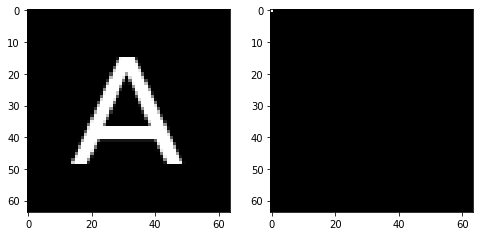

epoch: 0 iter: 100
epoch: 0 iter: 101
epoch: 0 iter: 102
epoch: 0 iter: 103
epoch: 0 iter: 104
epoch: 0 iter: 105
epoch: 0 iter: 106
epoch: 0 iter: 107
epoch: 0 iter: 108
epoch: 0 iter: 109
epoch: 0 iter: 110
epoch: 0 iter: 111
epoch: 0 iter: 112
epoch: 0 iter: 113
epoch: 0 iter: 114
epoch: 0 iter: 115
epoch: 0 iter: 116
epoch: 0 iter: 117
epoch: 0 iter: 118
epoch: 0 iter: 119
epoch: 0 iter: 120
epoch: 0 iter: 121
epoch: 0 iter: 122
epoch: 0 iter: 123
epoch: 0 iter: 124
epoch: 0 iter: 125
epoch: 0 iter: 126
epoch: 0 iter: 127
epoch: 0 iter: 128
epoch: 0 iter: 129
epoch: 0 iter: 130
epoch: 0 iter: 131
epoch: 0 iter: 132
epoch: 0 iter: 133
epoch: 0 iter: 134
epoch: 0 iter: 135
epoch: 0 iter: 136
epoch: 0 iter: 137
epoch: 0 iter: 138
epoch: 0 iter: 139
epoch: 0 iter: 140
epoch: 0 iter: 141
epoch: 0 iter: 142
epoch: 0 iter: 143
epoch: 0 iter: 144
epoch: 0 iter: 145
epoch: 0 iter: 146
epoch: 0 iter: 147
epoch: 0 iter: 148
epoch: 0 iter: 149
epoch: 0 iter: 150
epoch: 0 iter: 151
epoch: 0 ite

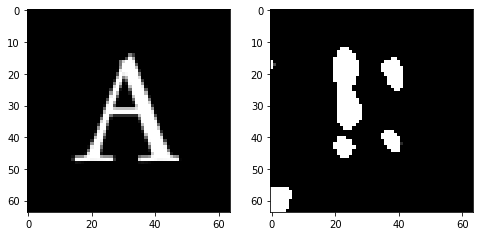

epoch: 1 iter: 100
epoch: 1 iter: 101
epoch: 1 iter: 102
epoch: 1 iter: 103
epoch: 1 iter: 104
epoch: 1 iter: 105
epoch: 1 iter: 106
epoch: 1 iter: 107
epoch: 1 iter: 108
epoch: 1 iter: 109
epoch: 1 iter: 110
epoch: 1 iter: 111
epoch: 1 iter: 112
epoch: 1 iter: 113
epoch: 1 iter: 114
epoch: 1 iter: 115
epoch: 1 iter: 116
epoch: 1 iter: 117
epoch: 1 iter: 118
epoch: 1 iter: 119
epoch: 1 iter: 120
epoch: 1 iter: 121
epoch: 1 iter: 122
epoch: 1 iter: 123
epoch: 1 iter: 124
epoch: 1 iter: 125
epoch: 1 iter: 126
epoch: 1 iter: 127
epoch: 1 iter: 128
epoch: 1 iter: 129
epoch: 1 iter: 130
epoch: 1 iter: 131
epoch: 1 iter: 132
epoch: 1 iter: 133
epoch: 1 iter: 134
epoch: 1 iter: 135
epoch: 1 iter: 136
epoch: 1 iter: 137
epoch: 1 iter: 138
epoch: 1 iter: 139
epoch: 1 iter: 140
epoch: 1 iter: 141
epoch: 1 iter: 142
epoch: 1 iter: 143
epoch: 1 iter: 144
epoch: 1 iter: 145
epoch: 1 iter: 146
epoch: 1 iter: 147
epoch: 1 iter: 148
epoch: 1 iter: 149
epoch: 1 iter: 150
epoch: 1 iter: 151
epoch: 1 ite

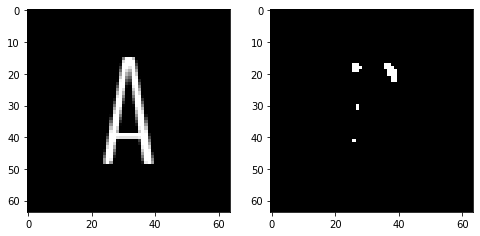

epoch: 2 iter: 100
epoch: 2 iter: 101
epoch: 2 iter: 102
epoch: 2 iter: 103
epoch: 2 iter: 104
epoch: 2 iter: 105
epoch: 2 iter: 106
epoch: 2 iter: 107
epoch: 2 iter: 108
epoch: 2 iter: 109
epoch: 2 iter: 110
epoch: 2 iter: 111
epoch: 2 iter: 112
epoch: 2 iter: 113
epoch: 2 iter: 114
epoch: 2 iter: 115
epoch: 2 iter: 116
epoch: 2 iter: 117
epoch: 2 iter: 118
epoch: 2 iter: 119
epoch: 2 iter: 120
epoch: 2 iter: 121
epoch: 2 iter: 122
epoch: 2 iter: 123
epoch: 2 iter: 124
epoch: 2 iter: 125
epoch: 2 iter: 126
epoch: 2 iter: 127
epoch: 2 iter: 128
epoch: 2 iter: 129
epoch: 2 iter: 130
epoch: 2 iter: 131
epoch: 2 iter: 132
epoch: 2 iter: 133
epoch: 2 iter: 134
epoch: 2 iter: 135
epoch: 2 iter: 136
epoch: 2 iter: 137
epoch: 2 iter: 138
epoch: 2 iter: 139
epoch: 2 iter: 140
epoch: 2 iter: 141
epoch: 2 iter: 142
epoch: 2 iter: 143
epoch: 2 iter: 144
epoch: 2 iter: 145
epoch: 2 iter: 146
epoch: 2 iter: 147
epoch: 2 iter: 148
epoch: 2 iter: 149
epoch: 2 iter: 150
epoch: 2 iter: 151
epoch: 2 ite

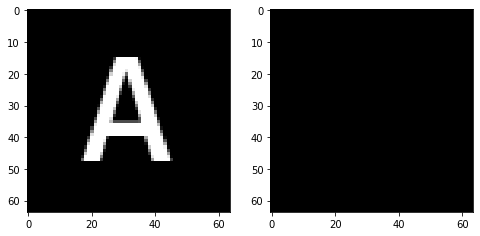

epoch: 3 iter: 100
epoch: 3 iter: 101
epoch: 3 iter: 102
epoch: 3 iter: 103
epoch: 3 iter: 104
epoch: 3 iter: 105
epoch: 3 iter: 106
epoch: 3 iter: 107
epoch: 3 iter: 108
epoch: 3 iter: 109
epoch: 3 iter: 110
epoch: 3 iter: 111
epoch: 3 iter: 112
epoch: 3 iter: 113
epoch: 3 iter: 114
epoch: 3 iter: 115
epoch: 3 iter: 116
epoch: 3 iter: 117
epoch: 3 iter: 118
epoch: 3 iter: 119
epoch: 3 iter: 120
epoch: 3 iter: 121
epoch: 3 iter: 122
epoch: 3 iter: 123
epoch: 3 iter: 124
epoch: 3 iter: 125
epoch: 3 iter: 126
epoch: 3 iter: 127
epoch: 3 iter: 128
epoch: 3 iter: 129
epoch: 3 iter: 130
epoch: 3 iter: 131
epoch: 3 iter: 132
epoch: 3 iter: 133
epoch: 3 iter: 134
epoch: 3 iter: 135
epoch: 3 iter: 136
epoch: 3 iter: 137
epoch: 3 iter: 138
epoch: 3 iter: 139
epoch: 3 iter: 140
epoch: 3 iter: 141
epoch: 3 iter: 142
epoch: 3 iter: 143
epoch: 3 iter: 144
epoch: 3 iter: 145
epoch: 3 iter: 146
epoch: 3 iter: 147
epoch: 3 iter: 148
epoch: 3 iter: 149
epoch: 3 iter: 150
epoch: 3 iter: 151
epoch: 3 ite

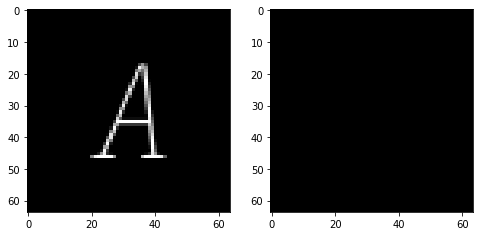

epoch: 4 iter: 100
epoch: 4 iter: 101
epoch: 4 iter: 102
epoch: 4 iter: 103
epoch: 4 iter: 104
epoch: 4 iter: 105
epoch: 4 iter: 106
epoch: 4 iter: 107
epoch: 4 iter: 108
epoch: 4 iter: 109
epoch: 4 iter: 110
epoch: 4 iter: 111
epoch: 4 iter: 112
epoch: 4 iter: 113
epoch: 4 iter: 114
epoch: 4 iter: 115
epoch: 4 iter: 116
epoch: 4 iter: 117
epoch: 4 iter: 118
epoch: 4 iter: 119
epoch: 4 iter: 120
epoch: 4 iter: 121
epoch: 4 iter: 122
epoch: 4 iter: 123
epoch: 4 iter: 124
epoch: 4 iter: 125
epoch: 4 iter: 126
epoch: 4 iter: 127
epoch: 4 iter: 128
epoch: 4 iter: 129
epoch: 4 iter: 130
epoch: 4 iter: 131
epoch: 4 iter: 132
epoch: 4 iter: 133
epoch: 4 iter: 134
epoch: 4 iter: 135
epoch: 4 iter: 136
epoch: 4 iter: 137
epoch: 4 iter: 138
epoch: 4 iter: 139
epoch: 4 iter: 140
epoch: 4 iter: 141
epoch: 4 iter: 142
epoch: 4 iter: 143
epoch: 4 iter: 144
epoch: 4 iter: 145
epoch: 4 iter: 146
epoch: 4 iter: 147
epoch: 4 iter: 148
epoch: 4 iter: 149
epoch: 4 iter: 150
epoch: 4 iter: 151
epoch: 4 ite

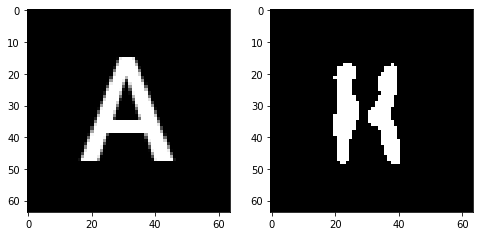

epoch: 5 iter: 100
epoch: 5 iter: 101
epoch: 5 iter: 102
epoch: 5 iter: 103
epoch: 5 iter: 104
epoch: 5 iter: 105
epoch: 5 iter: 106
epoch: 5 iter: 107
epoch: 5 iter: 108
epoch: 5 iter: 109
epoch: 5 iter: 110
epoch: 5 iter: 111
epoch: 5 iter: 112
epoch: 5 iter: 113
epoch: 5 iter: 114
epoch: 5 iter: 115
epoch: 5 iter: 116
epoch: 5 iter: 117
epoch: 5 iter: 118
epoch: 5 iter: 119
epoch: 5 iter: 120
epoch: 5 iter: 121
epoch: 5 iter: 122
epoch: 5 iter: 123
epoch: 5 iter: 124
epoch: 5 iter: 125
epoch: 5 iter: 126
epoch: 5 iter: 127
epoch: 5 iter: 128
epoch: 5 iter: 129
epoch: 5 iter: 130
epoch: 5 iter: 131
epoch: 5 iter: 132
epoch: 5 iter: 133
epoch: 5 iter: 134
epoch: 5 iter: 135
epoch: 5 iter: 136
epoch: 5 iter: 137
epoch: 5 iter: 138
epoch: 5 iter: 139
epoch: 5 iter: 140
epoch: 5 iter: 141
epoch: 5 iter: 142
epoch: 5 iter: 143
epoch: 5 iter: 144
epoch: 5 iter: 145
epoch: 5 iter: 146
epoch: 5 iter: 147
epoch: 5 iter: 148
epoch: 5 iter: 149
epoch: 5 iter: 150
epoch: 5 iter: 151
epoch: 5 ite

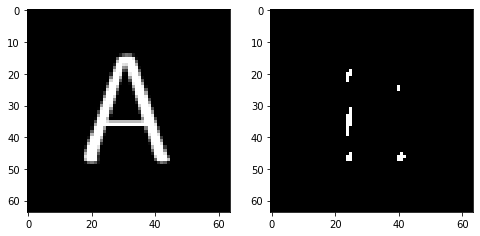

epoch: 6 iter: 100
epoch: 6 iter: 101
epoch: 6 iter: 102
epoch: 6 iter: 103
epoch: 6 iter: 104
epoch: 6 iter: 105
epoch: 6 iter: 106
epoch: 6 iter: 107
epoch: 6 iter: 108
epoch: 6 iter: 109
epoch: 6 iter: 110
epoch: 6 iter: 111
epoch: 6 iter: 112
epoch: 6 iter: 113
epoch: 6 iter: 114
epoch: 6 iter: 115
epoch: 6 iter: 116
epoch: 6 iter: 117
epoch: 6 iter: 118
epoch: 6 iter: 119
epoch: 6 iter: 120
epoch: 6 iter: 121
epoch: 6 iter: 122
epoch: 6 iter: 123
epoch: 6 iter: 124
epoch: 6 iter: 125
epoch: 6 iter: 126
epoch: 6 iter: 127
epoch: 6 iter: 128
epoch: 6 iter: 129
epoch: 6 iter: 130
epoch: 6 iter: 131
epoch: 6 iter: 132
epoch: 6 iter: 133
epoch: 6 iter: 134
epoch: 6 iter: 135
epoch: 6 iter: 136
epoch: 6 iter: 137
epoch: 6 iter: 138
epoch: 6 iter: 139
epoch: 6 iter: 140
epoch: 6 iter: 141
epoch: 6 iter: 142
epoch: 6 iter: 143
epoch: 6 iter: 144
epoch: 6 iter: 145
epoch: 6 iter: 146
epoch: 6 iter: 147
epoch: 6 iter: 148
epoch: 6 iter: 149
epoch: 6 iter: 150
epoch: 6 iter: 151
epoch: 6 ite

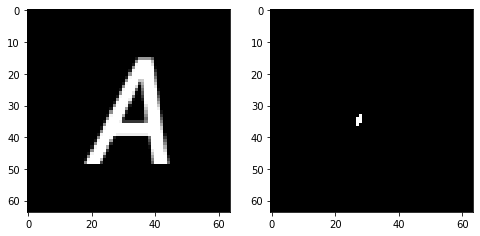

epoch: 7 iter: 100
epoch: 7 iter: 101
epoch: 7 iter: 102
epoch: 7 iter: 103
epoch: 7 iter: 104
epoch: 7 iter: 105
epoch: 7 iter: 106
epoch: 7 iter: 107
epoch: 7 iter: 108
epoch: 7 iter: 109
epoch: 7 iter: 110
epoch: 7 iter: 111
epoch: 7 iter: 112
epoch: 7 iter: 113
epoch: 7 iter: 114
epoch: 7 iter: 115
epoch: 7 iter: 116
epoch: 7 iter: 117
epoch: 7 iter: 118
epoch: 7 iter: 119
epoch: 7 iter: 120
epoch: 7 iter: 121
epoch: 7 iter: 122
epoch: 7 iter: 123
epoch: 7 iter: 124
epoch: 7 iter: 125
epoch: 7 iter: 126
epoch: 7 iter: 127
epoch: 7 iter: 128
epoch: 7 iter: 129
epoch: 7 iter: 130
epoch: 7 iter: 131
epoch: 7 iter: 132
epoch: 7 iter: 133
epoch: 7 iter: 134
epoch: 7 iter: 135
epoch: 7 iter: 136
epoch: 7 iter: 137
epoch: 7 iter: 138
epoch: 7 iter: 139
epoch: 7 iter: 140
epoch: 7 iter: 141
epoch: 7 iter: 142
epoch: 7 iter: 143
epoch: 7 iter: 144
epoch: 7 iter: 145
epoch: 7 iter: 146
epoch: 7 iter: 147
epoch: 7 iter: 148
epoch: 7 iter: 149
epoch: 7 iter: 150
epoch: 7 iter: 151
epoch: 7 ite

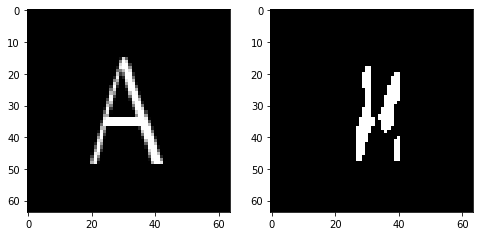

epoch: 8 iter: 100
epoch: 8 iter: 101
epoch: 8 iter: 102
epoch: 8 iter: 103
epoch: 8 iter: 104
epoch: 8 iter: 105
epoch: 8 iter: 106
epoch: 8 iter: 107
epoch: 8 iter: 108
epoch: 8 iter: 109
epoch: 8 iter: 110
epoch: 8 iter: 111
epoch: 8 iter: 112
epoch: 8 iter: 113
epoch: 8 iter: 114
epoch: 8 iter: 115
epoch: 8 iter: 116
epoch: 8 iter: 117
epoch: 8 iter: 118
epoch: 8 iter: 119
epoch: 8 iter: 120
epoch: 8 iter: 121
epoch: 8 iter: 122
epoch: 8 iter: 123
epoch: 8 iter: 124
epoch: 8 iter: 125
epoch: 8 iter: 126
epoch: 8 iter: 127
epoch: 8 iter: 128
epoch: 8 iter: 129
epoch: 8 iter: 130
epoch: 8 iter: 131
epoch: 8 iter: 132
epoch: 8 iter: 133
epoch: 8 iter: 134
epoch: 8 iter: 135
epoch: 8 iter: 136
epoch: 8 iter: 137
epoch: 8 iter: 138
epoch: 8 iter: 139
epoch: 8 iter: 140
epoch: 8 iter: 141
epoch: 8 iter: 142
epoch: 8 iter: 143
epoch: 8 iter: 144
epoch: 8 iter: 145
epoch: 8 iter: 146
epoch: 8 iter: 147
epoch: 8 iter: 148
epoch: 8 iter: 149
epoch: 8 iter: 150
epoch: 8 iter: 151
epoch: 8 ite

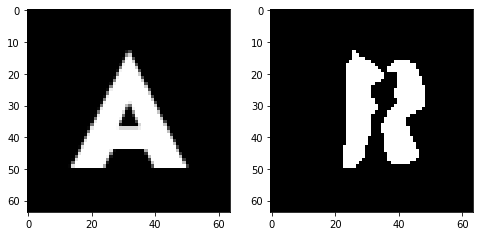

epoch: 9 iter: 100
epoch: 9 iter: 101
epoch: 9 iter: 102
epoch: 9 iter: 103
epoch: 9 iter: 104
epoch: 9 iter: 105
epoch: 9 iter: 106
epoch: 9 iter: 107
epoch: 9 iter: 108
epoch: 9 iter: 109
epoch: 9 iter: 110
epoch: 9 iter: 111
epoch: 9 iter: 112
epoch: 9 iter: 113
epoch: 9 iter: 114
epoch: 9 iter: 115
epoch: 9 iter: 116
epoch: 9 iter: 117
epoch: 9 iter: 118
epoch: 9 iter: 119
epoch: 9 iter: 120
epoch: 9 iter: 121
epoch: 9 iter: 122
epoch: 9 iter: 123
epoch: 9 iter: 124
epoch: 9 iter: 125
epoch: 9 iter: 126
epoch: 9 iter: 127
epoch: 9 iter: 128
epoch: 9 iter: 129
epoch: 9 iter: 130
epoch: 9 iter: 131
epoch: 9 iter: 132
epoch: 9 iter: 133
epoch: 9 iter: 134
epoch: 9 iter: 135
epoch: 9 iter: 136
epoch: 9 iter: 137
epoch: 9 iter: 138
epoch: 9 iter: 139
epoch: 9 iter: 140
epoch: 9 iter: 141
epoch: 9 iter: 142
epoch: 9 iter: 143
epoch: 9 iter: 144
epoch: 9 iter: 145
epoch: 9 iter: 146
epoch: 9 iter: 147
epoch: 9 iter: 148
epoch: 9 iter: 149
epoch: 9 iter: 150
epoch: 9 iter: 151
epoch: 9 ite

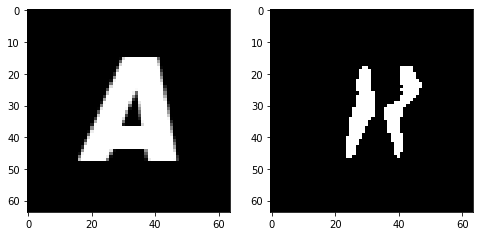

epoch: 10 iter: 100
epoch: 10 iter: 101
epoch: 10 iter: 102
epoch: 10 iter: 103
epoch: 10 iter: 104
epoch: 10 iter: 105
epoch: 10 iter: 106
epoch: 10 iter: 107
epoch: 10 iter: 108
epoch: 10 iter: 109
epoch: 10 iter: 110
epoch: 10 iter: 111
epoch: 10 iter: 112
epoch: 10 iter: 113
epoch: 10 iter: 114
epoch: 10 iter: 115
epoch: 10 iter: 116
epoch: 10 iter: 117
epoch: 10 iter: 118
epoch: 10 iter: 119
epoch: 10 iter: 120
epoch: 10 iter: 121
epoch: 10 iter: 122
epoch: 10 iter: 123
epoch: 10 iter: 124
epoch: 10 iter: 125
epoch: 10 iter: 126
epoch: 10 iter: 127
epoch: 10 iter: 128
epoch: 10 iter: 129
epoch: 10 iter: 130
epoch: 10 iter: 131
epoch: 10 iter: 132
epoch: 10 iter: 133
epoch: 10 iter: 134
epoch: 10 iter: 135
epoch: 10 iter: 136
epoch: 10 iter: 137
epoch: 10 iter: 138
epoch: 10 iter: 139
epoch: 10 iter: 140
epoch: 10 iter: 141
epoch: 10 iter: 142
epoch: 10 iter: 143
epoch: 10 iter: 144
epoch: 10 iter: 145
epoch: 10 iter: 146
epoch: 10 iter: 147
epoch: 10 iter: 148
epoch: 10 iter: 149


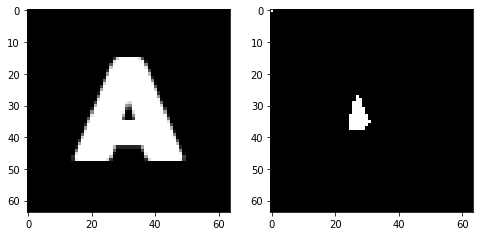

epoch: 11 iter: 100
epoch: 11 iter: 101
epoch: 11 iter: 102
epoch: 11 iter: 103
epoch: 11 iter: 104
epoch: 11 iter: 105
epoch: 11 iter: 106
epoch: 11 iter: 107
epoch: 11 iter: 108
epoch: 11 iter: 109
epoch: 11 iter: 110
epoch: 11 iter: 111
epoch: 11 iter: 112
epoch: 11 iter: 113
epoch: 11 iter: 114
epoch: 11 iter: 115
epoch: 11 iter: 116
epoch: 11 iter: 117
epoch: 11 iter: 118
epoch: 11 iter: 119
epoch: 11 iter: 120
epoch: 11 iter: 121
epoch: 11 iter: 122
epoch: 11 iter: 123
epoch: 11 iter: 124
epoch: 11 iter: 125
epoch: 11 iter: 126
epoch: 11 iter: 127
epoch: 11 iter: 128
epoch: 11 iter: 129
epoch: 11 iter: 130
epoch: 11 iter: 131
epoch: 11 iter: 132
epoch: 11 iter: 133
epoch: 11 iter: 134
epoch: 11 iter: 135
epoch: 11 iter: 136
epoch: 11 iter: 137
epoch: 11 iter: 138
epoch: 11 iter: 139
epoch: 11 iter: 140
epoch: 11 iter: 141
epoch: 11 iter: 142
epoch: 11 iter: 143
epoch: 11 iter: 144
epoch: 11 iter: 145
epoch: 11 iter: 146
epoch: 11 iter: 147
epoch: 11 iter: 148
epoch: 11 iter: 149


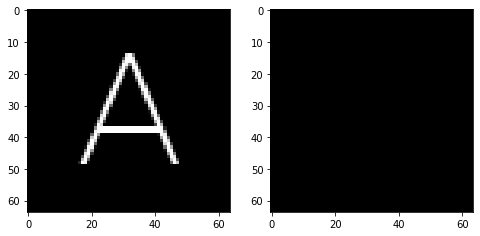

epoch: 12 iter: 100
epoch: 12 iter: 101
epoch: 12 iter: 102
epoch: 12 iter: 103
epoch: 12 iter: 104
epoch: 12 iter: 105
epoch: 12 iter: 106
epoch: 12 iter: 107
epoch: 12 iter: 108
epoch: 12 iter: 109
epoch: 12 iter: 110
epoch: 12 iter: 111
epoch: 12 iter: 112
epoch: 12 iter: 113
epoch: 12 iter: 114
epoch: 12 iter: 115
epoch: 12 iter: 116
epoch: 12 iter: 117
epoch: 12 iter: 118
epoch: 12 iter: 119
epoch: 12 iter: 120
epoch: 12 iter: 121
epoch: 12 iter: 122
epoch: 12 iter: 123
epoch: 12 iter: 124
epoch: 12 iter: 125
epoch: 12 iter: 126
epoch: 12 iter: 127
epoch: 12 iter: 128
epoch: 12 iter: 129
epoch: 12 iter: 130
epoch: 12 iter: 131
epoch: 12 iter: 132
epoch: 12 iter: 133
epoch: 12 iter: 134
epoch: 12 iter: 135
epoch: 12 iter: 136
epoch: 12 iter: 137
epoch: 12 iter: 138
epoch: 12 iter: 139
epoch: 12 iter: 140
epoch: 12 iter: 141
epoch: 12 iter: 142
epoch: 12 iter: 143
epoch: 12 iter: 144
epoch: 12 iter: 145
epoch: 12 iter: 146
epoch: 12 iter: 147
epoch: 12 iter: 148
epoch: 12 iter: 149


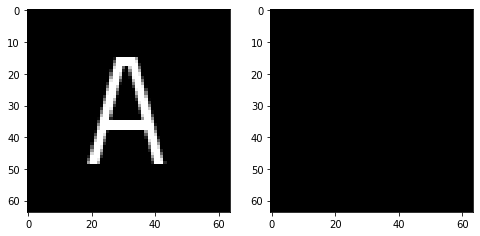

epoch: 13 iter: 100
epoch: 13 iter: 101
epoch: 13 iter: 102
epoch: 13 iter: 103
epoch: 13 iter: 104
epoch: 13 iter: 105
epoch: 13 iter: 106
epoch: 13 iter: 107
epoch: 13 iter: 108
epoch: 13 iter: 109
epoch: 13 iter: 110
epoch: 13 iter: 111
epoch: 13 iter: 112
epoch: 13 iter: 113
epoch: 13 iter: 114
epoch: 13 iter: 115
epoch: 13 iter: 116
epoch: 13 iter: 117
epoch: 13 iter: 118
epoch: 13 iter: 119
epoch: 13 iter: 120
epoch: 13 iter: 121
epoch: 13 iter: 122
epoch: 13 iter: 123
epoch: 13 iter: 124
epoch: 13 iter: 125
epoch: 13 iter: 126
epoch: 13 iter: 127
epoch: 13 iter: 128
epoch: 13 iter: 129
epoch: 13 iter: 130
epoch: 13 iter: 131
epoch: 13 iter: 132
epoch: 13 iter: 133
epoch: 13 iter: 134
epoch: 13 iter: 135
epoch: 13 iter: 136
epoch: 13 iter: 137
epoch: 13 iter: 138
epoch: 13 iter: 139
epoch: 13 iter: 140
epoch: 13 iter: 141
epoch: 13 iter: 142
epoch: 13 iter: 143
epoch: 13 iter: 144
epoch: 13 iter: 145
epoch: 13 iter: 146
epoch: 13 iter: 147
epoch: 13 iter: 148
epoch: 13 iter: 149


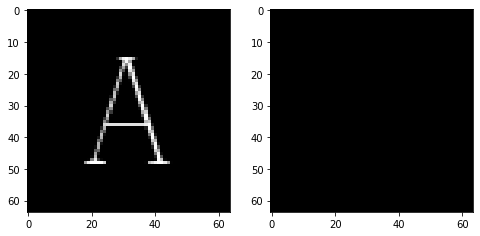

epoch: 14 iter: 100
epoch: 14 iter: 101
epoch: 14 iter: 102
epoch: 14 iter: 103
epoch: 14 iter: 104
epoch: 14 iter: 105
epoch: 14 iter: 106
epoch: 14 iter: 107
epoch: 14 iter: 108
epoch: 14 iter: 109
epoch: 14 iter: 110
epoch: 14 iter: 111
epoch: 14 iter: 112
epoch: 14 iter: 113
epoch: 14 iter: 114
epoch: 14 iter: 115
epoch: 14 iter: 116
epoch: 14 iter: 117
epoch: 14 iter: 118
epoch: 14 iter: 119
epoch: 14 iter: 120
epoch: 14 iter: 121
epoch: 14 iter: 122
epoch: 14 iter: 123
epoch: 14 iter: 124
epoch: 14 iter: 125
epoch: 14 iter: 126
epoch: 14 iter: 127
epoch: 14 iter: 128
epoch: 14 iter: 129
epoch: 14 iter: 130
epoch: 14 iter: 131
epoch: 14 iter: 132
epoch: 14 iter: 133
epoch: 14 iter: 134
epoch: 14 iter: 135
epoch: 14 iter: 136
epoch: 14 iter: 137
epoch: 14 iter: 138
epoch: 14 iter: 139
epoch: 14 iter: 140
epoch: 14 iter: 141
epoch: 14 iter: 142
epoch: 14 iter: 143
epoch: 14 iter: 144
epoch: 14 iter: 145
epoch: 14 iter: 146
epoch: 14 iter: 147
epoch: 14 iter: 148
epoch: 14 iter: 149


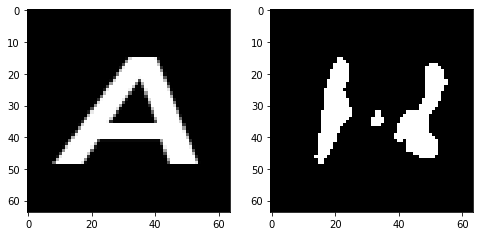

epoch: 15 iter: 100
epoch: 15 iter: 101
epoch: 15 iter: 102
epoch: 15 iter: 103
epoch: 15 iter: 104
epoch: 15 iter: 105
epoch: 15 iter: 106
epoch: 15 iter: 107
epoch: 15 iter: 108
epoch: 15 iter: 109
epoch: 15 iter: 110
epoch: 15 iter: 111
epoch: 15 iter: 112
epoch: 15 iter: 113
epoch: 15 iter: 114
epoch: 15 iter: 115
epoch: 15 iter: 116
epoch: 15 iter: 117
epoch: 15 iter: 118
epoch: 15 iter: 119
epoch: 15 iter: 120
epoch: 15 iter: 121
epoch: 15 iter: 122
epoch: 15 iter: 123
epoch: 15 iter: 124
epoch: 15 iter: 125
epoch: 15 iter: 126
epoch: 15 iter: 127
epoch: 15 iter: 128
epoch: 15 iter: 129
epoch: 15 iter: 130
epoch: 15 iter: 131
epoch: 15 iter: 132
epoch: 15 iter: 133
epoch: 15 iter: 134
epoch: 15 iter: 135
epoch: 15 iter: 136
epoch: 15 iter: 137
epoch: 15 iter: 138
epoch: 15 iter: 139
epoch: 15 iter: 140
epoch: 15 iter: 141
epoch: 15 iter: 142
epoch: 15 iter: 143
epoch: 15 iter: 144
epoch: 15 iter: 145
epoch: 15 iter: 146
epoch: 15 iter: 147
epoch: 15 iter: 148
epoch: 15 iter: 149


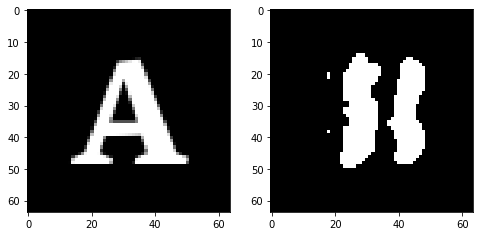

epoch: 16 iter: 100
epoch: 16 iter: 101
epoch: 16 iter: 102
epoch: 16 iter: 103
epoch: 16 iter: 104
epoch: 16 iter: 105
epoch: 16 iter: 106
epoch: 16 iter: 107
epoch: 16 iter: 108
epoch: 16 iter: 109
epoch: 16 iter: 110
epoch: 16 iter: 111
epoch: 16 iter: 112
epoch: 16 iter: 113
epoch: 16 iter: 114
epoch: 16 iter: 115
epoch: 16 iter: 116
epoch: 16 iter: 117
epoch: 16 iter: 118
epoch: 16 iter: 119
epoch: 16 iter: 120
epoch: 16 iter: 121
epoch: 16 iter: 122
epoch: 16 iter: 123
epoch: 16 iter: 124
epoch: 16 iter: 125
epoch: 16 iter: 126
epoch: 16 iter: 127
epoch: 16 iter: 128
epoch: 16 iter: 129
epoch: 16 iter: 130
epoch: 16 iter: 131
epoch: 16 iter: 132
epoch: 16 iter: 133
epoch: 16 iter: 134
epoch: 16 iter: 135
epoch: 16 iter: 136
epoch: 16 iter: 137
epoch: 16 iter: 138
epoch: 16 iter: 139
epoch: 16 iter: 140
epoch: 16 iter: 141
epoch: 16 iter: 142
epoch: 16 iter: 143
epoch: 16 iter: 144
epoch: 16 iter: 145
epoch: 16 iter: 146
epoch: 16 iter: 147
epoch: 16 iter: 148
epoch: 16 iter: 149


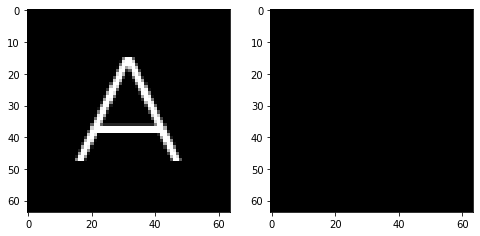

epoch: 17 iter: 100
epoch: 17 iter: 101
epoch: 17 iter: 102
epoch: 17 iter: 103
epoch: 17 iter: 104
epoch: 17 iter: 105
epoch: 17 iter: 106
epoch: 17 iter: 107
epoch: 17 iter: 108
epoch: 17 iter: 109
epoch: 17 iter: 110
epoch: 17 iter: 111
epoch: 17 iter: 112
epoch: 17 iter: 113
epoch: 17 iter: 114
epoch: 17 iter: 115
epoch: 17 iter: 116
epoch: 17 iter: 117
epoch: 17 iter: 118
epoch: 17 iter: 119
epoch: 17 iter: 120
epoch: 17 iter: 121
epoch: 17 iter: 122
epoch: 17 iter: 123
epoch: 17 iter: 124
epoch: 17 iter: 125
epoch: 17 iter: 126
epoch: 17 iter: 127
epoch: 17 iter: 128
epoch: 17 iter: 129
epoch: 17 iter: 130
epoch: 17 iter: 131
epoch: 17 iter: 132
epoch: 17 iter: 133
epoch: 17 iter: 134
epoch: 17 iter: 135
epoch: 17 iter: 136
epoch: 17 iter: 137
epoch: 17 iter: 138
epoch: 17 iter: 139
epoch: 17 iter: 140
epoch: 17 iter: 141
epoch: 17 iter: 142
epoch: 17 iter: 143
epoch: 17 iter: 144
epoch: 17 iter: 145
epoch: 17 iter: 146
epoch: 17 iter: 147
epoch: 17 iter: 148
epoch: 17 iter: 149


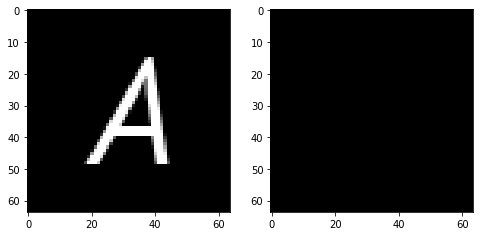

epoch: 18 iter: 100
epoch: 18 iter: 101
epoch: 18 iter: 102
epoch: 18 iter: 103
epoch: 18 iter: 104
epoch: 18 iter: 105
epoch: 18 iter: 106
epoch: 18 iter: 107
epoch: 18 iter: 108
epoch: 18 iter: 109
epoch: 18 iter: 110
epoch: 18 iter: 111
epoch: 18 iter: 112
epoch: 18 iter: 113
epoch: 18 iter: 114
epoch: 18 iter: 115
epoch: 18 iter: 116
epoch: 18 iter: 117
epoch: 18 iter: 118
epoch: 18 iter: 119
epoch: 18 iter: 120
epoch: 18 iter: 121
epoch: 18 iter: 122
epoch: 18 iter: 123
epoch: 18 iter: 124
epoch: 18 iter: 125
epoch: 18 iter: 126
epoch: 18 iter: 127
epoch: 18 iter: 128
epoch: 18 iter: 129
epoch: 18 iter: 130
epoch: 18 iter: 131
epoch: 18 iter: 132
epoch: 18 iter: 133
epoch: 18 iter: 134
epoch: 18 iter: 135
epoch: 18 iter: 136
epoch: 18 iter: 137
epoch: 18 iter: 138
epoch: 18 iter: 139
epoch: 18 iter: 140
epoch: 18 iter: 141
epoch: 18 iter: 142
epoch: 18 iter: 143
epoch: 18 iter: 144
epoch: 18 iter: 145
epoch: 18 iter: 146
epoch: 18 iter: 147
epoch: 18 iter: 148
epoch: 18 iter: 149


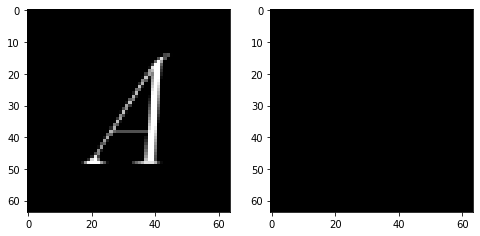

epoch: 19 iter: 100
epoch: 19 iter: 101
epoch: 19 iter: 102
epoch: 19 iter: 103
epoch: 19 iter: 104
epoch: 19 iter: 105
epoch: 19 iter: 106
epoch: 19 iter: 107
epoch: 19 iter: 108
epoch: 19 iter: 109
epoch: 19 iter: 110
epoch: 19 iter: 111
epoch: 19 iter: 112
epoch: 19 iter: 113
epoch: 19 iter: 114
epoch: 19 iter: 115
epoch: 19 iter: 116
epoch: 19 iter: 117
epoch: 19 iter: 118
epoch: 19 iter: 119
epoch: 19 iter: 120
epoch: 19 iter: 121
epoch: 19 iter: 122
epoch: 19 iter: 123
epoch: 19 iter: 124
epoch: 19 iter: 125
epoch: 19 iter: 126
epoch: 19 iter: 127
epoch: 19 iter: 128
epoch: 19 iter: 129
epoch: 19 iter: 130
epoch: 19 iter: 131
epoch: 19 iter: 132
epoch: 19 iter: 133
epoch: 19 iter: 134
epoch: 19 iter: 135
epoch: 19 iter: 136
epoch: 19 iter: 137
epoch: 19 iter: 138
epoch: 19 iter: 139
epoch: 19 iter: 140
epoch: 19 iter: 141
epoch: 19 iter: 142
epoch: 19 iter: 143
epoch: 19 iter: 144
epoch: 19 iter: 145
epoch: 19 iter: 146
epoch: 19 iter: 147
epoch: 19 iter: 148
epoch: 19 iter: 149


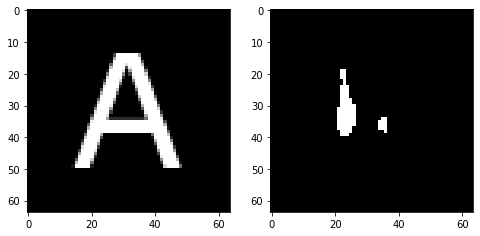

epoch: 20 iter: 100
epoch: 20 iter: 101
epoch: 20 iter: 102
epoch: 20 iter: 103
epoch: 20 iter: 104
epoch: 20 iter: 105
epoch: 20 iter: 106
epoch: 20 iter: 107
epoch: 20 iter: 108
epoch: 20 iter: 109
epoch: 20 iter: 110
epoch: 20 iter: 111
epoch: 20 iter: 112
epoch: 20 iter: 113
epoch: 20 iter: 114
epoch: 20 iter: 115
epoch: 20 iter: 116
epoch: 20 iter: 117
epoch: 20 iter: 118
epoch: 20 iter: 119
epoch: 20 iter: 120
epoch: 20 iter: 121
epoch: 20 iter: 122
epoch: 20 iter: 123
epoch: 20 iter: 124
epoch: 20 iter: 125
epoch: 20 iter: 126
epoch: 20 iter: 127
epoch: 20 iter: 128
epoch: 20 iter: 129
epoch: 20 iter: 130
epoch: 20 iter: 131
epoch: 20 iter: 132
epoch: 20 iter: 133
epoch: 20 iter: 134
epoch: 20 iter: 135
epoch: 20 iter: 136
epoch: 20 iter: 137
epoch: 20 iter: 138
epoch: 20 iter: 139
epoch: 20 iter: 140
epoch: 20 iter: 141
epoch: 20 iter: 142
epoch: 20 iter: 143
epoch: 20 iter: 144
epoch: 20 iter: 145
epoch: 20 iter: 146
epoch: 20 iter: 147
epoch: 20 iter: 148
epoch: 20 iter: 149


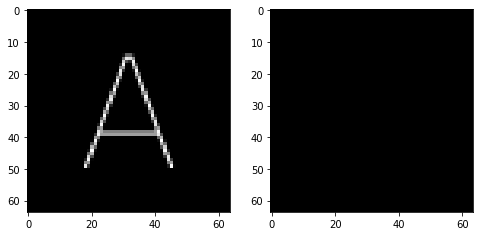

epoch: 21 iter: 100
epoch: 21 iter: 101
epoch: 21 iter: 102
epoch: 21 iter: 103
epoch: 21 iter: 104
epoch: 21 iter: 105
epoch: 21 iter: 106
epoch: 21 iter: 107
epoch: 21 iter: 108
epoch: 21 iter: 109
epoch: 21 iter: 110
epoch: 21 iter: 111
epoch: 21 iter: 112
epoch: 21 iter: 113
epoch: 21 iter: 114
epoch: 21 iter: 115
epoch: 21 iter: 116
epoch: 21 iter: 117
epoch: 21 iter: 118
epoch: 21 iter: 119
epoch: 21 iter: 120
epoch: 21 iter: 121
epoch: 21 iter: 122
epoch: 21 iter: 123
epoch: 21 iter: 124
epoch: 21 iter: 125
epoch: 21 iter: 126
epoch: 21 iter: 127
epoch: 21 iter: 128
epoch: 21 iter: 129
epoch: 21 iter: 130
epoch: 21 iter: 131
epoch: 21 iter: 132
epoch: 21 iter: 133
epoch: 21 iter: 134
epoch: 21 iter: 135
epoch: 21 iter: 136
epoch: 21 iter: 137
epoch: 21 iter: 138
epoch: 21 iter: 139
epoch: 21 iter: 140
epoch: 21 iter: 141
epoch: 21 iter: 142
epoch: 21 iter: 143
epoch: 21 iter: 144
epoch: 21 iter: 145
epoch: 21 iter: 146
epoch: 21 iter: 147
epoch: 21 iter: 148
epoch: 21 iter: 149


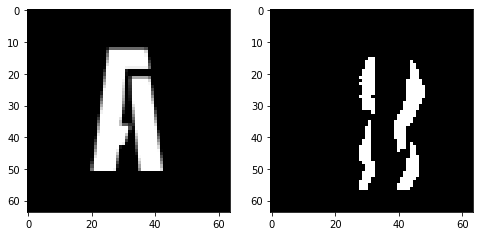

epoch: 22 iter: 100
epoch: 22 iter: 101
epoch: 22 iter: 102
epoch: 22 iter: 103
epoch: 22 iter: 104
epoch: 22 iter: 105
epoch: 22 iter: 106
epoch: 22 iter: 107
epoch: 22 iter: 108
epoch: 22 iter: 109
epoch: 22 iter: 110
epoch: 22 iter: 111
epoch: 22 iter: 112
epoch: 22 iter: 113
epoch: 22 iter: 114
epoch: 22 iter: 115
epoch: 22 iter: 116
epoch: 22 iter: 117
epoch: 22 iter: 118
epoch: 22 iter: 119
epoch: 22 iter: 120
epoch: 22 iter: 121
epoch: 22 iter: 122
epoch: 22 iter: 123
epoch: 22 iter: 124
epoch: 22 iter: 125
epoch: 22 iter: 126
epoch: 22 iter: 127
epoch: 22 iter: 128
epoch: 22 iter: 129
epoch: 22 iter: 130
epoch: 22 iter: 131
epoch: 22 iter: 132
epoch: 22 iter: 133
epoch: 22 iter: 134
epoch: 22 iter: 135
epoch: 22 iter: 136
epoch: 22 iter: 137
epoch: 22 iter: 138
epoch: 22 iter: 139
epoch: 22 iter: 140
epoch: 22 iter: 141
epoch: 22 iter: 142
epoch: 22 iter: 143
epoch: 22 iter: 144
epoch: 22 iter: 145
epoch: 22 iter: 146
epoch: 22 iter: 147
epoch: 22 iter: 148
epoch: 22 iter: 149


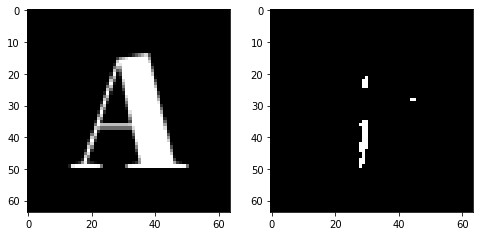

epoch: 23 iter: 100
epoch: 23 iter: 101
epoch: 23 iter: 102
epoch: 23 iter: 103
epoch: 23 iter: 104
epoch: 23 iter: 105
epoch: 23 iter: 106
epoch: 23 iter: 107
epoch: 23 iter: 108
epoch: 23 iter: 109
epoch: 23 iter: 110
epoch: 23 iter: 111
epoch: 23 iter: 112
epoch: 23 iter: 113
epoch: 23 iter: 114
epoch: 23 iter: 115
epoch: 23 iter: 116
epoch: 23 iter: 117
epoch: 23 iter: 118
epoch: 23 iter: 119
epoch: 23 iter: 120
epoch: 23 iter: 121
epoch: 23 iter: 122
epoch: 23 iter: 123
epoch: 23 iter: 124
epoch: 23 iter: 125
epoch: 23 iter: 126
epoch: 23 iter: 127
epoch: 23 iter: 128
epoch: 23 iter: 129
epoch: 23 iter: 130
epoch: 23 iter: 131
epoch: 23 iter: 132
epoch: 23 iter: 133
epoch: 23 iter: 134
epoch: 23 iter: 135
epoch: 23 iter: 136
epoch: 23 iter: 137
epoch: 23 iter: 138
epoch: 23 iter: 139
epoch: 23 iter: 140
epoch: 23 iter: 141
epoch: 23 iter: 142
epoch: 23 iter: 143
epoch: 23 iter: 144
epoch: 23 iter: 145
epoch: 23 iter: 146
epoch: 23 iter: 147
epoch: 23 iter: 148
epoch: 23 iter: 149


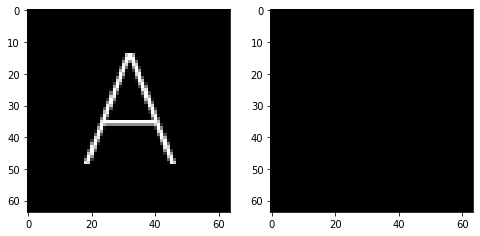

epoch: 24 iter: 100
epoch: 24 iter: 101
epoch: 24 iter: 102
epoch: 24 iter: 103
epoch: 24 iter: 104
epoch: 24 iter: 105
epoch: 24 iter: 106
epoch: 24 iter: 107
epoch: 24 iter: 108
epoch: 24 iter: 109
epoch: 24 iter: 110
epoch: 24 iter: 111
epoch: 24 iter: 112
epoch: 24 iter: 113
epoch: 24 iter: 114
epoch: 24 iter: 115
epoch: 24 iter: 116
epoch: 24 iter: 117
epoch: 24 iter: 118
epoch: 24 iter: 119
epoch: 24 iter: 120
epoch: 24 iter: 121
epoch: 24 iter: 122
epoch: 24 iter: 123
epoch: 24 iter: 124
epoch: 24 iter: 125
epoch: 24 iter: 126
epoch: 24 iter: 127
epoch: 24 iter: 128
epoch: 24 iter: 129
epoch: 24 iter: 130
epoch: 24 iter: 131
epoch: 24 iter: 132
epoch: 24 iter: 133
epoch: 24 iter: 134
epoch: 24 iter: 135
epoch: 24 iter: 136
epoch: 24 iter: 137
epoch: 24 iter: 138
epoch: 24 iter: 139
epoch: 24 iter: 140
epoch: 24 iter: 141
epoch: 24 iter: 142
epoch: 24 iter: 143
epoch: 24 iter: 144
epoch: 24 iter: 145
epoch: 24 iter: 146
epoch: 24 iter: 147
epoch: 24 iter: 148
epoch: 24 iter: 149


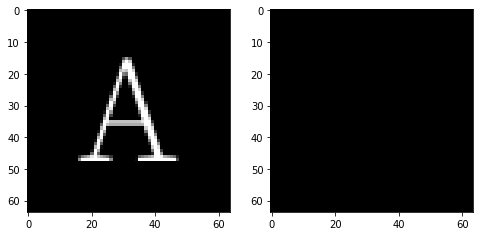

epoch: 25 iter: 100
epoch: 25 iter: 101
epoch: 25 iter: 102
epoch: 25 iter: 103
epoch: 25 iter: 104
epoch: 25 iter: 105
epoch: 25 iter: 106
epoch: 25 iter: 107
epoch: 25 iter: 108
epoch: 25 iter: 109
epoch: 25 iter: 110
epoch: 25 iter: 111
epoch: 25 iter: 112
epoch: 25 iter: 113
epoch: 25 iter: 114
epoch: 25 iter: 115
epoch: 25 iter: 116
epoch: 25 iter: 117
epoch: 25 iter: 118
epoch: 25 iter: 119
epoch: 25 iter: 120
epoch: 25 iter: 121
epoch: 25 iter: 122
epoch: 25 iter: 123
epoch: 25 iter: 124
epoch: 25 iter: 125
epoch: 25 iter: 126
epoch: 25 iter: 127
epoch: 25 iter: 128
epoch: 25 iter: 129
epoch: 25 iter: 130
epoch: 25 iter: 131
epoch: 25 iter: 132
epoch: 25 iter: 133
epoch: 25 iter: 134
epoch: 25 iter: 135
epoch: 25 iter: 136
epoch: 25 iter: 137
epoch: 25 iter: 138
epoch: 25 iter: 139
epoch: 25 iter: 140
epoch: 25 iter: 141
epoch: 25 iter: 142
epoch: 25 iter: 143
epoch: 25 iter: 144
epoch: 25 iter: 145
epoch: 25 iter: 146
epoch: 25 iter: 147
epoch: 25 iter: 148
epoch: 25 iter: 149


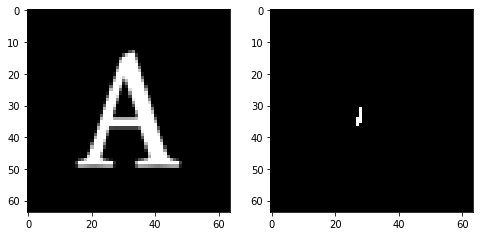

epoch: 26 iter: 100
epoch: 26 iter: 101
epoch: 26 iter: 102
epoch: 26 iter: 103
epoch: 26 iter: 104
epoch: 26 iter: 105
epoch: 26 iter: 106
epoch: 26 iter: 107
epoch: 26 iter: 108
epoch: 26 iter: 109
epoch: 26 iter: 110
epoch: 26 iter: 111
epoch: 26 iter: 112
epoch: 26 iter: 113
epoch: 26 iter: 114
epoch: 26 iter: 115
epoch: 26 iter: 116
epoch: 26 iter: 117
epoch: 26 iter: 118
epoch: 26 iter: 119
epoch: 26 iter: 120
epoch: 26 iter: 121
epoch: 26 iter: 122
epoch: 26 iter: 123
epoch: 26 iter: 124
epoch: 26 iter: 125
epoch: 26 iter: 126
epoch: 26 iter: 127
epoch: 26 iter: 128
epoch: 26 iter: 129
epoch: 26 iter: 130
epoch: 26 iter: 131
epoch: 26 iter: 132
epoch: 26 iter: 133
epoch: 26 iter: 134
epoch: 26 iter: 135
epoch: 26 iter: 136
epoch: 26 iter: 137
epoch: 26 iter: 138
epoch: 26 iter: 139
epoch: 26 iter: 140
epoch: 26 iter: 141
epoch: 26 iter: 142
epoch: 26 iter: 143
epoch: 26 iter: 144
epoch: 26 iter: 145
epoch: 26 iter: 146
epoch: 26 iter: 147
epoch: 26 iter: 148
epoch: 26 iter: 149


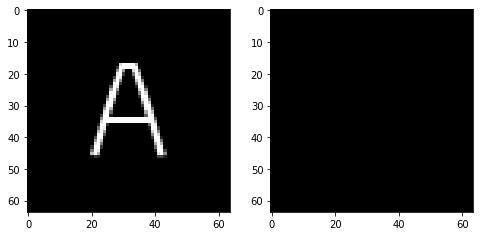

epoch: 27 iter: 100
epoch: 27 iter: 101
epoch: 27 iter: 102
epoch: 27 iter: 103
epoch: 27 iter: 104
epoch: 27 iter: 105
epoch: 27 iter: 106
epoch: 27 iter: 107
epoch: 27 iter: 108
epoch: 27 iter: 109
epoch: 27 iter: 110
epoch: 27 iter: 111
epoch: 27 iter: 112
epoch: 27 iter: 113
epoch: 27 iter: 114
epoch: 27 iter: 115
epoch: 27 iter: 116
epoch: 27 iter: 117
epoch: 27 iter: 118
epoch: 27 iter: 119
epoch: 27 iter: 120
epoch: 27 iter: 121
epoch: 27 iter: 122
epoch: 27 iter: 123
epoch: 27 iter: 124
epoch: 27 iter: 125
epoch: 27 iter: 126
epoch: 27 iter: 127
epoch: 27 iter: 128
epoch: 27 iter: 129
epoch: 27 iter: 130
epoch: 27 iter: 131
epoch: 27 iter: 132
epoch: 27 iter: 133
epoch: 27 iter: 134
epoch: 27 iter: 135
epoch: 27 iter: 136
epoch: 27 iter: 137
epoch: 27 iter: 138
epoch: 27 iter: 139
epoch: 27 iter: 140
epoch: 27 iter: 141
epoch: 27 iter: 142
epoch: 27 iter: 143
epoch: 27 iter: 144
epoch: 27 iter: 145
epoch: 27 iter: 146
epoch: 27 iter: 147
epoch: 27 iter: 148
epoch: 27 iter: 149


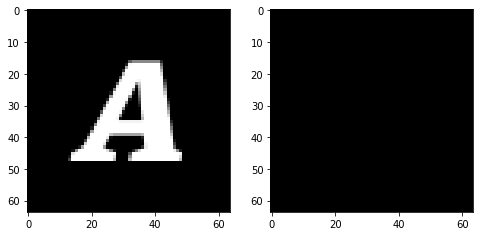

epoch: 28 iter: 100
epoch: 28 iter: 101
epoch: 28 iter: 102
epoch: 28 iter: 103
epoch: 28 iter: 104
epoch: 28 iter: 105
epoch: 28 iter: 106
epoch: 28 iter: 107
epoch: 28 iter: 108
epoch: 28 iter: 109
epoch: 28 iter: 110
epoch: 28 iter: 111
epoch: 28 iter: 112
epoch: 28 iter: 113
epoch: 28 iter: 114
epoch: 28 iter: 115
epoch: 28 iter: 116
epoch: 28 iter: 117
epoch: 28 iter: 118
epoch: 28 iter: 119
epoch: 28 iter: 120
epoch: 28 iter: 121
epoch: 28 iter: 122
epoch: 28 iter: 123
epoch: 28 iter: 124
epoch: 28 iter: 125
epoch: 28 iter: 126
epoch: 28 iter: 127
epoch: 28 iter: 128
epoch: 28 iter: 129
epoch: 28 iter: 130
epoch: 28 iter: 131
epoch: 28 iter: 132
epoch: 28 iter: 133
epoch: 28 iter: 134
epoch: 28 iter: 135
epoch: 28 iter: 136
epoch: 28 iter: 137
epoch: 28 iter: 138
epoch: 28 iter: 139
epoch: 28 iter: 140
epoch: 28 iter: 141
epoch: 28 iter: 142
epoch: 28 iter: 143
epoch: 28 iter: 144
epoch: 28 iter: 145
epoch: 28 iter: 146
epoch: 28 iter: 147
epoch: 28 iter: 148
epoch: 28 iter: 149


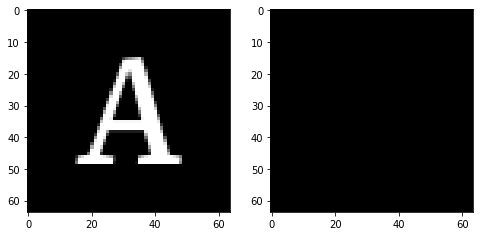

epoch: 29 iter: 100
epoch: 29 iter: 101
epoch: 29 iter: 102
epoch: 29 iter: 103
epoch: 29 iter: 104
epoch: 29 iter: 105
epoch: 29 iter: 106
epoch: 29 iter: 107
epoch: 29 iter: 108
epoch: 29 iter: 109
epoch: 29 iter: 110
epoch: 29 iter: 111
epoch: 29 iter: 112
epoch: 29 iter: 113
epoch: 29 iter: 114
epoch: 29 iter: 115
epoch: 29 iter: 116
epoch: 29 iter: 117
epoch: 29 iter: 118
epoch: 29 iter: 119
epoch: 29 iter: 120
epoch: 29 iter: 121
epoch: 29 iter: 122
epoch: 29 iter: 123
epoch: 29 iter: 124
epoch: 29 iter: 125
epoch: 29 iter: 126
epoch: 29 iter: 127
epoch: 29 iter: 128
epoch: 29 iter: 129
epoch: 29 iter: 130
epoch: 29 iter: 131
epoch: 29 iter: 132
epoch: 29 iter: 133
epoch: 29 iter: 134
epoch: 29 iter: 135
epoch: 29 iter: 136
epoch: 29 iter: 137
epoch: 29 iter: 138
epoch: 29 iter: 139
epoch: 29 iter: 140
epoch: 29 iter: 141
epoch: 29 iter: 142
epoch: 29 iter: 143
epoch: 29 iter: 144
epoch: 29 iter: 145
epoch: 29 iter: 146
epoch: 29 iter: 147
epoch: 29 iter: 148
epoch: 29 iter: 149


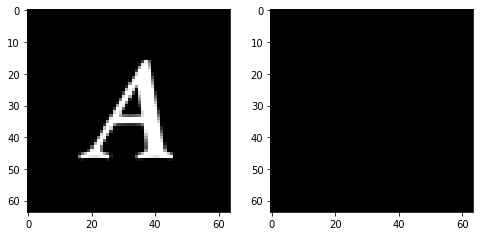

epoch: 30 iter: 100
epoch: 30 iter: 101
epoch: 30 iter: 102
epoch: 30 iter: 103
epoch: 30 iter: 104
epoch: 30 iter: 105
epoch: 30 iter: 106
epoch: 30 iter: 107
epoch: 30 iter: 108
epoch: 30 iter: 109
epoch: 30 iter: 110
epoch: 30 iter: 111
epoch: 30 iter: 112
epoch: 30 iter: 113
epoch: 30 iter: 114
epoch: 30 iter: 115
epoch: 30 iter: 116
epoch: 30 iter: 117
epoch: 30 iter: 118
epoch: 30 iter: 119
epoch: 30 iter: 120
epoch: 30 iter: 121
epoch: 30 iter: 122
epoch: 30 iter: 123
epoch: 30 iter: 124
epoch: 30 iter: 125
epoch: 30 iter: 126
epoch: 30 iter: 127
epoch: 30 iter: 128
epoch: 30 iter: 129
epoch: 30 iter: 130
epoch: 30 iter: 131
epoch: 30 iter: 132
epoch: 30 iter: 133
epoch: 30 iter: 134
epoch: 30 iter: 135
epoch: 30 iter: 136
epoch: 30 iter: 137
epoch: 30 iter: 138
epoch: 30 iter: 139
epoch: 30 iter: 140
epoch: 30 iter: 141
epoch: 30 iter: 142
epoch: 30 iter: 143
epoch: 30 iter: 144
epoch: 30 iter: 145
epoch: 30 iter: 146
epoch: 30 iter: 147
epoch: 30 iter: 148
epoch: 30 iter: 149


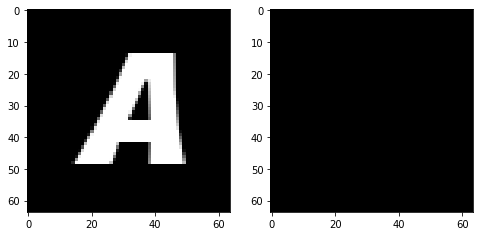

epoch: 31 iter: 100
epoch: 31 iter: 101
epoch: 31 iter: 102
epoch: 31 iter: 103
epoch: 31 iter: 104
epoch: 31 iter: 105
epoch: 31 iter: 106
epoch: 31 iter: 107
epoch: 31 iter: 108
epoch: 31 iter: 109
epoch: 31 iter: 110
epoch: 31 iter: 111
epoch: 31 iter: 112
epoch: 31 iter: 113
epoch: 31 iter: 114
epoch: 31 iter: 115
epoch: 31 iter: 116
epoch: 31 iter: 117
epoch: 31 iter: 118
epoch: 31 iter: 119
epoch: 31 iter: 120
epoch: 31 iter: 121
epoch: 31 iter: 122
epoch: 31 iter: 123
epoch: 31 iter: 124
epoch: 31 iter: 125
epoch: 31 iter: 126
epoch: 31 iter: 127
epoch: 31 iter: 128
epoch: 31 iter: 129
epoch: 31 iter: 130
epoch: 31 iter: 131
epoch: 31 iter: 132
epoch: 31 iter: 133
epoch: 31 iter: 134
epoch: 31 iter: 135
epoch: 31 iter: 136
epoch: 31 iter: 137
epoch: 31 iter: 138
epoch: 31 iter: 139
epoch: 31 iter: 140
epoch: 31 iter: 141
epoch: 31 iter: 142
epoch: 31 iter: 143
epoch: 31 iter: 144
epoch: 31 iter: 145
epoch: 31 iter: 146
epoch: 31 iter: 147
epoch: 31 iter: 148
epoch: 31 iter: 149


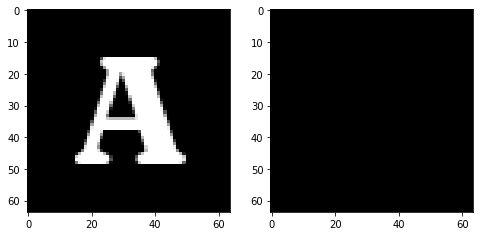

epoch: 32 iter: 100
epoch: 32 iter: 101
epoch: 32 iter: 102
epoch: 32 iter: 103
epoch: 32 iter: 104
epoch: 32 iter: 105
epoch: 32 iter: 106
epoch: 32 iter: 107
epoch: 32 iter: 108
epoch: 32 iter: 109
epoch: 32 iter: 110
epoch: 32 iter: 111
epoch: 32 iter: 112
epoch: 32 iter: 113
epoch: 32 iter: 114
epoch: 32 iter: 115
epoch: 32 iter: 116
epoch: 32 iter: 117
epoch: 32 iter: 118
epoch: 32 iter: 119
epoch: 32 iter: 120
epoch: 32 iter: 121
epoch: 32 iter: 122
epoch: 32 iter: 123
epoch: 32 iter: 124
epoch: 32 iter: 125
epoch: 32 iter: 126
epoch: 32 iter: 127
epoch: 32 iter: 128
epoch: 32 iter: 129
epoch: 32 iter: 130
epoch: 32 iter: 131
epoch: 32 iter: 132
epoch: 32 iter: 133
epoch: 32 iter: 134
epoch: 32 iter: 135
epoch: 32 iter: 136
epoch: 32 iter: 137
epoch: 32 iter: 138
epoch: 32 iter: 139
epoch: 32 iter: 140
epoch: 32 iter: 141
epoch: 32 iter: 142
epoch: 32 iter: 143
epoch: 32 iter: 144
epoch: 32 iter: 145
epoch: 32 iter: 146
epoch: 32 iter: 147
epoch: 32 iter: 148
epoch: 32 iter: 149


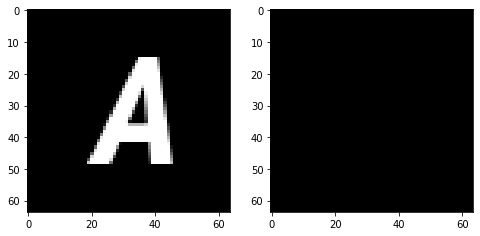

epoch: 33 iter: 100
epoch: 33 iter: 101
epoch: 33 iter: 102
epoch: 33 iter: 103
epoch: 33 iter: 104
epoch: 33 iter: 105
epoch: 33 iter: 106
epoch: 33 iter: 107
epoch: 33 iter: 108
epoch: 33 iter: 109
epoch: 33 iter: 110
epoch: 33 iter: 111
epoch: 33 iter: 112
epoch: 33 iter: 113
epoch: 33 iter: 114
epoch: 33 iter: 115
epoch: 33 iter: 116
epoch: 33 iter: 117
epoch: 33 iter: 118
epoch: 33 iter: 119
epoch: 33 iter: 120
epoch: 33 iter: 121
epoch: 33 iter: 122
epoch: 33 iter: 123
epoch: 33 iter: 124
epoch: 33 iter: 125
epoch: 33 iter: 126
epoch: 33 iter: 127
epoch: 33 iter: 128
epoch: 33 iter: 129
epoch: 33 iter: 130
epoch: 33 iter: 131
epoch: 33 iter: 132
epoch: 33 iter: 133
epoch: 33 iter: 134
epoch: 33 iter: 135
epoch: 33 iter: 136
epoch: 33 iter: 137
epoch: 33 iter: 138
epoch: 33 iter: 139
epoch: 33 iter: 140
epoch: 33 iter: 141
epoch: 33 iter: 142
epoch: 33 iter: 143
epoch: 33 iter: 144
epoch: 33 iter: 145
epoch: 33 iter: 146
epoch: 33 iter: 147
epoch: 33 iter: 148
epoch: 33 iter: 149


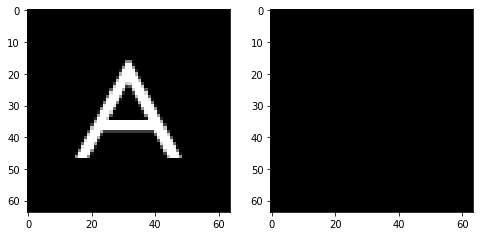

epoch: 34 iter: 100
epoch: 34 iter: 101
epoch: 34 iter: 102
epoch: 34 iter: 103
epoch: 34 iter: 104
epoch: 34 iter: 105
epoch: 34 iter: 106
epoch: 34 iter: 107
epoch: 34 iter: 108
epoch: 34 iter: 109
epoch: 34 iter: 110
epoch: 34 iter: 111
epoch: 34 iter: 112
epoch: 34 iter: 113
epoch: 34 iter: 114
epoch: 34 iter: 115
epoch: 34 iter: 116
epoch: 34 iter: 117
epoch: 34 iter: 118
epoch: 34 iter: 119
epoch: 34 iter: 120
epoch: 34 iter: 121
epoch: 34 iter: 122
epoch: 34 iter: 123
epoch: 34 iter: 124
epoch: 34 iter: 125
epoch: 34 iter: 126
epoch: 34 iter: 127
epoch: 34 iter: 128
epoch: 34 iter: 129
epoch: 34 iter: 130
epoch: 34 iter: 131
epoch: 34 iter: 132
epoch: 34 iter: 133
epoch: 34 iter: 134
epoch: 34 iter: 135
epoch: 34 iter: 136
epoch: 34 iter: 137
epoch: 34 iter: 138
epoch: 34 iter: 139
epoch: 34 iter: 140
epoch: 34 iter: 141
epoch: 34 iter: 142
epoch: 34 iter: 143
epoch: 34 iter: 144
epoch: 34 iter: 145
epoch: 34 iter: 146
epoch: 34 iter: 147
epoch: 34 iter: 148
epoch: 34 iter: 149


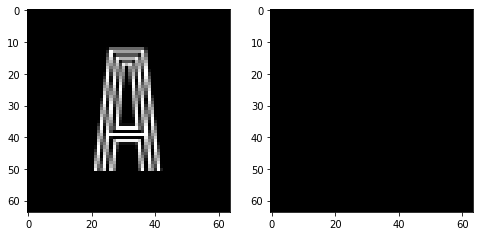

epoch: 35 iter: 100
epoch: 35 iter: 101
epoch: 35 iter: 102
epoch: 35 iter: 103
epoch: 35 iter: 104
epoch: 35 iter: 105
epoch: 35 iter: 106
epoch: 35 iter: 107
epoch: 35 iter: 108
epoch: 35 iter: 109
epoch: 35 iter: 110
epoch: 35 iter: 111
epoch: 35 iter: 112
epoch: 35 iter: 113
epoch: 35 iter: 114
epoch: 35 iter: 115
epoch: 35 iter: 116
epoch: 35 iter: 117
epoch: 35 iter: 118
epoch: 35 iter: 119
epoch: 35 iter: 120
epoch: 35 iter: 121
epoch: 35 iter: 122
epoch: 35 iter: 123
epoch: 35 iter: 124
epoch: 35 iter: 125
epoch: 35 iter: 126
epoch: 35 iter: 127
epoch: 35 iter: 128
epoch: 35 iter: 129
epoch: 35 iter: 130
epoch: 35 iter: 131
epoch: 35 iter: 132
epoch: 35 iter: 133
epoch: 35 iter: 134
epoch: 35 iter: 135
epoch: 35 iter: 136
epoch: 35 iter: 137
epoch: 35 iter: 138
epoch: 35 iter: 139
epoch: 35 iter: 140
epoch: 35 iter: 141
epoch: 35 iter: 142
epoch: 35 iter: 143
epoch: 35 iter: 144
epoch: 35 iter: 145
epoch: 35 iter: 146
epoch: 35 iter: 147
epoch: 35 iter: 148
epoch: 35 iter: 149


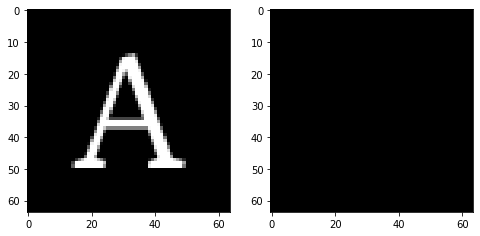

epoch: 36 iter: 100
epoch: 36 iter: 101
epoch: 36 iter: 102
epoch: 36 iter: 103
epoch: 36 iter: 104
epoch: 36 iter: 105
epoch: 36 iter: 106
epoch: 36 iter: 107
epoch: 36 iter: 108
epoch: 36 iter: 109
epoch: 36 iter: 110
epoch: 36 iter: 111
epoch: 36 iter: 112
epoch: 36 iter: 113
epoch: 36 iter: 114
epoch: 36 iter: 115
epoch: 36 iter: 116
epoch: 36 iter: 117
epoch: 36 iter: 118
epoch: 36 iter: 119
epoch: 36 iter: 120
epoch: 36 iter: 121
epoch: 36 iter: 122
epoch: 36 iter: 123
epoch: 36 iter: 124
epoch: 36 iter: 125
epoch: 36 iter: 126
epoch: 36 iter: 127
epoch: 36 iter: 128
epoch: 36 iter: 129
epoch: 36 iter: 130
epoch: 36 iter: 131
epoch: 36 iter: 132
epoch: 36 iter: 133
epoch: 36 iter: 134
epoch: 36 iter: 135
epoch: 36 iter: 136
epoch: 36 iter: 137
epoch: 36 iter: 138
epoch: 36 iter: 139
epoch: 36 iter: 140
epoch: 36 iter: 141
epoch: 36 iter: 142
epoch: 36 iter: 143
epoch: 36 iter: 144
epoch: 36 iter: 145
epoch: 36 iter: 146
epoch: 36 iter: 147
epoch: 36 iter: 148
epoch: 36 iter: 149


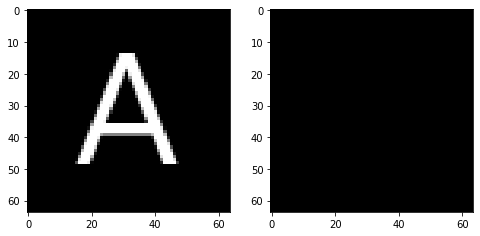

epoch: 37 iter: 100
epoch: 37 iter: 101
epoch: 37 iter: 102
epoch: 37 iter: 103
epoch: 37 iter: 104
epoch: 37 iter: 105
epoch: 37 iter: 106
epoch: 37 iter: 107
epoch: 37 iter: 108
epoch: 37 iter: 109
epoch: 37 iter: 110
epoch: 37 iter: 111
epoch: 37 iter: 112
epoch: 37 iter: 113
epoch: 37 iter: 114
epoch: 37 iter: 115
epoch: 37 iter: 116
epoch: 37 iter: 117
epoch: 37 iter: 118
epoch: 37 iter: 119
epoch: 37 iter: 120
epoch: 37 iter: 121
epoch: 37 iter: 122
epoch: 37 iter: 123
epoch: 37 iter: 124
epoch: 37 iter: 125
epoch: 37 iter: 126
epoch: 37 iter: 127
epoch: 37 iter: 128
epoch: 37 iter: 129
epoch: 37 iter: 130
epoch: 37 iter: 131
epoch: 37 iter: 132
epoch: 37 iter: 133
epoch: 37 iter: 134
epoch: 37 iter: 135
epoch: 37 iter: 136
epoch: 37 iter: 137
epoch: 37 iter: 138
epoch: 37 iter: 139
epoch: 37 iter: 140
epoch: 37 iter: 141
epoch: 37 iter: 142
epoch: 37 iter: 143
epoch: 37 iter: 144
epoch: 37 iter: 145
epoch: 37 iter: 146
epoch: 37 iter: 147
epoch: 37 iter: 148
epoch: 37 iter: 149


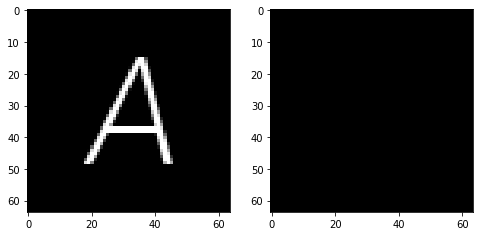

epoch: 38 iter: 100
epoch: 38 iter: 101
epoch: 38 iter: 102
epoch: 38 iter: 103
epoch: 38 iter: 104
epoch: 38 iter: 105
epoch: 38 iter: 106
epoch: 38 iter: 107
epoch: 38 iter: 108
epoch: 38 iter: 109
epoch: 38 iter: 110
epoch: 38 iter: 111
epoch: 38 iter: 112
epoch: 38 iter: 113
epoch: 38 iter: 114
epoch: 38 iter: 115
epoch: 38 iter: 116
epoch: 38 iter: 117
epoch: 38 iter: 118
epoch: 38 iter: 119
epoch: 38 iter: 120
epoch: 38 iter: 121
epoch: 38 iter: 122
epoch: 38 iter: 123
epoch: 38 iter: 124
epoch: 38 iter: 125
epoch: 38 iter: 126
epoch: 38 iter: 127
epoch: 38 iter: 128
epoch: 38 iter: 129
epoch: 38 iter: 130
epoch: 38 iter: 131
epoch: 38 iter: 132
epoch: 38 iter: 133
epoch: 38 iter: 134
epoch: 38 iter: 135
epoch: 38 iter: 136
epoch: 38 iter: 137
epoch: 38 iter: 138
epoch: 38 iter: 139
epoch: 38 iter: 140
epoch: 38 iter: 141
epoch: 38 iter: 142
epoch: 38 iter: 143
epoch: 38 iter: 144
epoch: 38 iter: 145
epoch: 38 iter: 146
epoch: 38 iter: 147
epoch: 38 iter: 148
epoch: 38 iter: 149


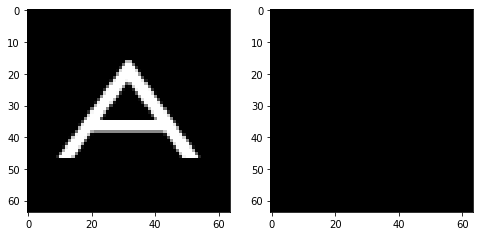

epoch: 39 iter: 100
epoch: 39 iter: 101
epoch: 39 iter: 102
epoch: 39 iter: 103
epoch: 39 iter: 104
epoch: 39 iter: 105
epoch: 39 iter: 106
epoch: 39 iter: 107
epoch: 39 iter: 108
epoch: 39 iter: 109
epoch: 39 iter: 110
epoch: 39 iter: 111
epoch: 39 iter: 112
epoch: 39 iter: 113
epoch: 39 iter: 114
epoch: 39 iter: 115
epoch: 39 iter: 116
epoch: 39 iter: 117
epoch: 39 iter: 118
epoch: 39 iter: 119
epoch: 39 iter: 120
epoch: 39 iter: 121
epoch: 39 iter: 122
epoch: 39 iter: 123
epoch: 39 iter: 124
epoch: 39 iter: 125
epoch: 39 iter: 126
epoch: 39 iter: 127
epoch: 39 iter: 128
epoch: 39 iter: 129
epoch: 39 iter: 130
epoch: 39 iter: 131
epoch: 39 iter: 132
epoch: 39 iter: 133
epoch: 39 iter: 134
epoch: 39 iter: 135
epoch: 39 iter: 136
epoch: 39 iter: 137
epoch: 39 iter: 138
epoch: 39 iter: 139
epoch: 39 iter: 140
epoch: 39 iter: 141
epoch: 39 iter: 142
epoch: 39 iter: 143
epoch: 39 iter: 144
epoch: 39 iter: 145
epoch: 39 iter: 146
epoch: 39 iter: 147
epoch: 39 iter: 148
epoch: 39 iter: 149


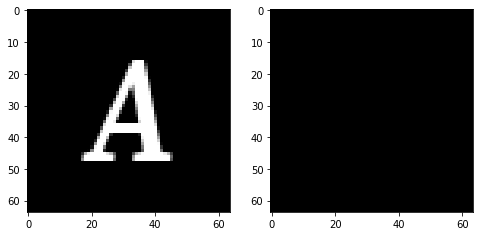

epoch: 40 iter: 100
epoch: 40 iter: 101
epoch: 40 iter: 102
epoch: 40 iter: 103
epoch: 40 iter: 104
epoch: 40 iter: 105
epoch: 40 iter: 106
epoch: 40 iter: 107
epoch: 40 iter: 108
epoch: 40 iter: 109
epoch: 40 iter: 110
epoch: 40 iter: 111
epoch: 40 iter: 112
epoch: 40 iter: 113
epoch: 40 iter: 114
epoch: 40 iter: 115
epoch: 40 iter: 116
epoch: 40 iter: 117
epoch: 40 iter: 118
epoch: 40 iter: 119
epoch: 40 iter: 120
epoch: 40 iter: 121
epoch: 40 iter: 122
epoch: 40 iter: 123
epoch: 40 iter: 124
epoch: 40 iter: 125
epoch: 40 iter: 126
epoch: 40 iter: 127
epoch: 40 iter: 128
epoch: 40 iter: 129
epoch: 40 iter: 130
epoch: 40 iter: 131
epoch: 40 iter: 132
epoch: 40 iter: 133
epoch: 40 iter: 134
epoch: 40 iter: 135
epoch: 40 iter: 136
epoch: 40 iter: 137
epoch: 40 iter: 138
epoch: 40 iter: 139
epoch: 40 iter: 140
epoch: 40 iter: 141
epoch: 40 iter: 142
epoch: 40 iter: 143
epoch: 40 iter: 144
epoch: 40 iter: 145
epoch: 40 iter: 146
epoch: 40 iter: 147
epoch: 40 iter: 148
epoch: 40 iter: 149


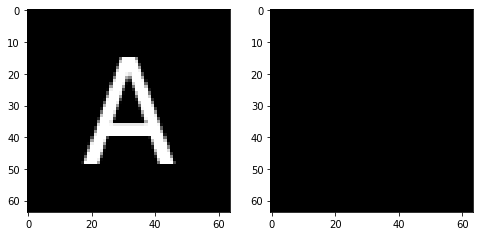

epoch: 41 iter: 100
epoch: 41 iter: 101
epoch: 41 iter: 102
epoch: 41 iter: 103
epoch: 41 iter: 104
epoch: 41 iter: 105
epoch: 41 iter: 106
epoch: 41 iter: 107
epoch: 41 iter: 108
epoch: 41 iter: 109
epoch: 41 iter: 110
epoch: 41 iter: 111
epoch: 41 iter: 112
epoch: 41 iter: 113
epoch: 41 iter: 114
epoch: 41 iter: 115
epoch: 41 iter: 116
epoch: 41 iter: 117
epoch: 41 iter: 118
epoch: 41 iter: 119
epoch: 41 iter: 120
epoch: 41 iter: 121
epoch: 41 iter: 122
epoch: 41 iter: 123
epoch: 41 iter: 124
epoch: 41 iter: 125
epoch: 41 iter: 126
epoch: 41 iter: 127
epoch: 41 iter: 128
epoch: 41 iter: 129
epoch: 41 iter: 130
epoch: 41 iter: 131
epoch: 41 iter: 132
epoch: 41 iter: 133
epoch: 41 iter: 134
epoch: 41 iter: 135
epoch: 41 iter: 136
epoch: 41 iter: 137
epoch: 41 iter: 138
epoch: 41 iter: 139
epoch: 41 iter: 140
epoch: 41 iter: 141
epoch: 41 iter: 142
epoch: 41 iter: 143
epoch: 41 iter: 144
epoch: 41 iter: 145
epoch: 41 iter: 146
epoch: 41 iter: 147
epoch: 41 iter: 148
epoch: 41 iter: 149


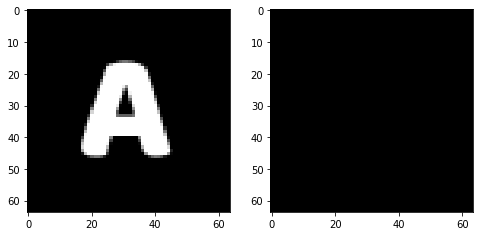

epoch: 42 iter: 100
epoch: 42 iter: 101
epoch: 42 iter: 102
epoch: 42 iter: 103
epoch: 42 iter: 104
epoch: 42 iter: 105
epoch: 42 iter: 106
epoch: 42 iter: 107
epoch: 42 iter: 108
epoch: 42 iter: 109
epoch: 42 iter: 110
epoch: 42 iter: 111
epoch: 42 iter: 112
epoch: 42 iter: 113
epoch: 42 iter: 114
epoch: 42 iter: 115
epoch: 42 iter: 116
epoch: 42 iter: 117
epoch: 42 iter: 118
epoch: 42 iter: 119
epoch: 42 iter: 120
epoch: 42 iter: 121
epoch: 42 iter: 122
epoch: 42 iter: 123
epoch: 42 iter: 124
epoch: 42 iter: 125
epoch: 42 iter: 126
epoch: 42 iter: 127
epoch: 42 iter: 128
epoch: 42 iter: 129
epoch: 42 iter: 130
epoch: 42 iter: 131
epoch: 42 iter: 132
epoch: 42 iter: 133
epoch: 42 iter: 134
epoch: 42 iter: 135
epoch: 42 iter: 136
epoch: 42 iter: 137
epoch: 42 iter: 138
epoch: 42 iter: 139
epoch: 42 iter: 140
epoch: 42 iter: 141
epoch: 42 iter: 142
epoch: 42 iter: 143
epoch: 42 iter: 144
epoch: 42 iter: 145
epoch: 42 iter: 146
epoch: 42 iter: 147
epoch: 42 iter: 148
epoch: 42 iter: 149


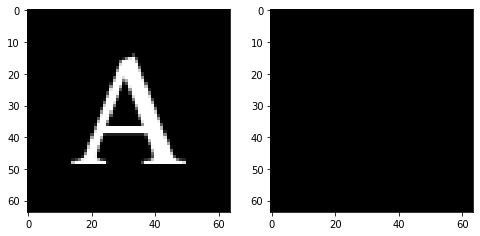

epoch: 43 iter: 100
epoch: 43 iter: 101
epoch: 43 iter: 102
epoch: 43 iter: 103
epoch: 43 iter: 104
epoch: 43 iter: 105
epoch: 43 iter: 106
epoch: 43 iter: 107
epoch: 43 iter: 108
epoch: 43 iter: 109
epoch: 43 iter: 110
epoch: 43 iter: 111
epoch: 43 iter: 112
epoch: 43 iter: 113
epoch: 43 iter: 114
epoch: 43 iter: 115
epoch: 43 iter: 116
epoch: 43 iter: 117
epoch: 43 iter: 118
epoch: 43 iter: 119
epoch: 43 iter: 120
epoch: 43 iter: 121
epoch: 43 iter: 122
epoch: 43 iter: 123
epoch: 43 iter: 124
epoch: 43 iter: 125
epoch: 43 iter: 126
epoch: 43 iter: 127
epoch: 43 iter: 128
epoch: 43 iter: 129
epoch: 43 iter: 130
epoch: 43 iter: 131
epoch: 43 iter: 132
epoch: 43 iter: 133
epoch: 43 iter: 134
epoch: 43 iter: 135
epoch: 43 iter: 136
epoch: 43 iter: 137
epoch: 43 iter: 138
epoch: 43 iter: 139
epoch: 43 iter: 140
epoch: 43 iter: 141
epoch: 43 iter: 142
epoch: 43 iter: 143
epoch: 43 iter: 144
epoch: 43 iter: 145
epoch: 43 iter: 146
epoch: 43 iter: 147
epoch: 43 iter: 148
epoch: 43 iter: 149


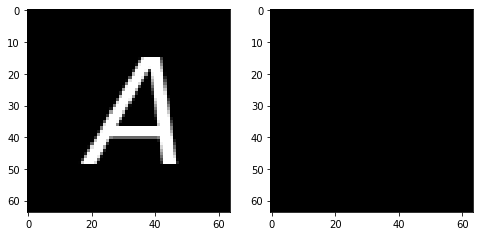

epoch: 44 iter: 100
epoch: 44 iter: 101
epoch: 44 iter: 102
epoch: 44 iter: 103
epoch: 44 iter: 104
epoch: 44 iter: 105
epoch: 44 iter: 106
epoch: 44 iter: 107
epoch: 44 iter: 108
epoch: 44 iter: 109
epoch: 44 iter: 110
epoch: 44 iter: 111
epoch: 44 iter: 112
epoch: 44 iter: 113
epoch: 44 iter: 114
epoch: 44 iter: 115
epoch: 44 iter: 116
epoch: 44 iter: 117
epoch: 44 iter: 118
epoch: 44 iter: 119
epoch: 44 iter: 120
epoch: 44 iter: 121
epoch: 44 iter: 122
epoch: 44 iter: 123
epoch: 44 iter: 124
epoch: 44 iter: 125
epoch: 44 iter: 126
epoch: 44 iter: 127
epoch: 44 iter: 128
epoch: 44 iter: 129
epoch: 44 iter: 130
epoch: 44 iter: 131
epoch: 44 iter: 132
epoch: 44 iter: 133
epoch: 44 iter: 134
epoch: 44 iter: 135
epoch: 44 iter: 136
epoch: 44 iter: 137
epoch: 44 iter: 138
epoch: 44 iter: 139
epoch: 44 iter: 140
epoch: 44 iter: 141
epoch: 44 iter: 142
epoch: 44 iter: 143
epoch: 44 iter: 144
epoch: 44 iter: 145
epoch: 44 iter: 146
epoch: 44 iter: 147
epoch: 44 iter: 148
epoch: 44 iter: 149


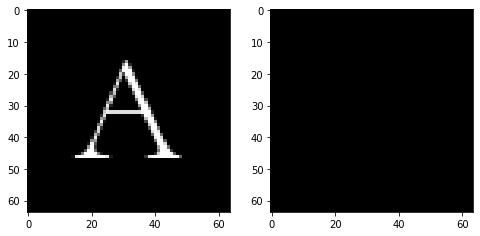

epoch: 45 iter: 100
epoch: 45 iter: 101
epoch: 45 iter: 102
epoch: 45 iter: 103
epoch: 45 iter: 104
epoch: 45 iter: 105
epoch: 45 iter: 106
epoch: 45 iter: 107
epoch: 45 iter: 108
epoch: 45 iter: 109
epoch: 45 iter: 110
epoch: 45 iter: 111
epoch: 45 iter: 112
epoch: 45 iter: 113
epoch: 45 iter: 114
epoch: 45 iter: 115
epoch: 45 iter: 116
epoch: 45 iter: 117
epoch: 45 iter: 118
epoch: 45 iter: 119
epoch: 45 iter: 120
epoch: 45 iter: 121
epoch: 45 iter: 122
epoch: 45 iter: 123
epoch: 45 iter: 124
epoch: 45 iter: 125
epoch: 45 iter: 126
epoch: 45 iter: 127
epoch: 45 iter: 128
epoch: 45 iter: 129
epoch: 45 iter: 130
epoch: 45 iter: 131
epoch: 45 iter: 132
epoch: 45 iter: 133
epoch: 45 iter: 134
epoch: 45 iter: 135
epoch: 45 iter: 136
epoch: 45 iter: 137
epoch: 45 iter: 138
epoch: 45 iter: 139
epoch: 45 iter: 140
epoch: 45 iter: 141
epoch: 45 iter: 142
epoch: 45 iter: 143
epoch: 45 iter: 144
epoch: 45 iter: 145
epoch: 45 iter: 146
epoch: 45 iter: 147
epoch: 45 iter: 148
epoch: 45 iter: 149


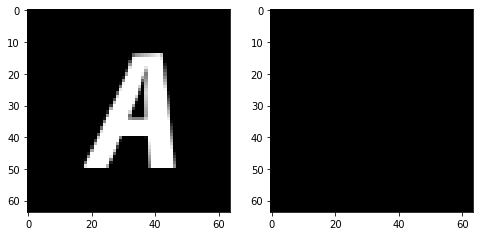

epoch: 46 iter: 100
epoch: 46 iter: 101
epoch: 46 iter: 102
epoch: 46 iter: 103
epoch: 46 iter: 104
epoch: 46 iter: 105
epoch: 46 iter: 106
epoch: 46 iter: 107
epoch: 46 iter: 108
epoch: 46 iter: 109
epoch: 46 iter: 110
epoch: 46 iter: 111
epoch: 46 iter: 112
epoch: 46 iter: 113
epoch: 46 iter: 114
epoch: 46 iter: 115
epoch: 46 iter: 116
epoch: 46 iter: 117
epoch: 46 iter: 118
epoch: 46 iter: 119
epoch: 46 iter: 120
epoch: 46 iter: 121
epoch: 46 iter: 122
epoch: 46 iter: 123
epoch: 46 iter: 124
epoch: 46 iter: 125
epoch: 46 iter: 126
epoch: 46 iter: 127
epoch: 46 iter: 128
epoch: 46 iter: 129
epoch: 46 iter: 130
epoch: 46 iter: 131
epoch: 46 iter: 132
epoch: 46 iter: 133
epoch: 46 iter: 134
epoch: 46 iter: 135
epoch: 46 iter: 136
epoch: 46 iter: 137
epoch: 46 iter: 138
epoch: 46 iter: 139
epoch: 46 iter: 140
epoch: 46 iter: 141
epoch: 46 iter: 142
epoch: 46 iter: 143
epoch: 46 iter: 144
epoch: 46 iter: 145
epoch: 46 iter: 146
epoch: 46 iter: 147
epoch: 46 iter: 148
epoch: 46 iter: 149


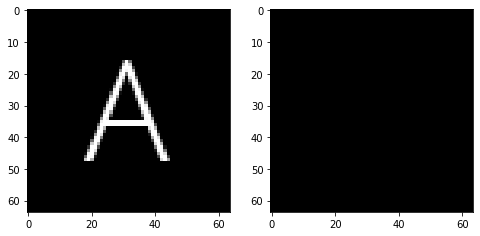

epoch: 47 iter: 100
epoch: 47 iter: 101
epoch: 47 iter: 102
epoch: 47 iter: 103
epoch: 47 iter: 104
epoch: 47 iter: 105
epoch: 47 iter: 106
epoch: 47 iter: 107
epoch: 47 iter: 108
epoch: 47 iter: 109
epoch: 47 iter: 110
epoch: 47 iter: 111
epoch: 47 iter: 112
epoch: 47 iter: 113
epoch: 47 iter: 114
epoch: 47 iter: 115
epoch: 47 iter: 116
epoch: 47 iter: 117
epoch: 47 iter: 118
epoch: 47 iter: 119
epoch: 47 iter: 120
epoch: 47 iter: 121
epoch: 47 iter: 122
epoch: 47 iter: 123
epoch: 47 iter: 124
epoch: 47 iter: 125
epoch: 47 iter: 126
epoch: 47 iter: 127
epoch: 47 iter: 128
epoch: 47 iter: 129
epoch: 47 iter: 130
epoch: 47 iter: 131
epoch: 47 iter: 132
epoch: 47 iter: 133
epoch: 47 iter: 134
epoch: 47 iter: 135
epoch: 47 iter: 136
epoch: 47 iter: 137
epoch: 47 iter: 138
epoch: 47 iter: 139
epoch: 47 iter: 140
epoch: 47 iter: 141
epoch: 47 iter: 142
epoch: 47 iter: 143
epoch: 47 iter: 144
epoch: 47 iter: 145
epoch: 47 iter: 146
epoch: 47 iter: 147
epoch: 47 iter: 148
epoch: 47 iter: 149


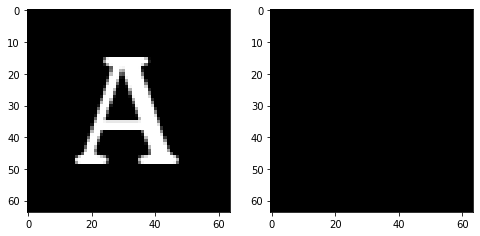

epoch: 48 iter: 100
epoch: 48 iter: 101
epoch: 48 iter: 102
epoch: 48 iter: 103
epoch: 48 iter: 104
epoch: 48 iter: 105
epoch: 48 iter: 106
epoch: 48 iter: 107
epoch: 48 iter: 108
epoch: 48 iter: 109
epoch: 48 iter: 110
epoch: 48 iter: 111
epoch: 48 iter: 112
epoch: 48 iter: 113
epoch: 48 iter: 114
epoch: 48 iter: 115
epoch: 48 iter: 116
epoch: 48 iter: 117
epoch: 48 iter: 118
epoch: 48 iter: 119
epoch: 48 iter: 120
epoch: 48 iter: 121
epoch: 48 iter: 122
epoch: 48 iter: 123
epoch: 48 iter: 124
epoch: 48 iter: 125
epoch: 48 iter: 126
epoch: 48 iter: 127
epoch: 48 iter: 128
epoch: 48 iter: 129
epoch: 48 iter: 130
epoch: 48 iter: 131
epoch: 48 iter: 132
epoch: 48 iter: 133
epoch: 48 iter: 134
epoch: 48 iter: 135
epoch: 48 iter: 136
epoch: 48 iter: 137
epoch: 48 iter: 138
epoch: 48 iter: 139
epoch: 48 iter: 140
epoch: 48 iter: 141
epoch: 48 iter: 142
epoch: 48 iter: 143
epoch: 48 iter: 144
epoch: 48 iter: 145
epoch: 48 iter: 146
epoch: 48 iter: 147
epoch: 48 iter: 148
epoch: 48 iter: 149


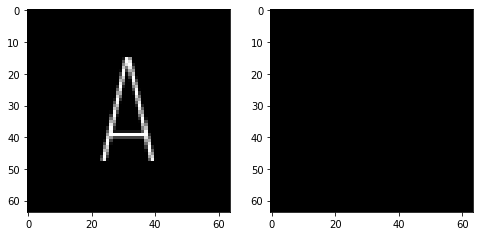

epoch: 49 iter: 100
epoch: 49 iter: 101
epoch: 49 iter: 102
epoch: 49 iter: 103
epoch: 49 iter: 104
epoch: 49 iter: 105
epoch: 49 iter: 106
epoch: 49 iter: 107
epoch: 49 iter: 108
epoch: 49 iter: 109
epoch: 49 iter: 110
epoch: 49 iter: 111
epoch: 49 iter: 112
epoch: 49 iter: 113
epoch: 49 iter: 114
epoch: 49 iter: 115
epoch: 49 iter: 116
epoch: 49 iter: 117
epoch: 49 iter: 118
epoch: 49 iter: 119
epoch: 49 iter: 120
epoch: 49 iter: 121
epoch: 49 iter: 122
epoch: 49 iter: 123
epoch: 49 iter: 124
epoch: 49 iter: 125
epoch: 49 iter: 126
epoch: 49 iter: 127
epoch: 49 iter: 128
epoch: 49 iter: 129
epoch: 49 iter: 130
epoch: 49 iter: 131
epoch: 49 iter: 132
epoch: 49 iter: 133
epoch: 49 iter: 134
epoch: 49 iter: 135
epoch: 49 iter: 136
epoch: 49 iter: 137
epoch: 49 iter: 138
epoch: 49 iter: 139
epoch: 49 iter: 140
epoch: 49 iter: 141
epoch: 49 iter: 142
epoch: 49 iter: 143
epoch: 49 iter: 144
epoch: 49 iter: 145
epoch: 49 iter: 146
epoch: 49 iter: 147
epoch: 49 iter: 148
epoch: 49 iter: 149


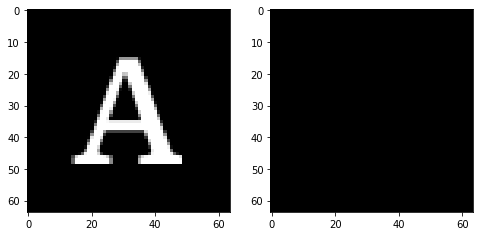

epoch: 50 iter: 100
epoch: 50 iter: 101
epoch: 50 iter: 102
epoch: 50 iter: 103
epoch: 50 iter: 104
epoch: 50 iter: 105
epoch: 50 iter: 106
epoch: 50 iter: 107
epoch: 50 iter: 108
epoch: 50 iter: 109
epoch: 50 iter: 110
epoch: 50 iter: 111
epoch: 50 iter: 112
epoch: 50 iter: 113
epoch: 50 iter: 114
epoch: 50 iter: 115
epoch: 50 iter: 116
epoch: 50 iter: 117
epoch: 50 iter: 118
epoch: 50 iter: 119
epoch: 50 iter: 120
epoch: 50 iter: 121
epoch: 50 iter: 122
epoch: 50 iter: 123
epoch: 50 iter: 124
epoch: 50 iter: 125
epoch: 50 iter: 126
epoch: 50 iter: 127
epoch: 50 iter: 128
epoch: 50 iter: 129
epoch: 50 iter: 130
epoch: 50 iter: 131
epoch: 50 iter: 132
epoch: 50 iter: 133
epoch: 50 iter: 134
epoch: 50 iter: 135
epoch: 50 iter: 136
epoch: 50 iter: 137
epoch: 50 iter: 138
epoch: 50 iter: 139
epoch: 50 iter: 140
epoch: 50 iter: 141
epoch: 50 iter: 142
epoch: 50 iter: 143
epoch: 50 iter: 144
epoch: 50 iter: 145
epoch: 50 iter: 146
epoch: 50 iter: 147
epoch: 50 iter: 148
epoch: 50 iter: 149


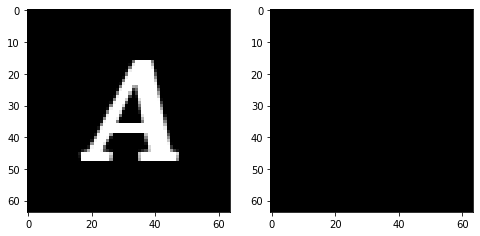

epoch: 51 iter: 100
epoch: 51 iter: 101
epoch: 51 iter: 102
epoch: 51 iter: 103
epoch: 51 iter: 104
epoch: 51 iter: 105
epoch: 51 iter: 106
epoch: 51 iter: 107
epoch: 51 iter: 108
epoch: 51 iter: 109
epoch: 51 iter: 110
epoch: 51 iter: 111
epoch: 51 iter: 112
epoch: 51 iter: 113
epoch: 51 iter: 114
epoch: 51 iter: 115
epoch: 51 iter: 116
epoch: 51 iter: 117
epoch: 51 iter: 118
epoch: 51 iter: 119
epoch: 51 iter: 120
epoch: 51 iter: 121
epoch: 51 iter: 122
epoch: 51 iter: 123
epoch: 51 iter: 124
epoch: 51 iter: 125
epoch: 51 iter: 126
epoch: 51 iter: 127
epoch: 51 iter: 128
epoch: 51 iter: 129
epoch: 51 iter: 130
epoch: 51 iter: 131
epoch: 51 iter: 132
epoch: 51 iter: 133
epoch: 51 iter: 134
epoch: 51 iter: 135
epoch: 51 iter: 136
epoch: 51 iter: 137
epoch: 51 iter: 138
epoch: 51 iter: 139
epoch: 51 iter: 140
epoch: 51 iter: 141
epoch: 51 iter: 142
epoch: 51 iter: 143
epoch: 51 iter: 144
epoch: 51 iter: 145
epoch: 51 iter: 146
epoch: 51 iter: 147
epoch: 51 iter: 148
epoch: 51 iter: 149


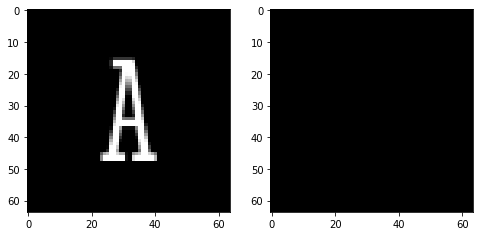

epoch: 52 iter: 100
epoch: 52 iter: 101
epoch: 52 iter: 102
epoch: 52 iter: 103
epoch: 52 iter: 104
epoch: 52 iter: 105
epoch: 52 iter: 106
epoch: 52 iter: 107
epoch: 52 iter: 108
epoch: 52 iter: 109
epoch: 52 iter: 110
epoch: 52 iter: 111
epoch: 52 iter: 112
epoch: 52 iter: 113
epoch: 52 iter: 114
epoch: 52 iter: 115
epoch: 52 iter: 116
epoch: 52 iter: 117
epoch: 52 iter: 118
epoch: 52 iter: 119
epoch: 52 iter: 120
epoch: 52 iter: 121
epoch: 52 iter: 122
epoch: 52 iter: 123
epoch: 52 iter: 124
epoch: 52 iter: 125
epoch: 52 iter: 126
epoch: 52 iter: 127
epoch: 52 iter: 128
epoch: 52 iter: 129
epoch: 52 iter: 130
epoch: 52 iter: 131
epoch: 52 iter: 132
epoch: 52 iter: 133
epoch: 52 iter: 134
epoch: 52 iter: 135
epoch: 52 iter: 136
epoch: 52 iter: 137
epoch: 52 iter: 138
epoch: 52 iter: 139
epoch: 52 iter: 140
epoch: 52 iter: 141
epoch: 52 iter: 142
epoch: 52 iter: 143
epoch: 52 iter: 144
epoch: 52 iter: 145
epoch: 52 iter: 146
epoch: 52 iter: 147
epoch: 52 iter: 148
epoch: 52 iter: 149


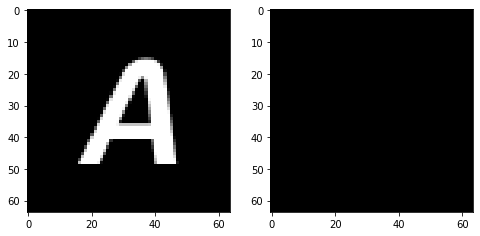

epoch: 53 iter: 100
epoch: 53 iter: 101
epoch: 53 iter: 102
epoch: 53 iter: 103
epoch: 53 iter: 104
epoch: 53 iter: 105
epoch: 53 iter: 106
epoch: 53 iter: 107
epoch: 53 iter: 108
epoch: 53 iter: 109
epoch: 53 iter: 110
epoch: 53 iter: 111
epoch: 53 iter: 112
epoch: 53 iter: 113
epoch: 53 iter: 114
epoch: 53 iter: 115
epoch: 53 iter: 116
epoch: 53 iter: 117
epoch: 53 iter: 118
epoch: 53 iter: 119
epoch: 53 iter: 120
epoch: 53 iter: 121
epoch: 53 iter: 122
epoch: 53 iter: 123
epoch: 53 iter: 124
epoch: 53 iter: 125
epoch: 53 iter: 126
epoch: 53 iter: 127
epoch: 53 iter: 128
epoch: 53 iter: 129
epoch: 53 iter: 130
epoch: 53 iter: 131
epoch: 53 iter: 132
epoch: 53 iter: 133
epoch: 53 iter: 134
epoch: 53 iter: 135
epoch: 53 iter: 136
epoch: 53 iter: 137
epoch: 53 iter: 138
epoch: 53 iter: 139
epoch: 53 iter: 140
epoch: 53 iter: 141
epoch: 53 iter: 142
epoch: 53 iter: 143
epoch: 53 iter: 144
epoch: 53 iter: 145
epoch: 53 iter: 146
epoch: 53 iter: 147
epoch: 53 iter: 148
epoch: 53 iter: 149


KeyboardInterrupt: 

In [60]:
main()

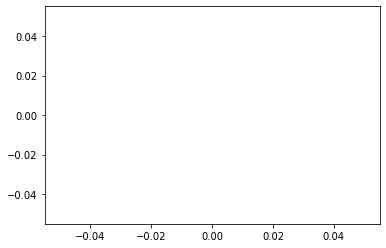

In [15]:
# plot losses
plt.plot(loss_ssim_list)
plt.show()

In [15]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

# model that we are evaluating
model_file = 'encdec.pt'

In [16]:
encdec = EncoderDecoder()
encdec.load_state_dict(torch.load(model_file))

# encdec = Finetune_EncDec(pretrained=encdec)
# encdec.load_state_dict(torch.load('encdec-finetune.pt'))

# for param in encdec.parameters():
#     print(param.data)

encdec.eval()

EncoderDecoder(
  (conv01): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv23): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(32, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv0same): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (relu): ReLU(inplace=True)
  (leakyrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (threshold): Threshold(threshold=0, value=0)
  (gaussian_filter): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=26, bias=False)
)

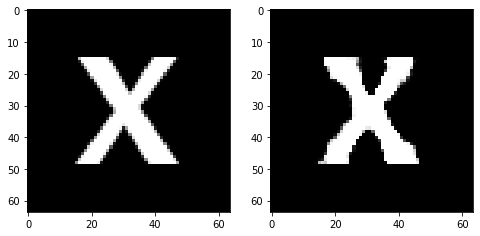

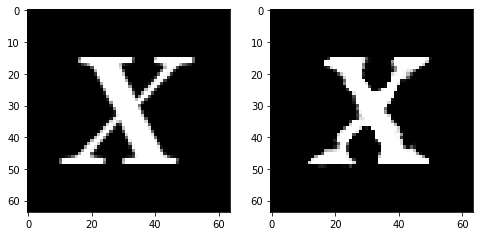

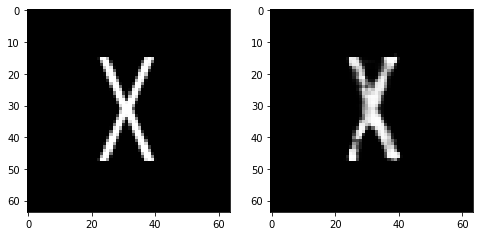

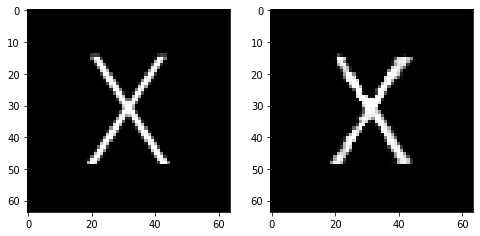

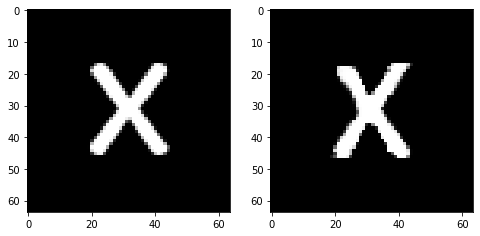

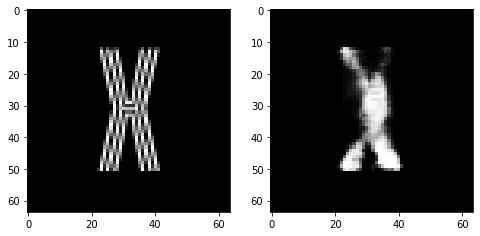

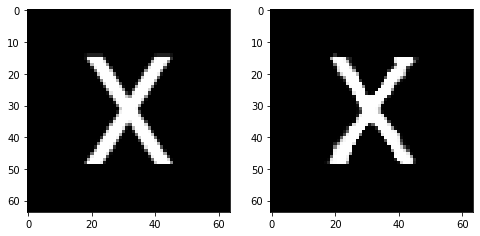

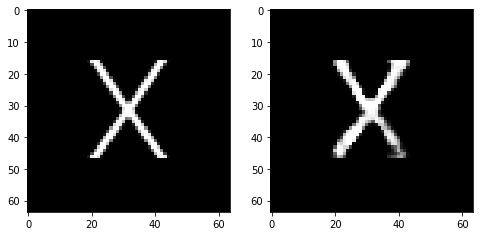

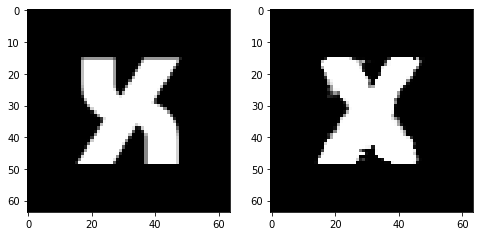

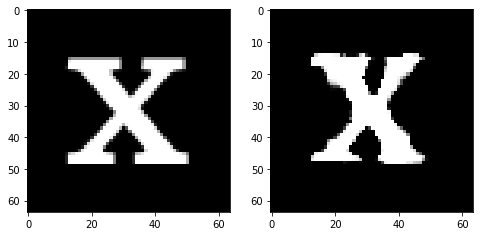

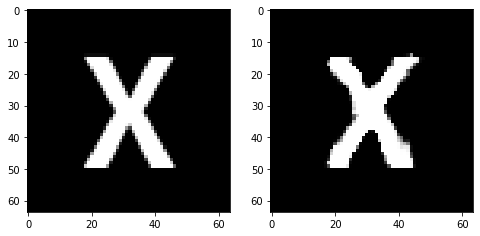

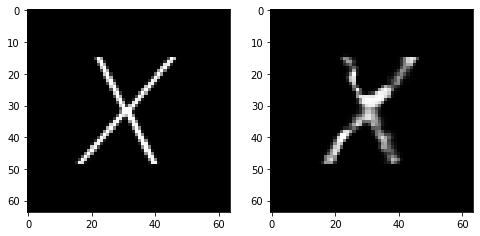

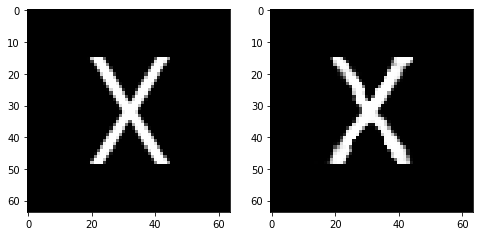

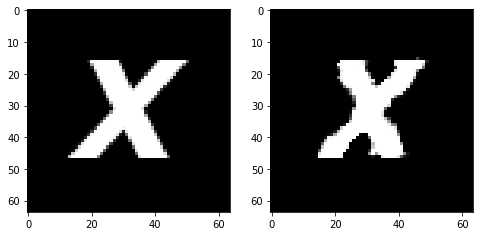

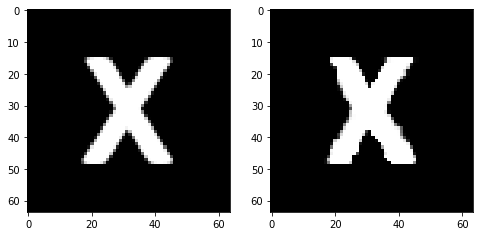

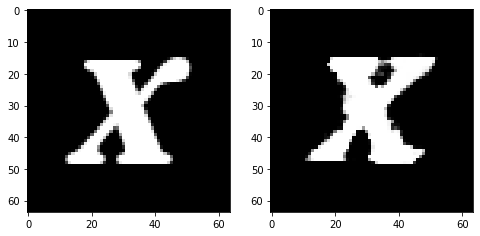

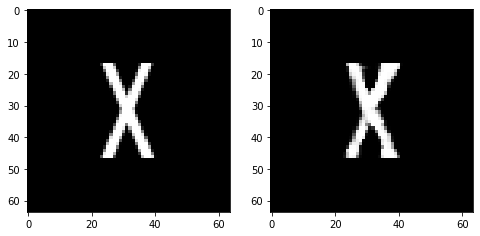

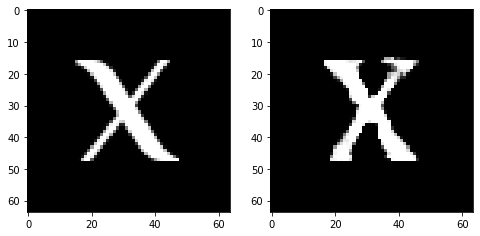

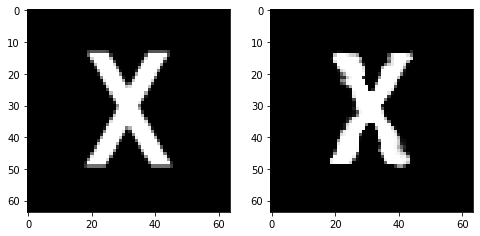

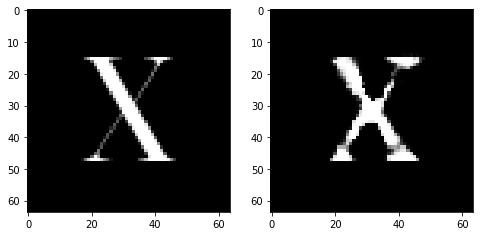

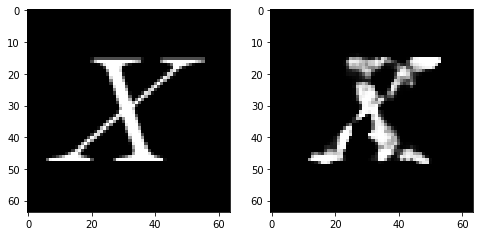

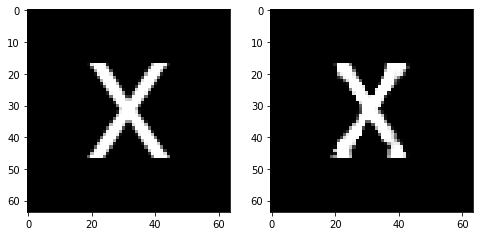

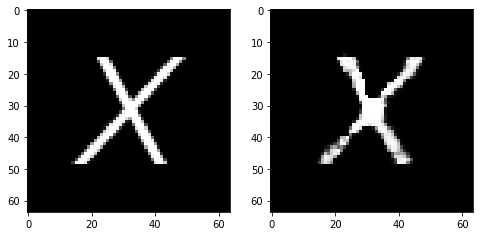

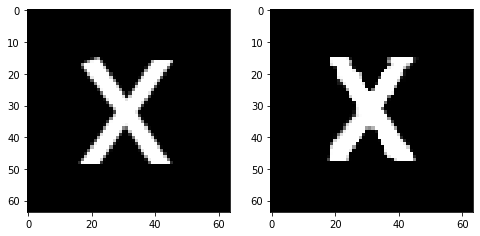

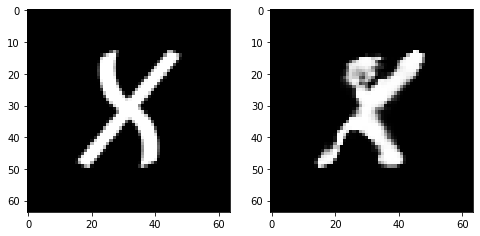

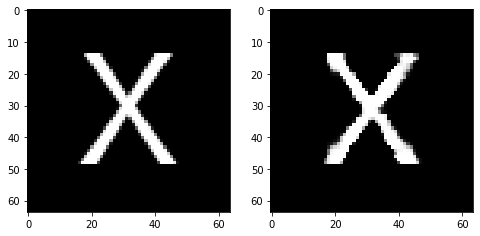

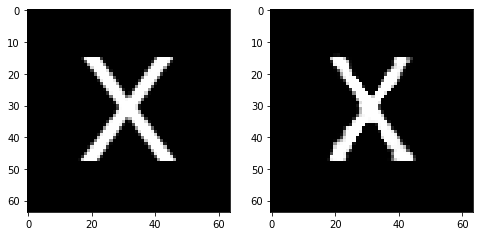

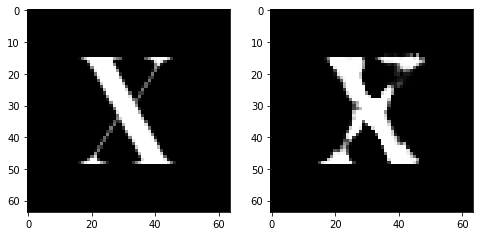

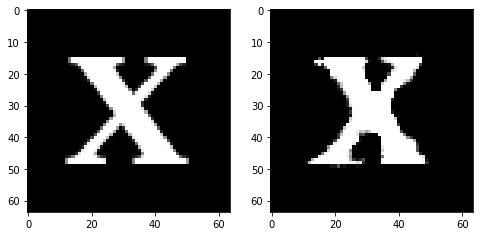

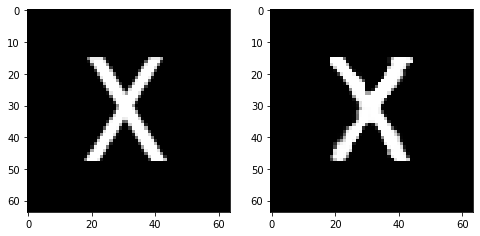

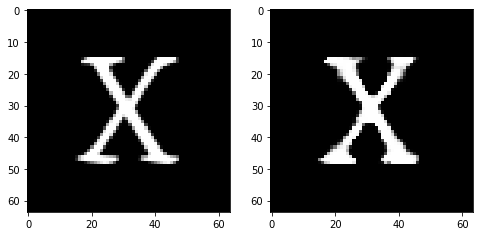

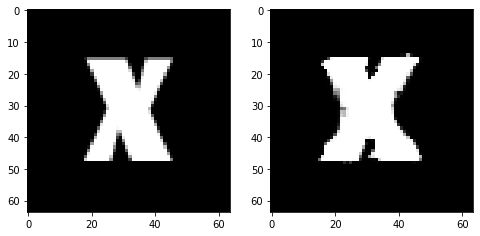

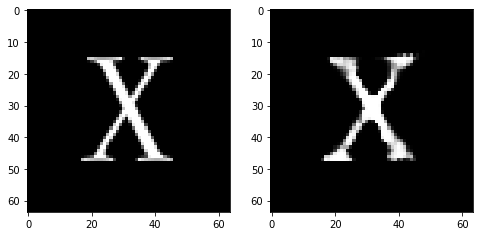

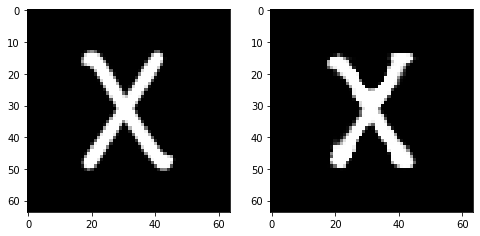

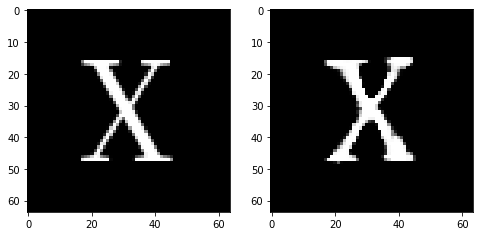

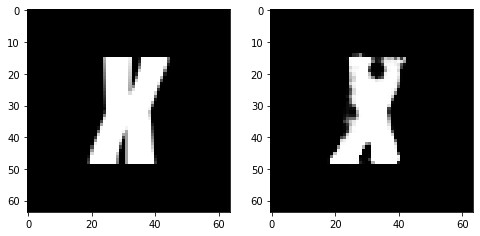

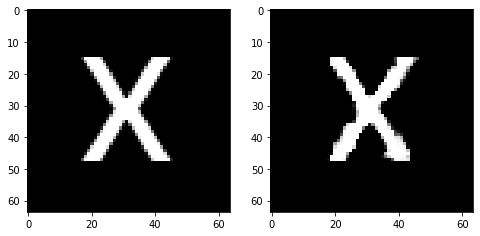

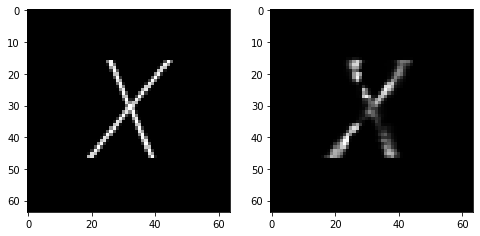

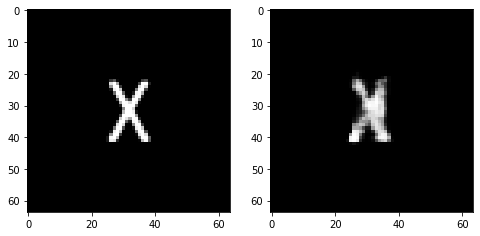

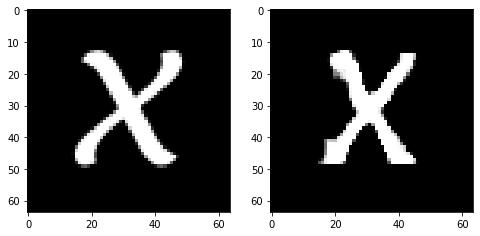

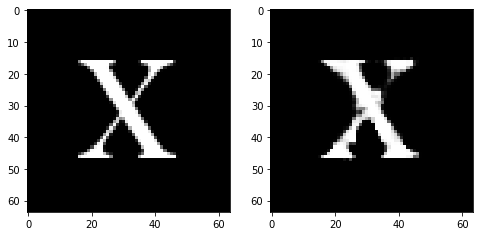

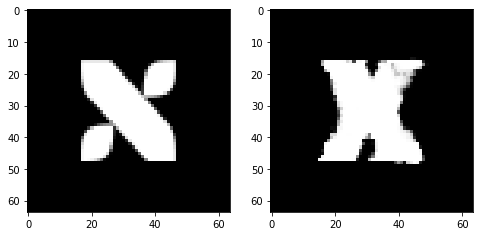

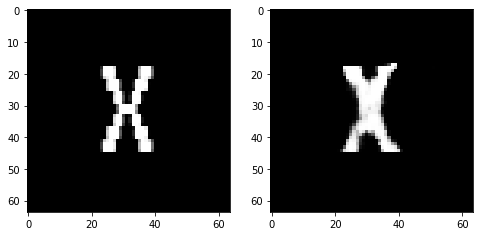

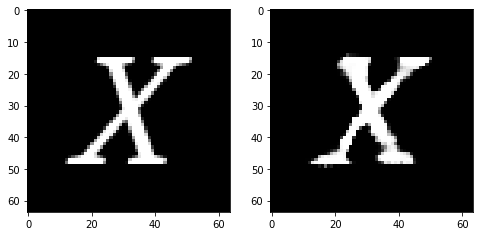

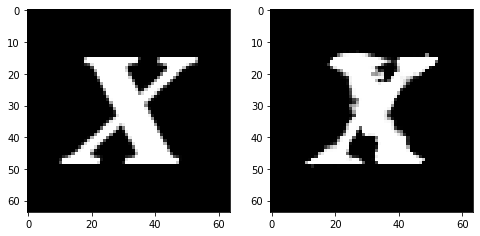

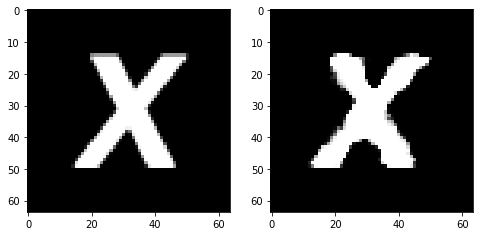

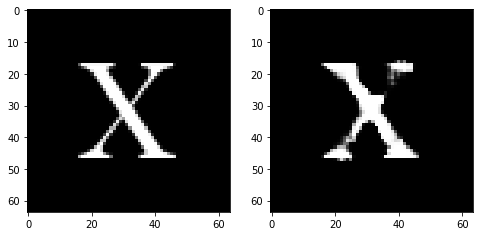

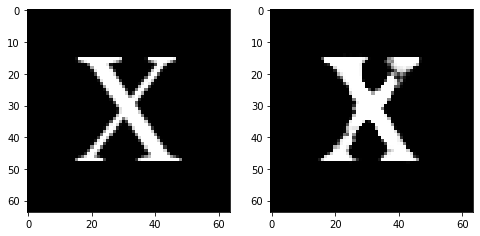

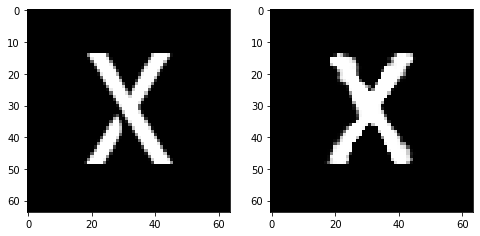

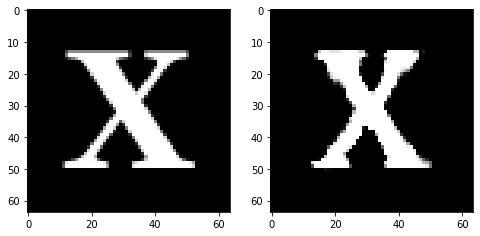

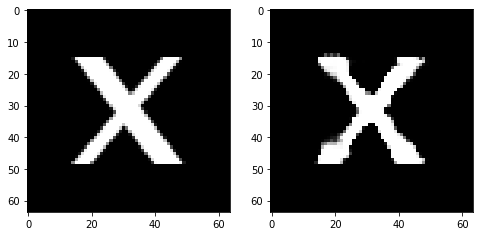

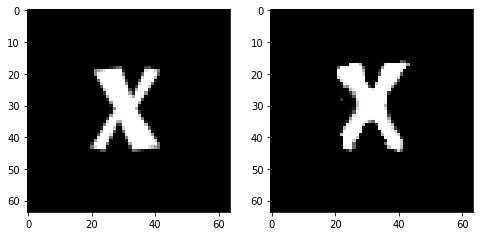

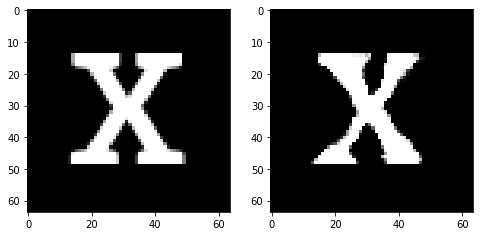

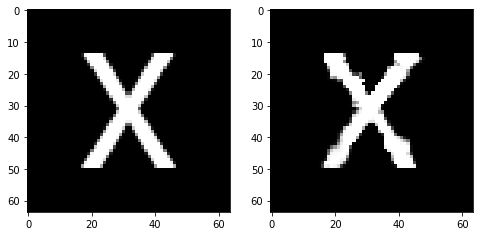

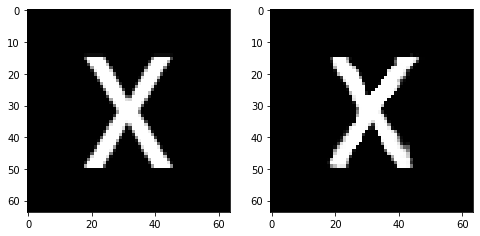

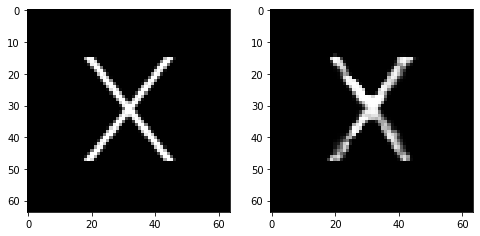

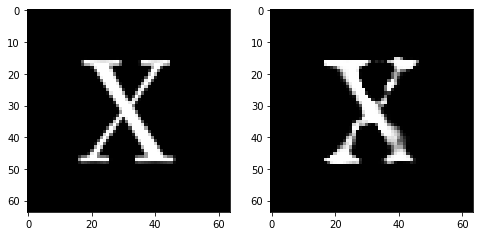

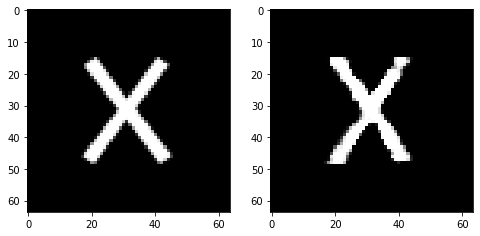

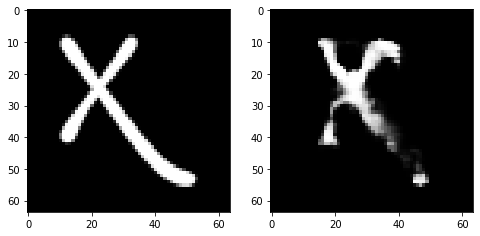

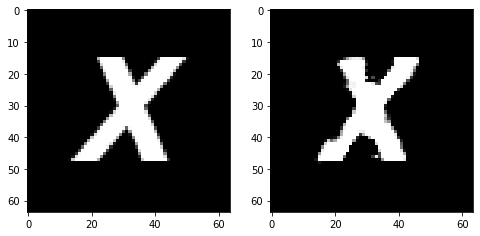

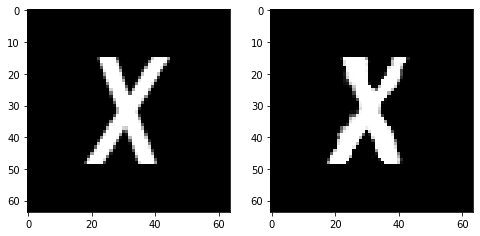

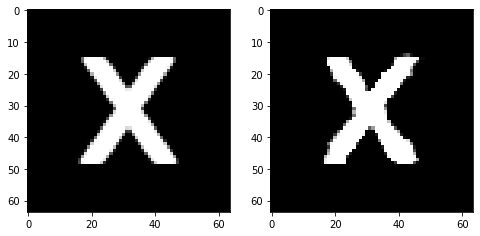

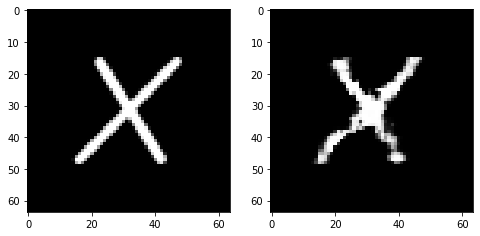

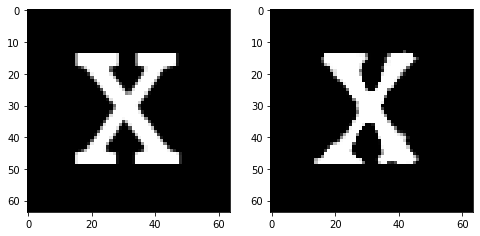

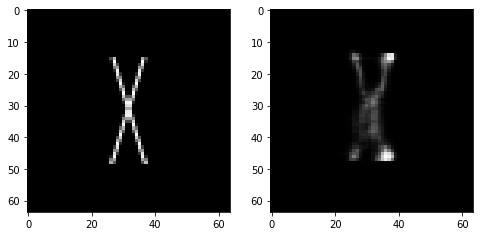

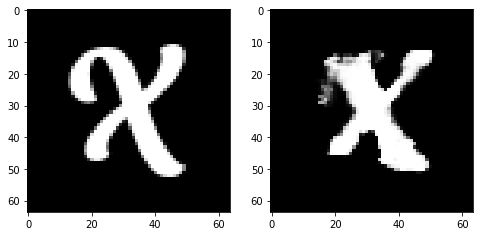

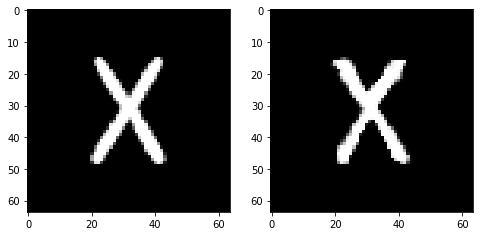

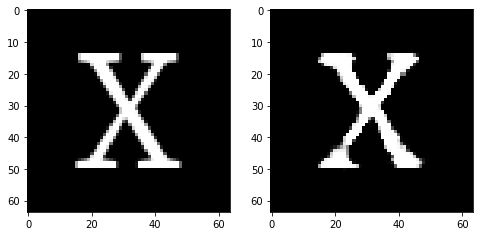

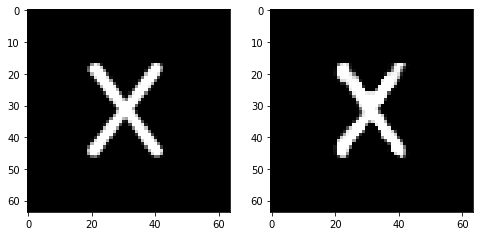

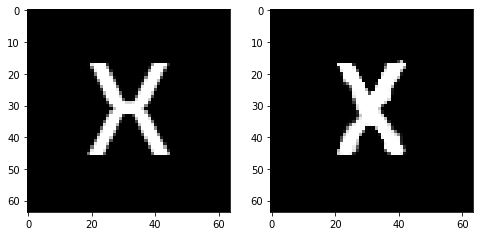

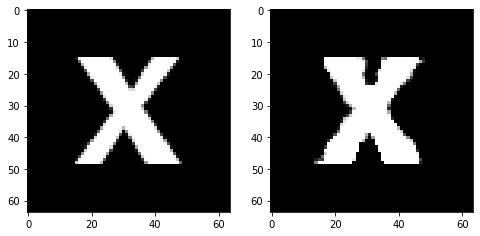

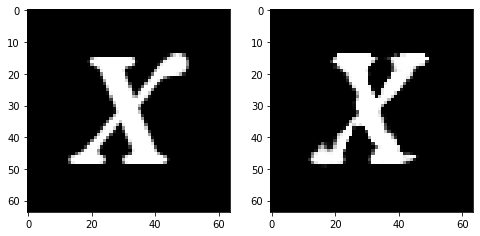

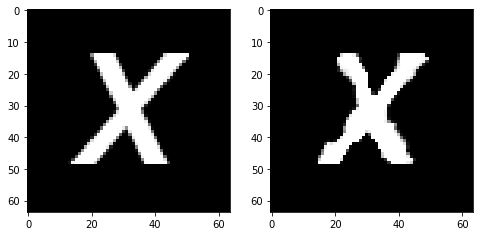

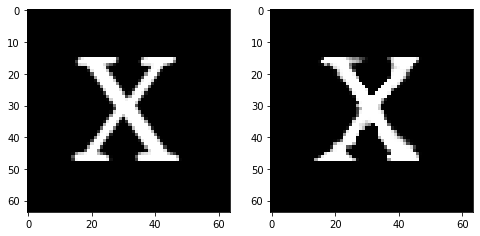

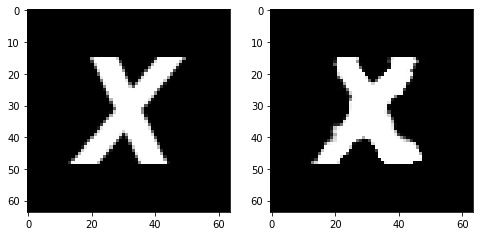

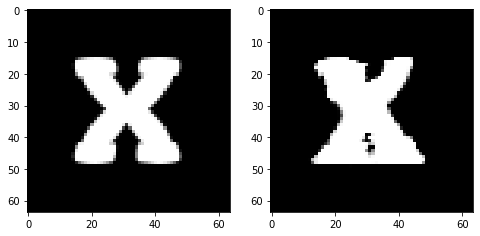

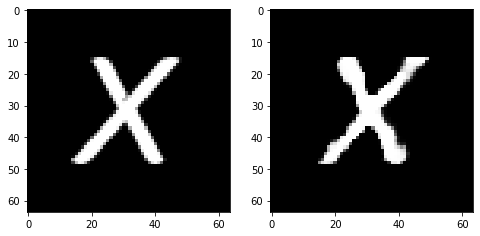

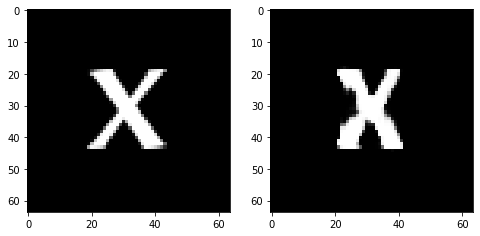

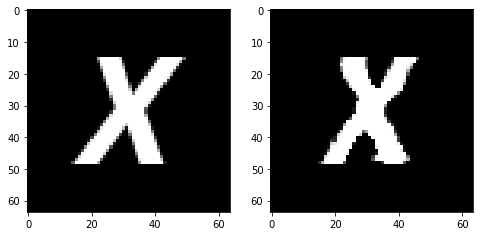

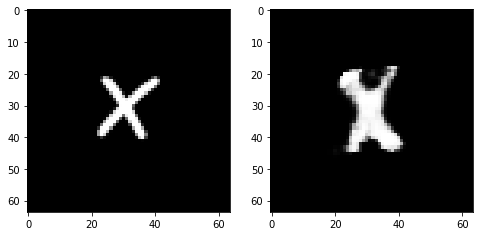

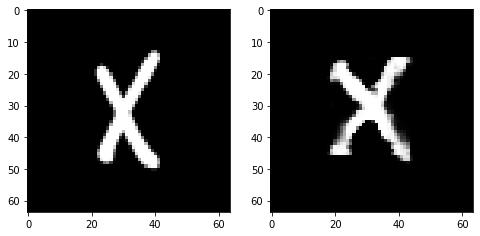

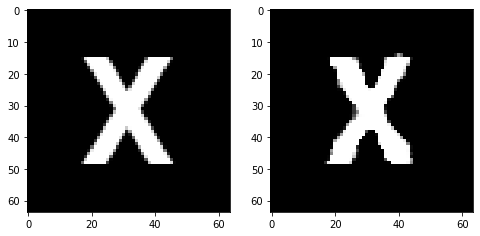

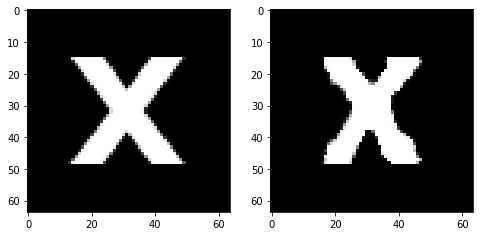

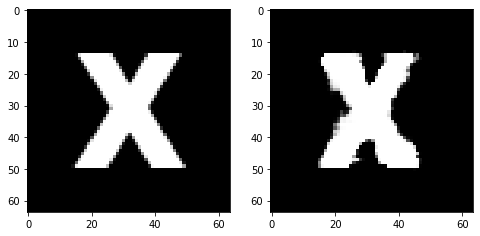

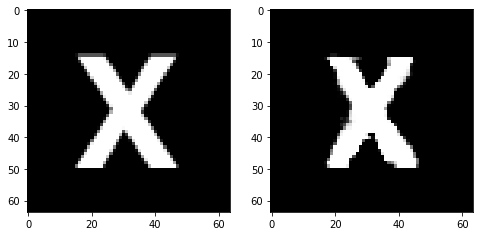

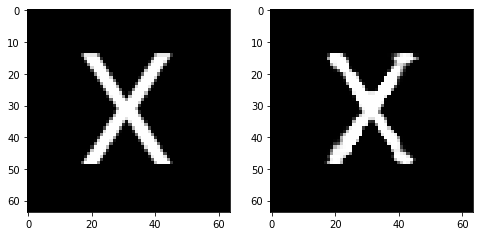

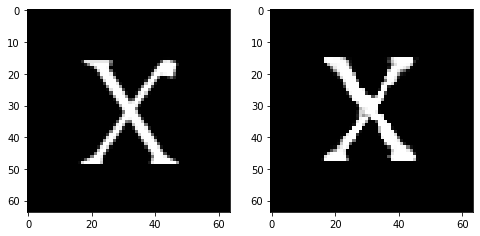

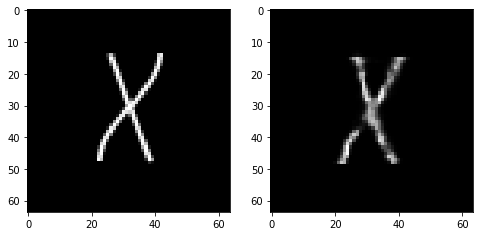

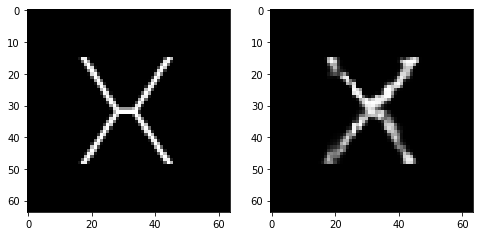

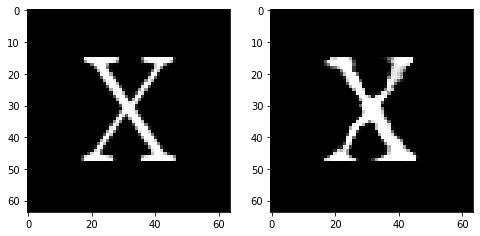

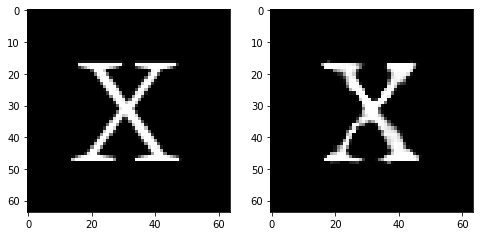

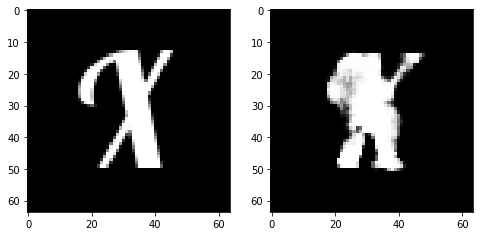

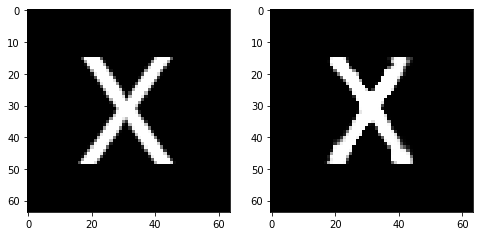

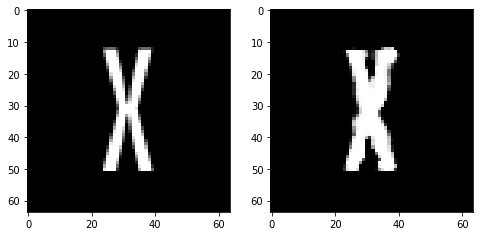

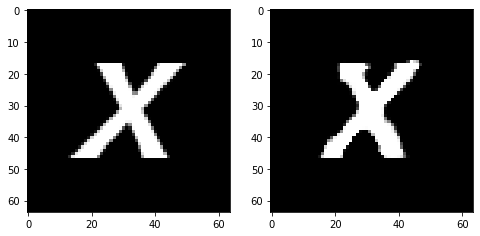

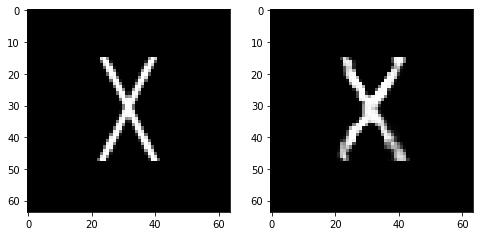

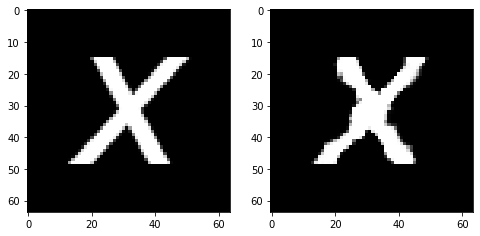

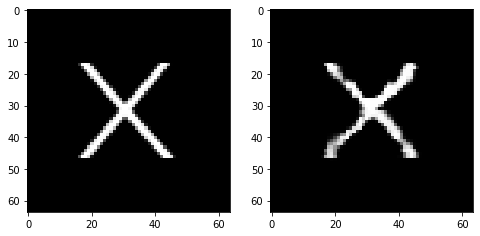

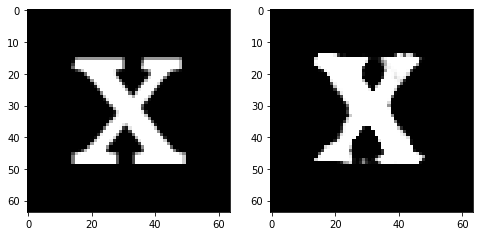

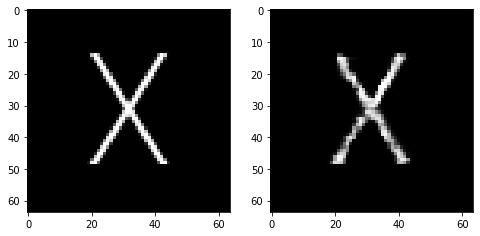

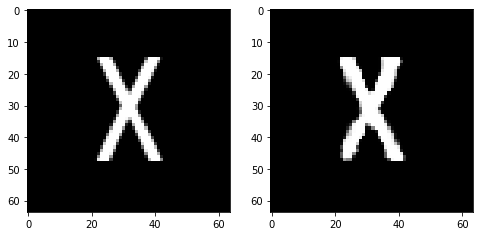

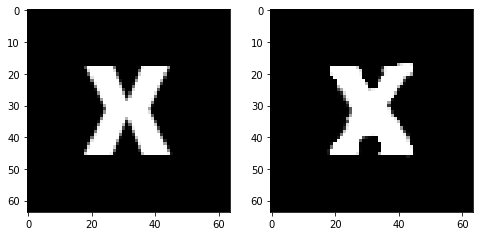

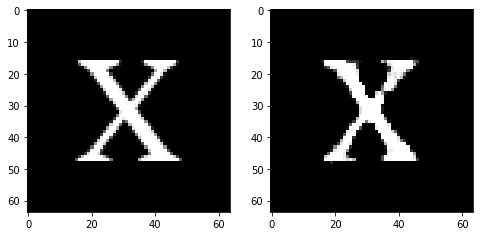

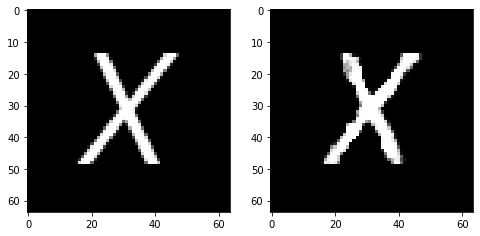

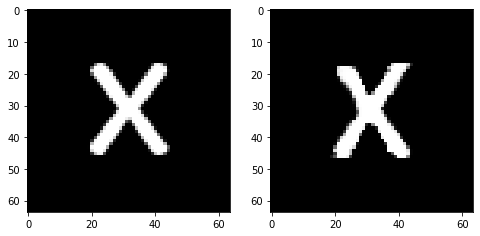

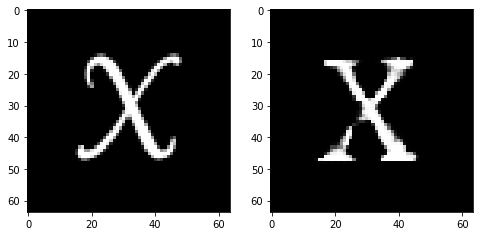

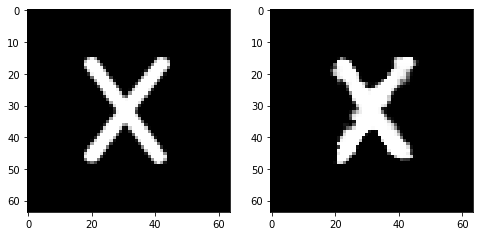

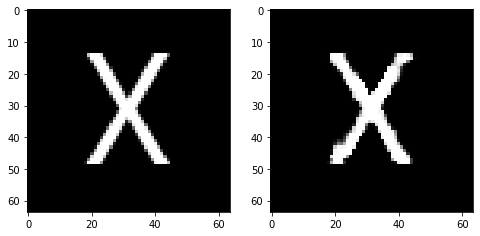

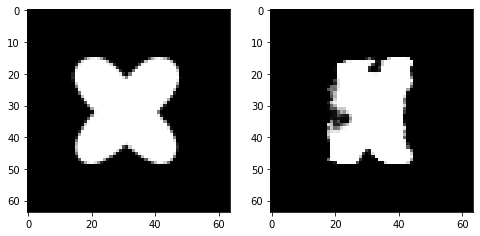

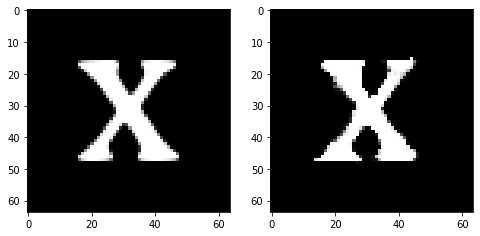

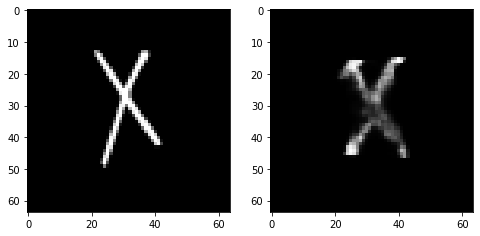

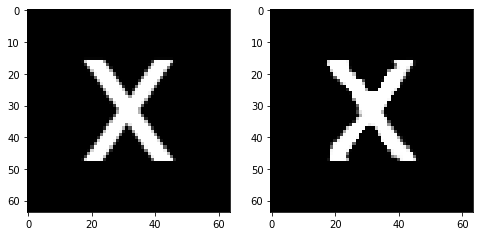

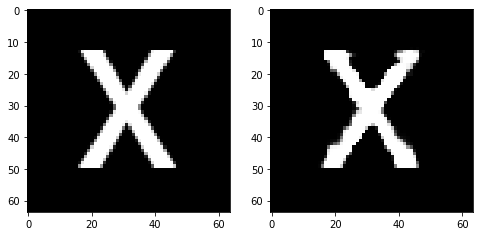

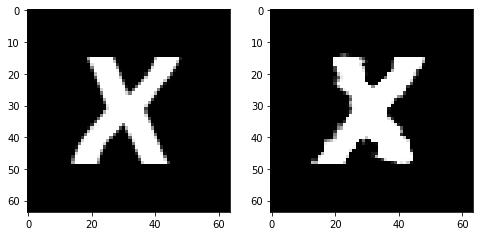

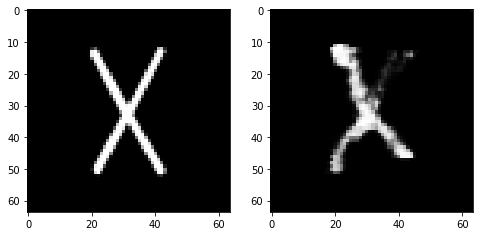

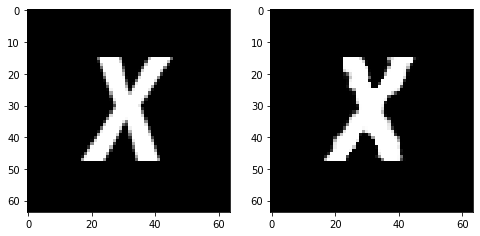

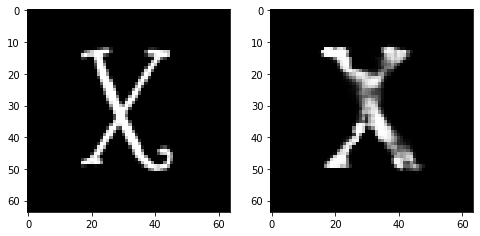

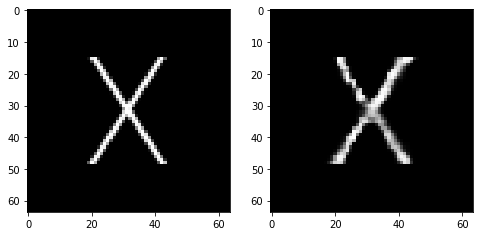

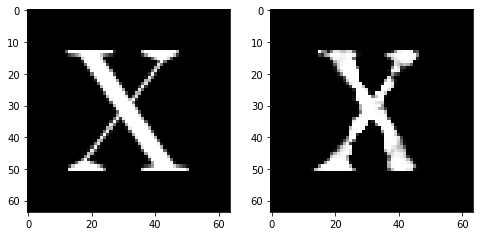

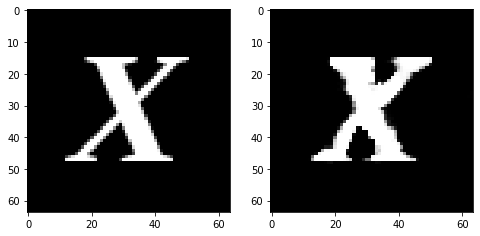

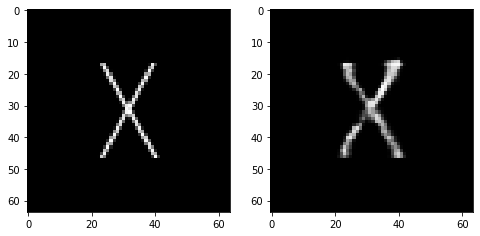

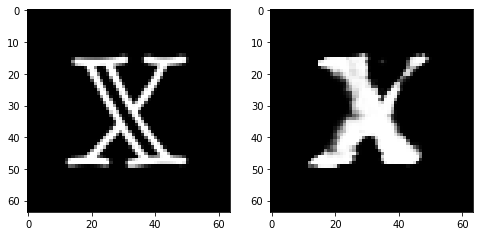

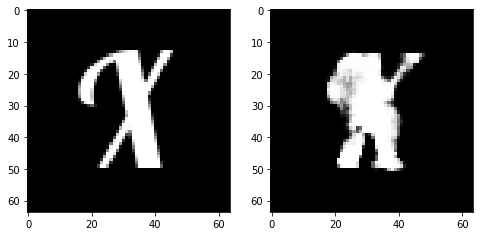

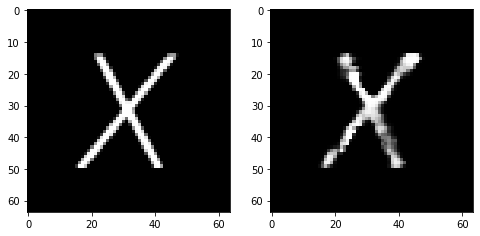

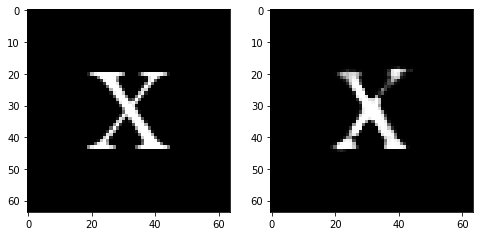

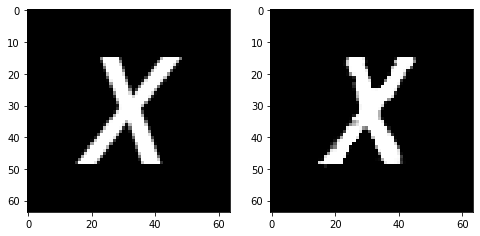

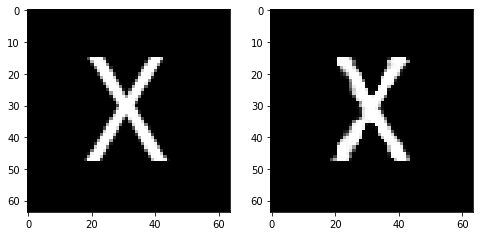

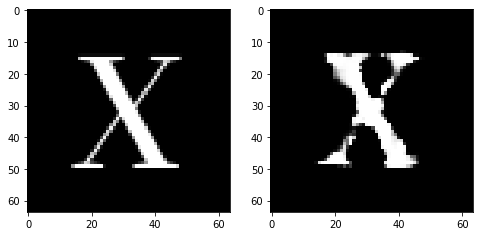

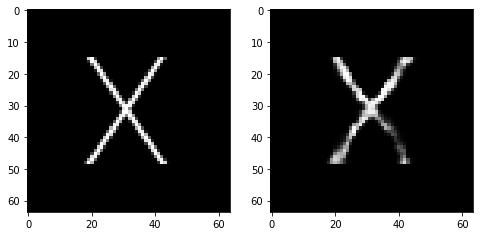

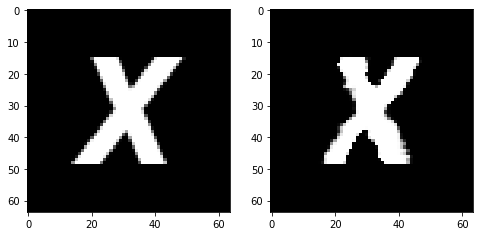

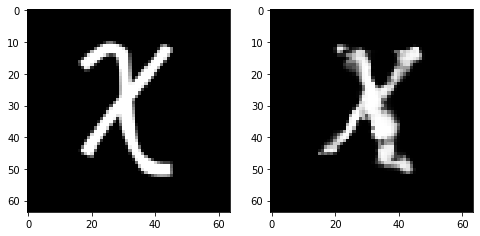

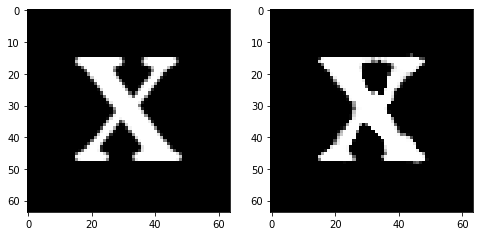

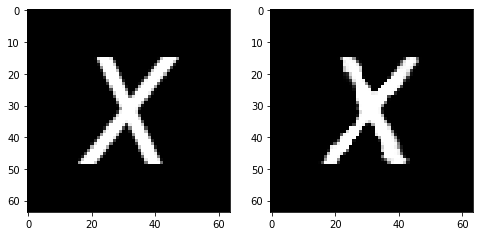

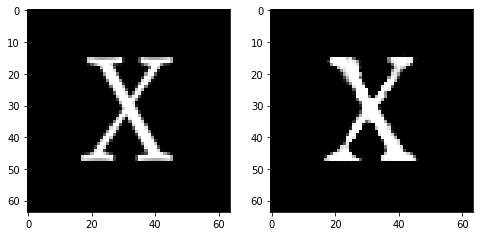

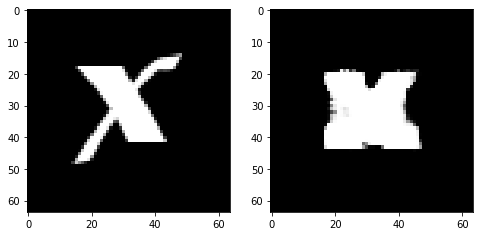

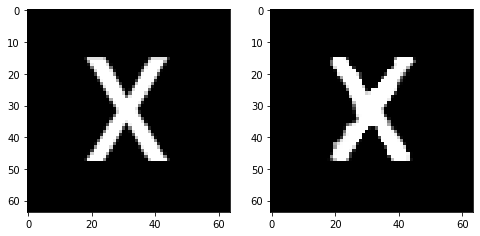

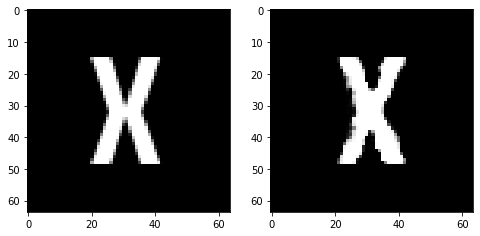

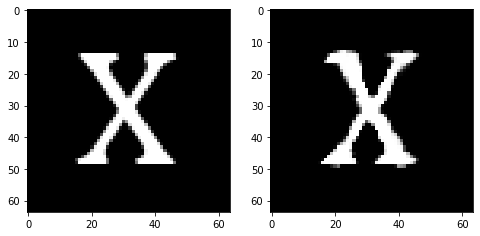

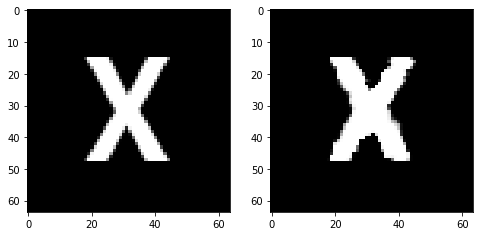

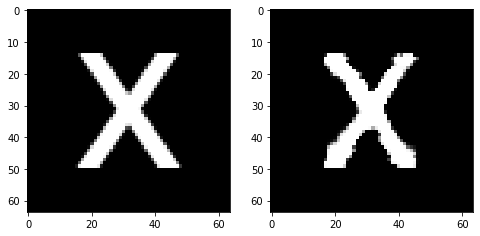

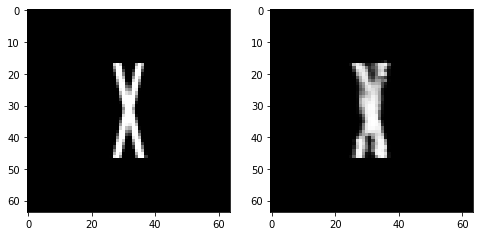

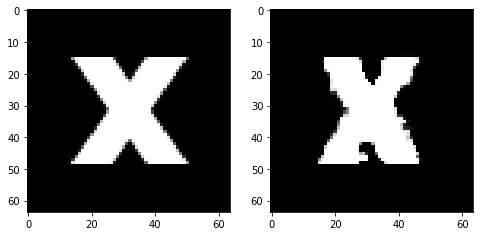

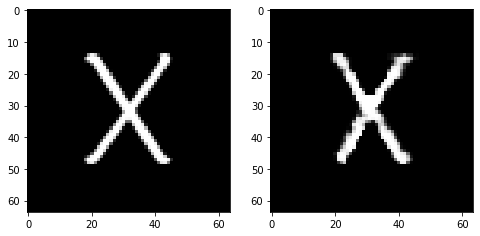

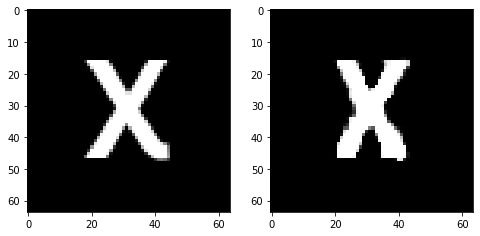

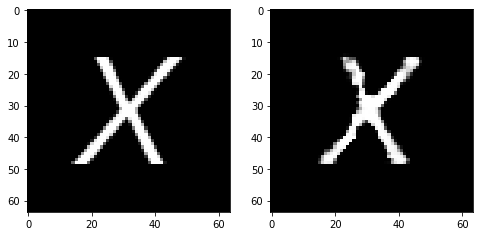

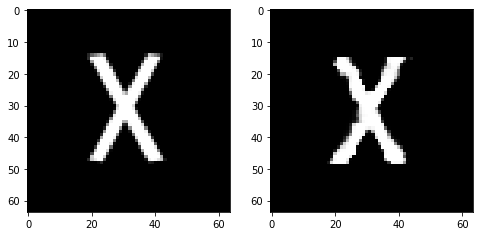

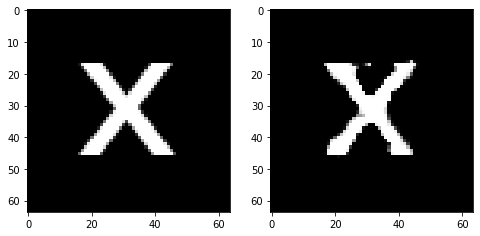

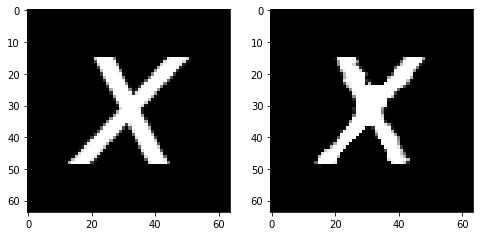

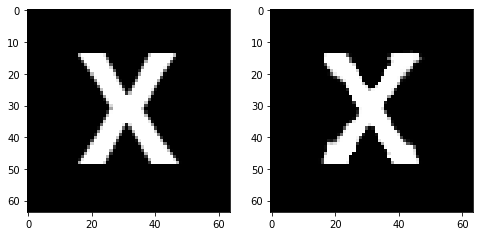

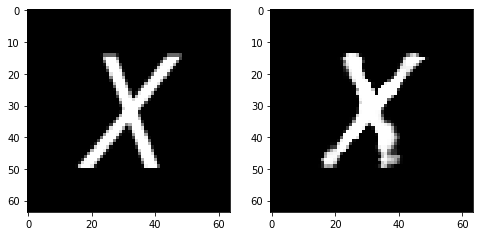

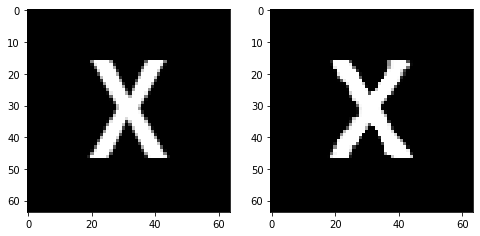

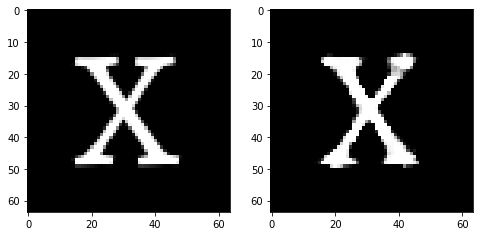

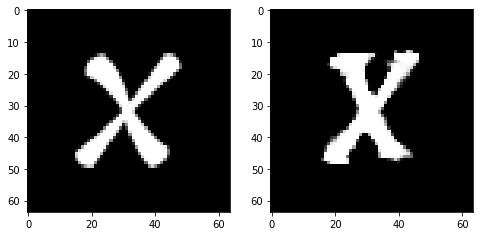

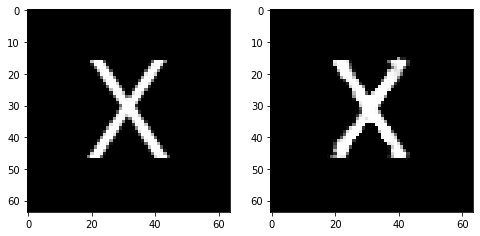

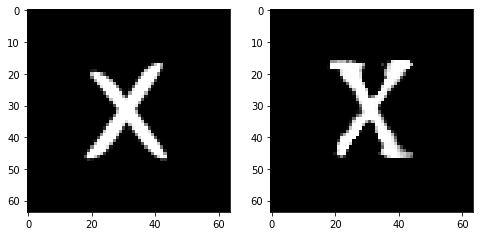

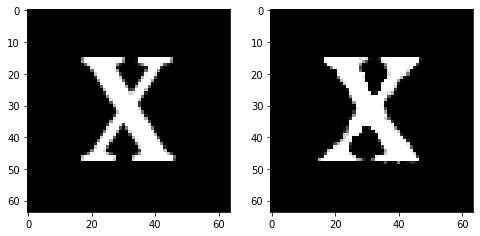

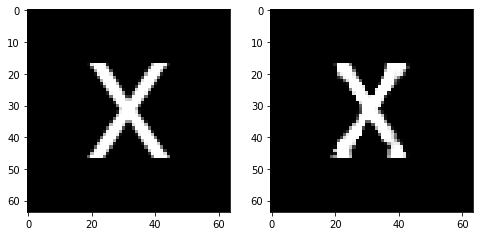

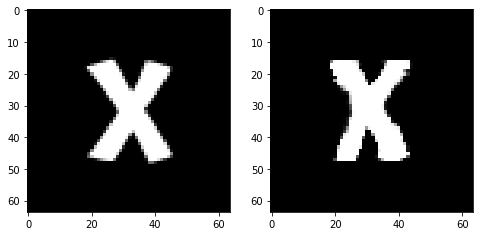

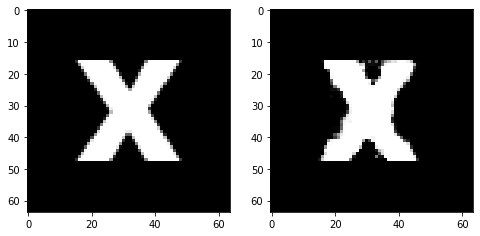

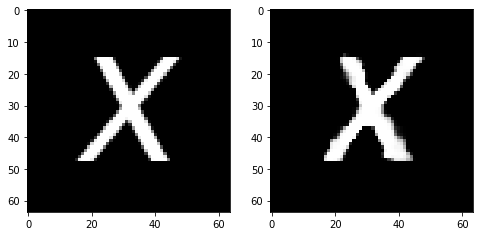

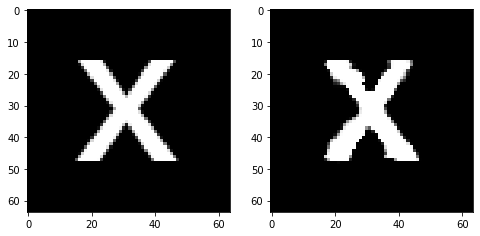

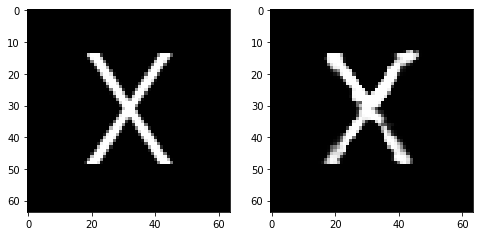

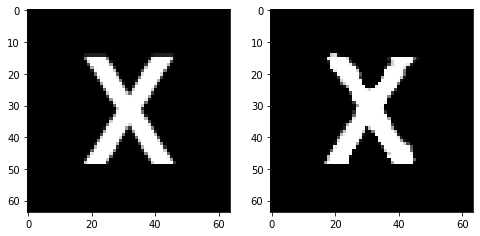

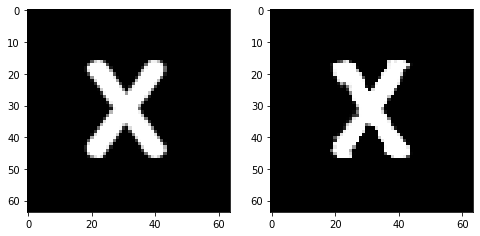

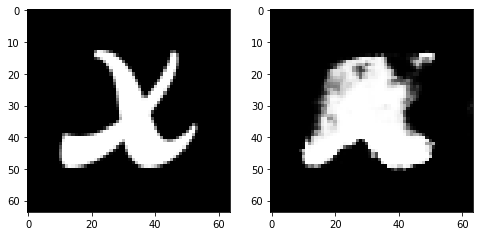

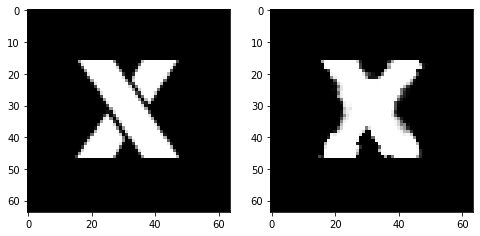

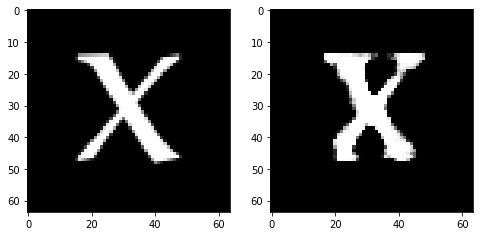

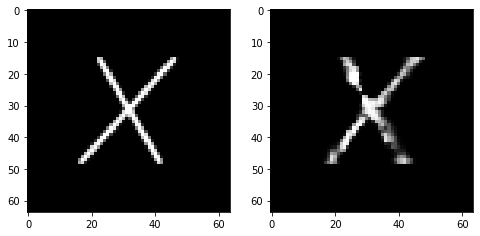

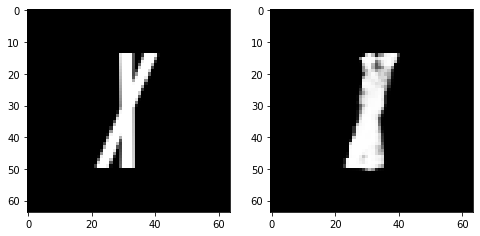

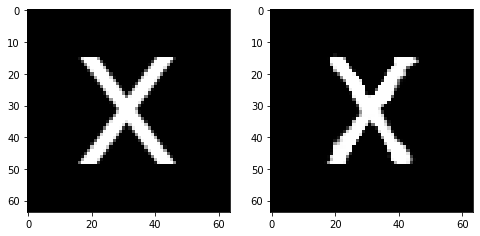

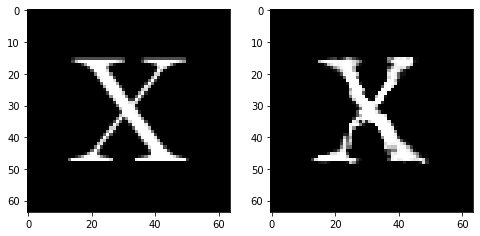

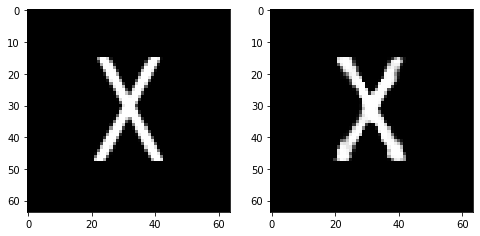

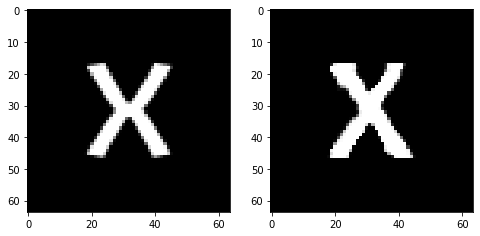

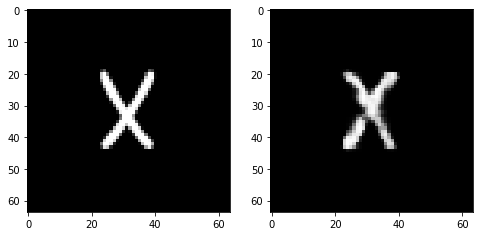

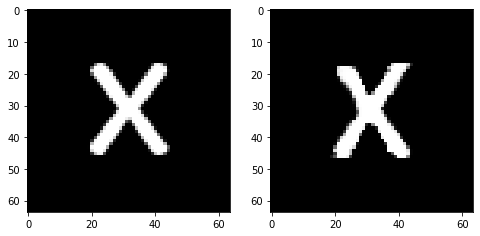

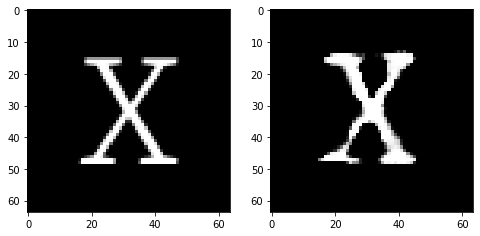

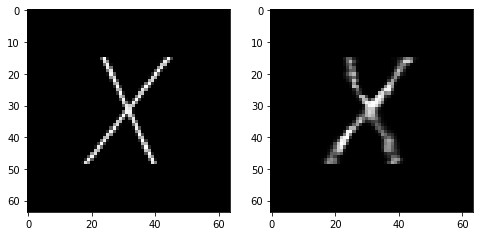

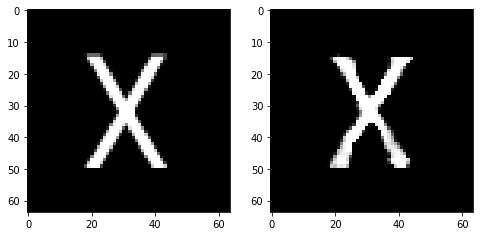

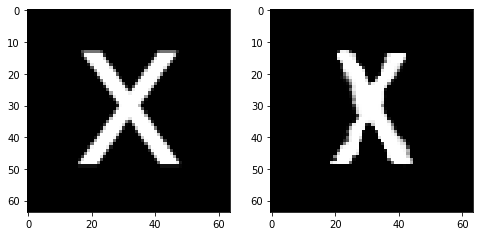

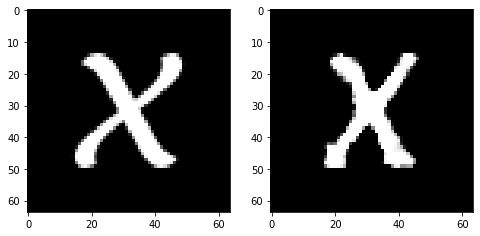

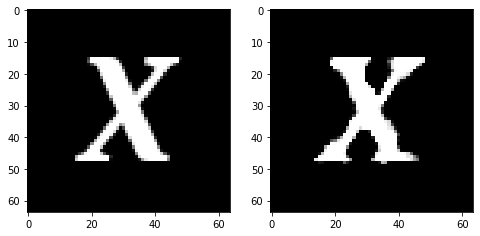

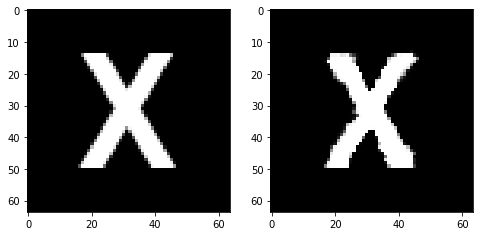

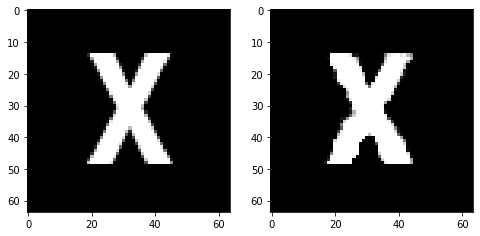

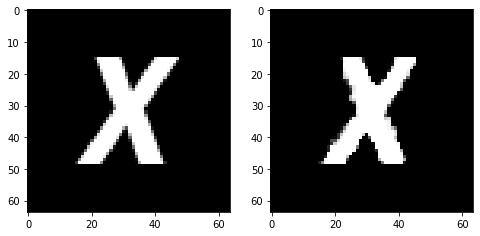

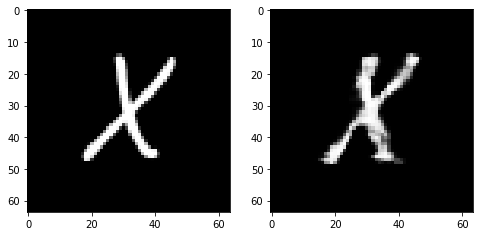

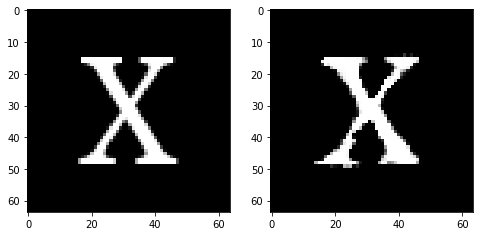

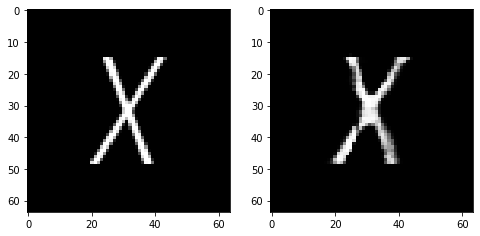

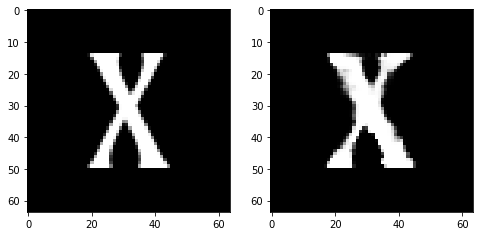

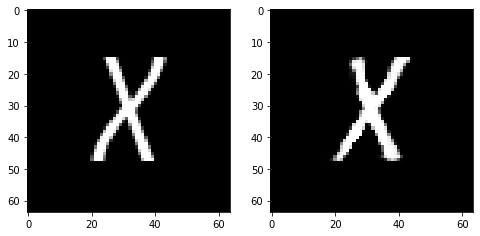

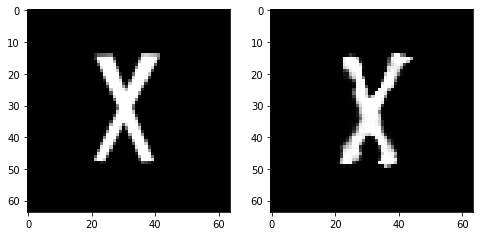

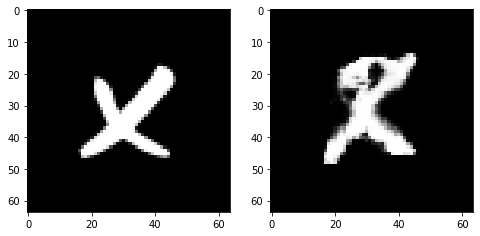

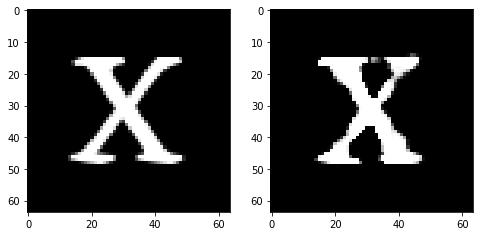

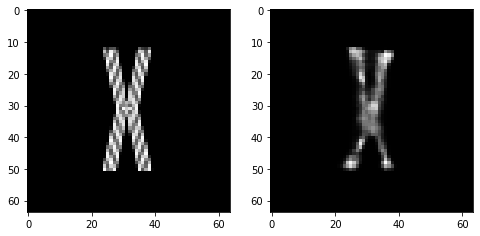

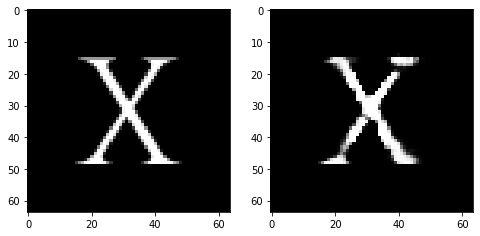

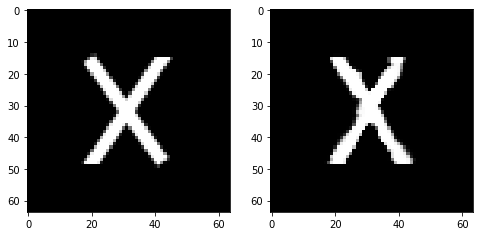

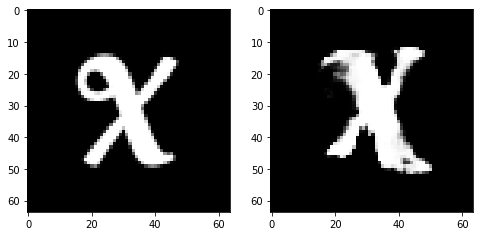

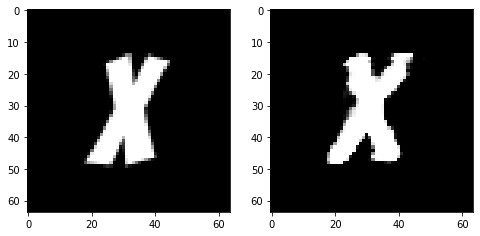

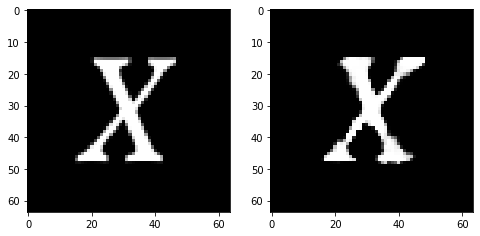

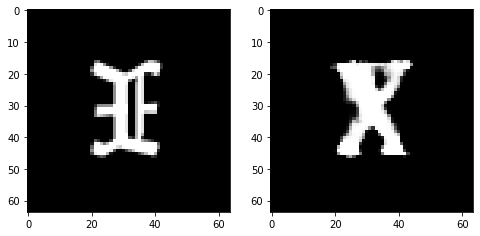

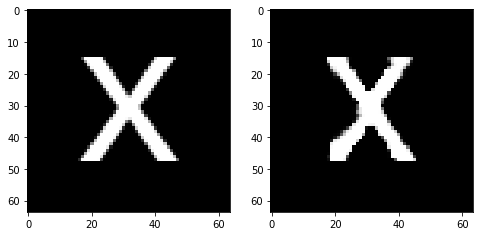

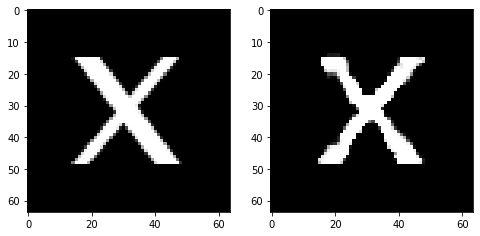

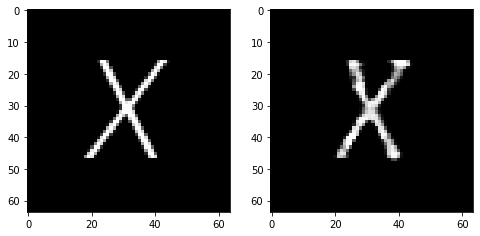

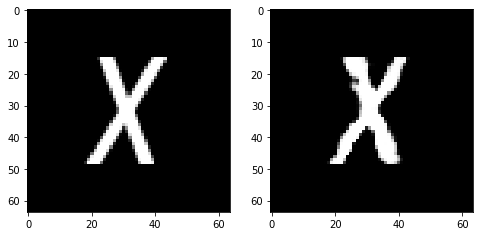

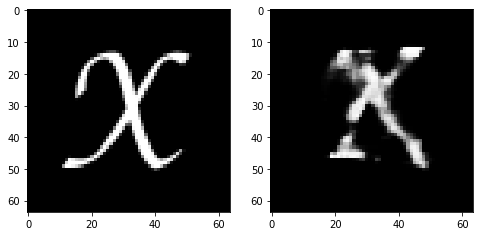

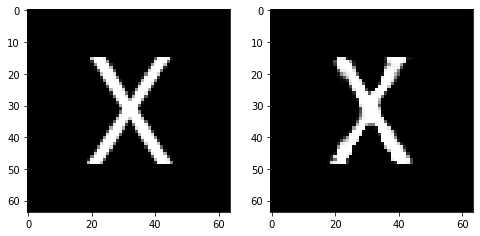

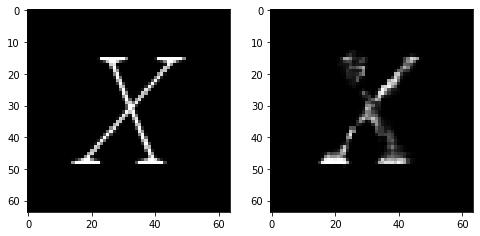

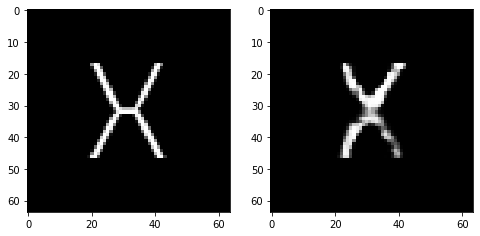

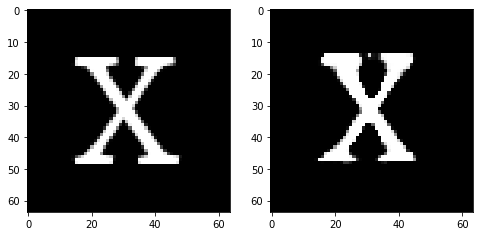

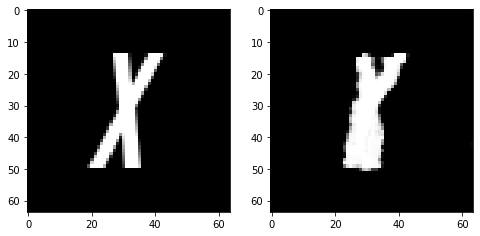

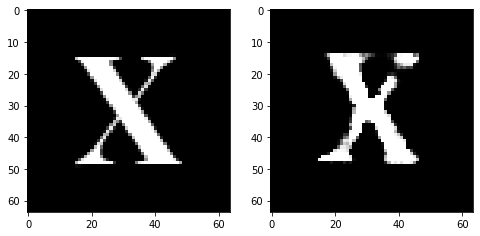

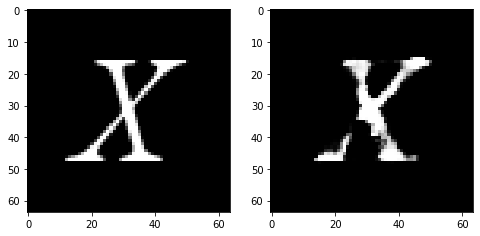

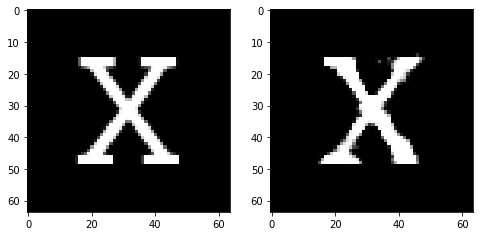

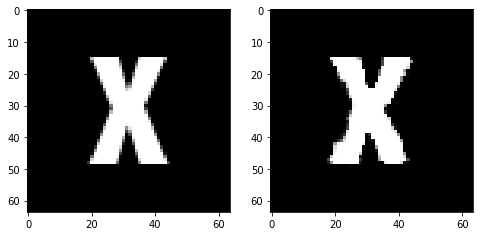

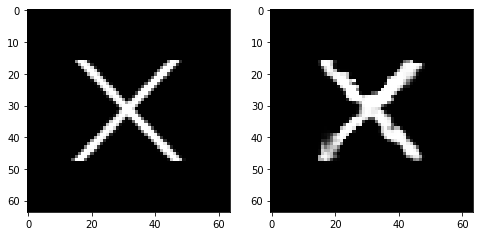

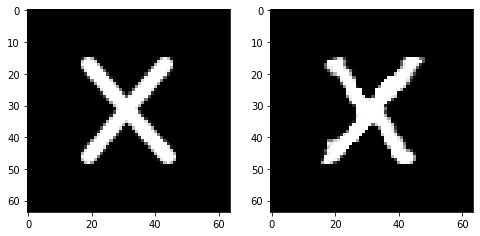

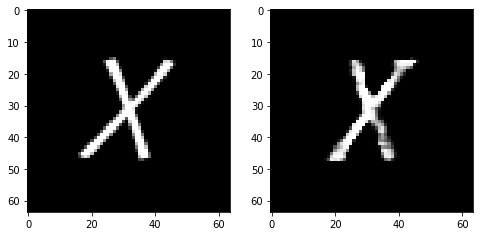

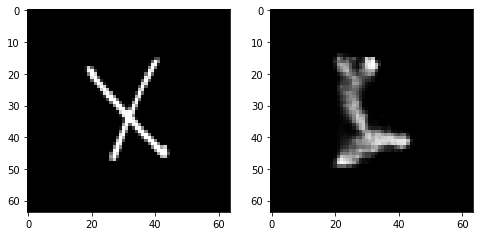

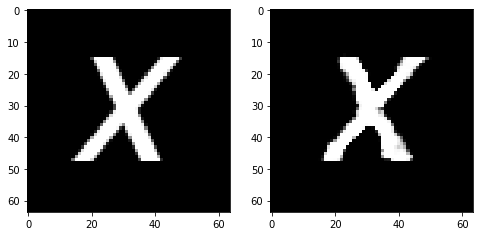

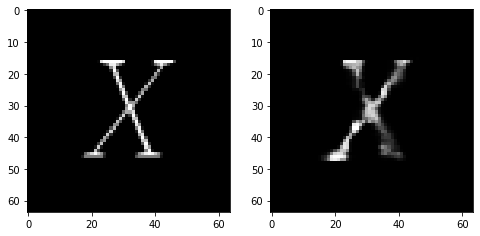

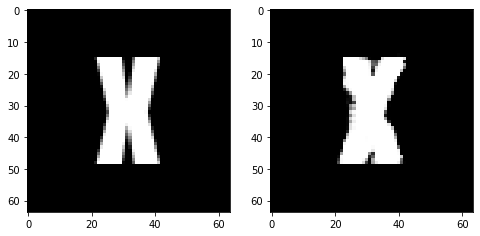

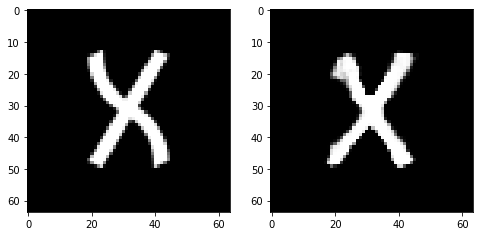

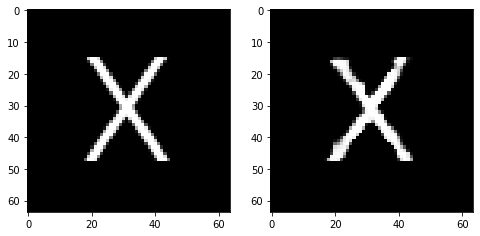

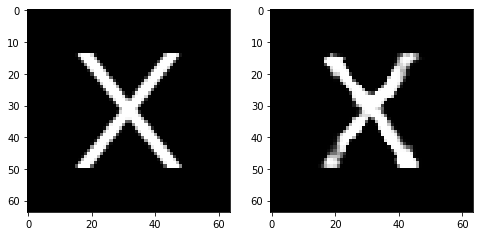

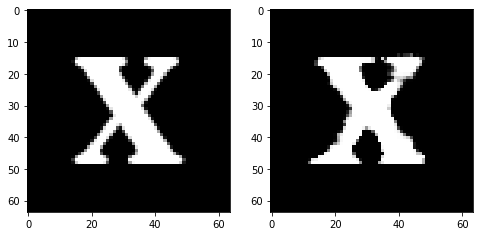

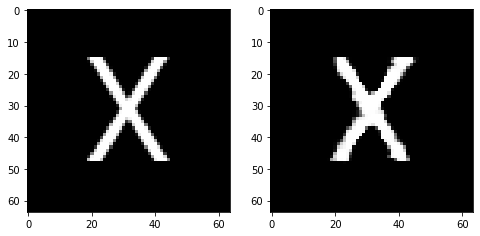

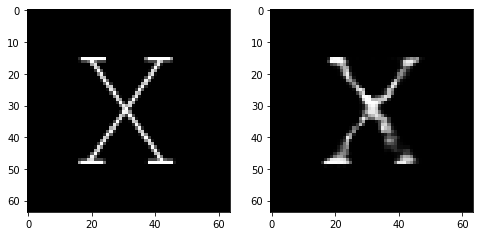

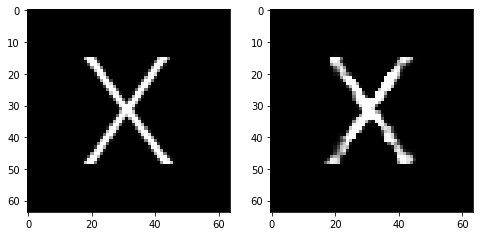

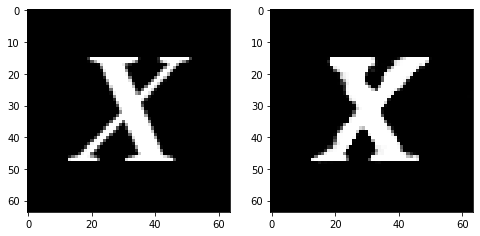

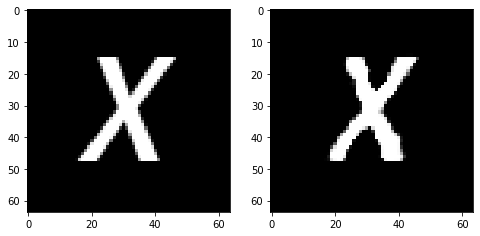

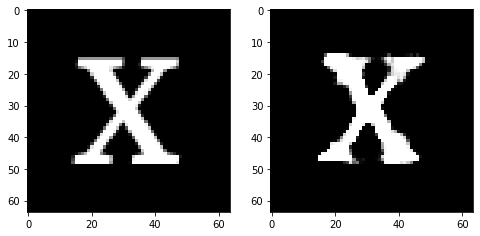

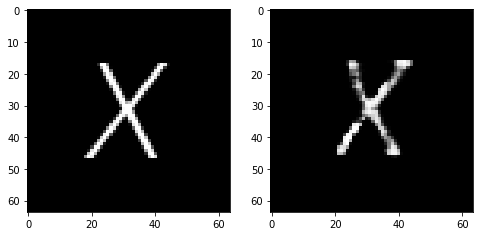

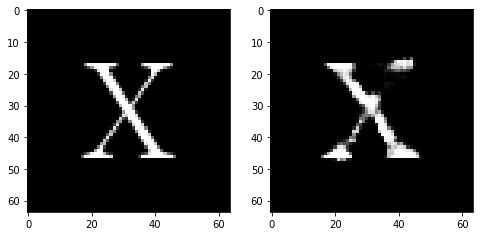

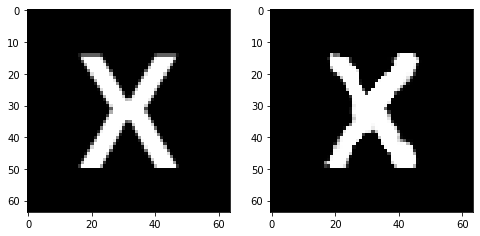

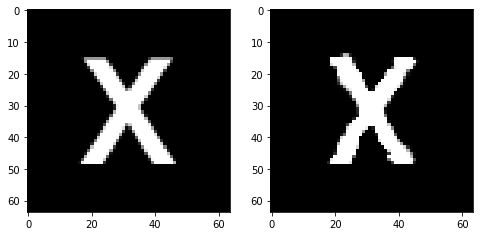

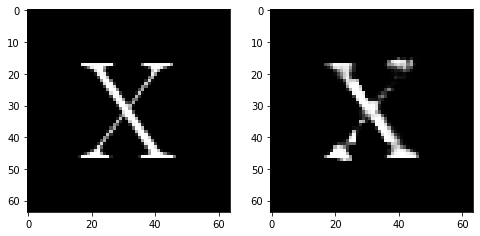

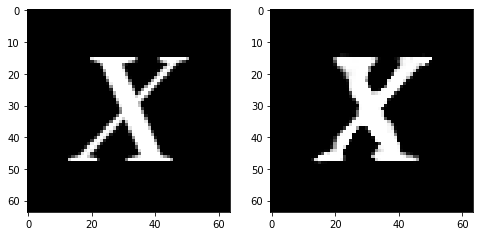

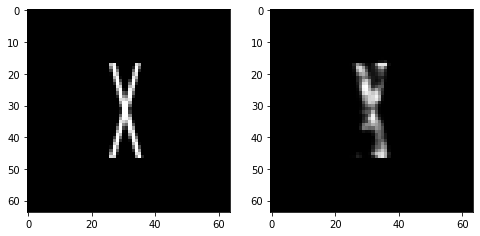

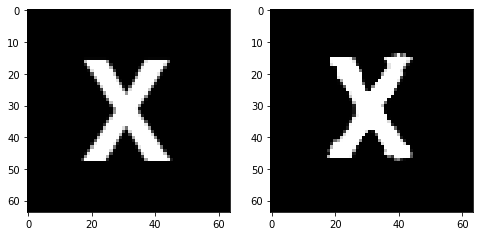

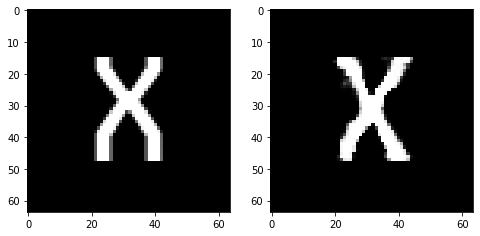

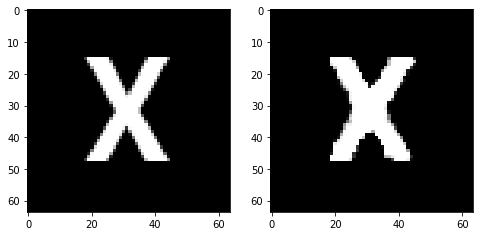

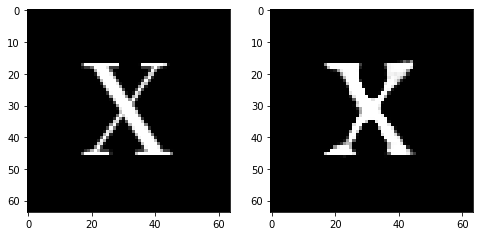

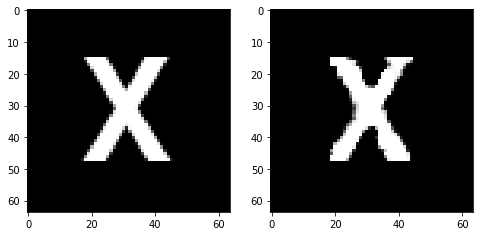

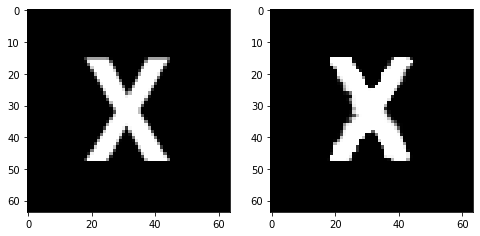

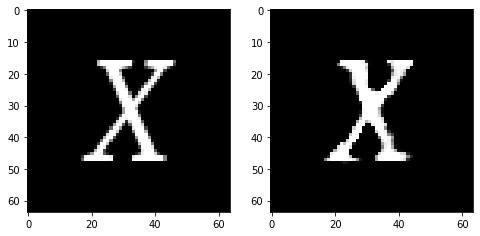

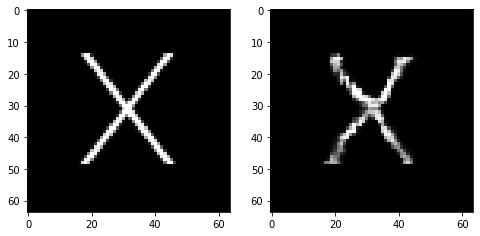

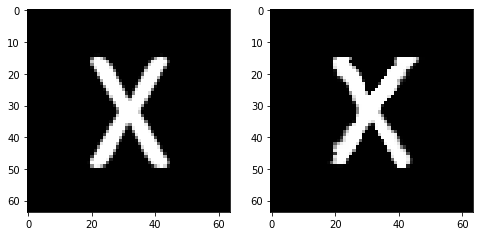

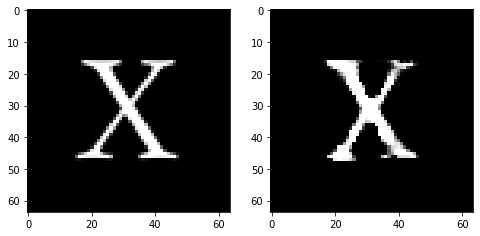

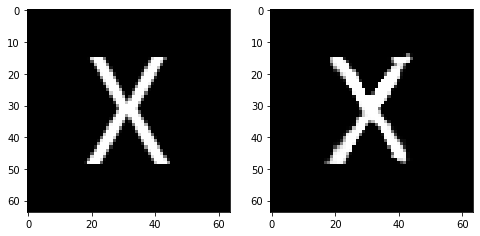

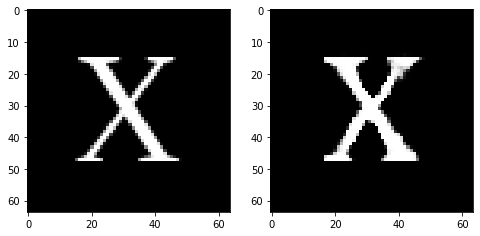

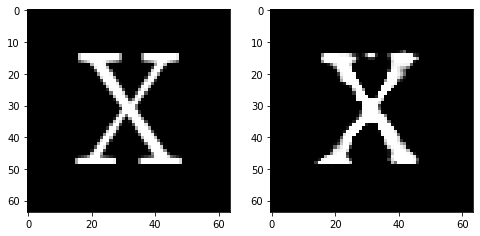

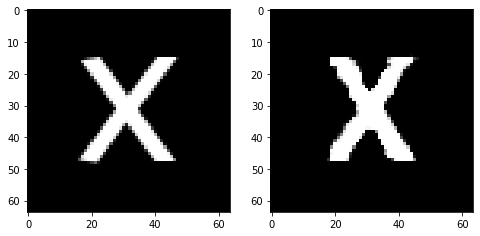

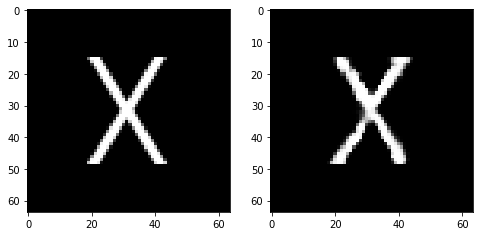

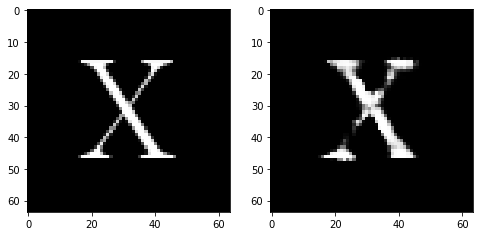

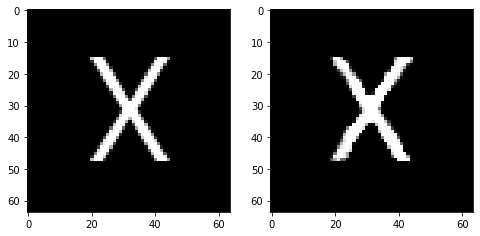

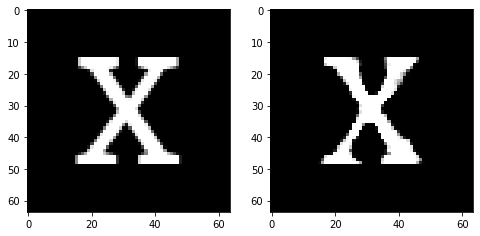

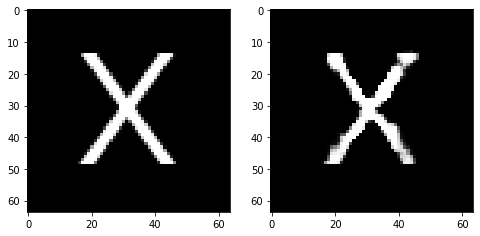

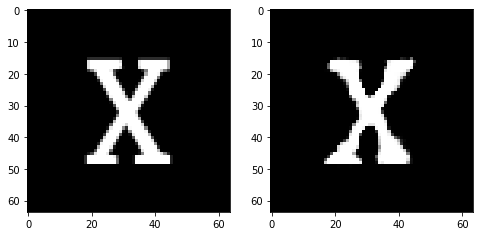

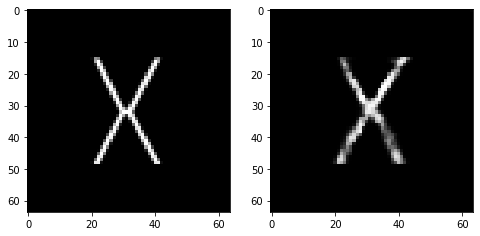

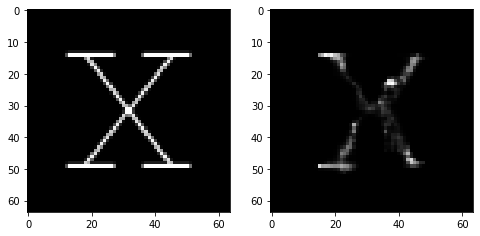

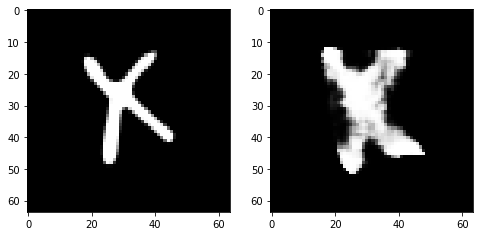

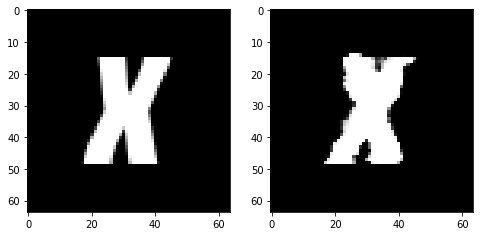

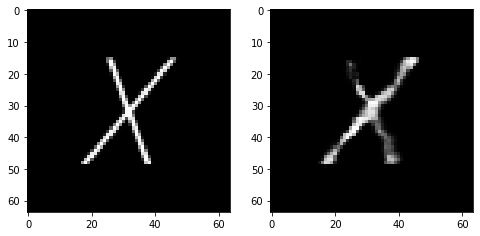

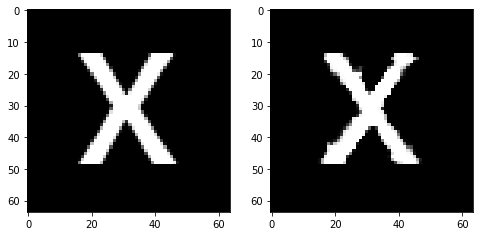

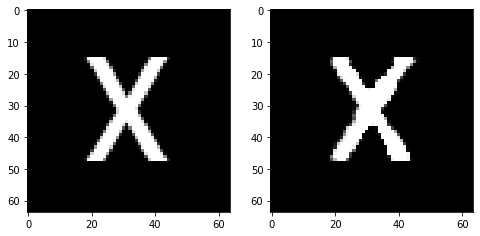

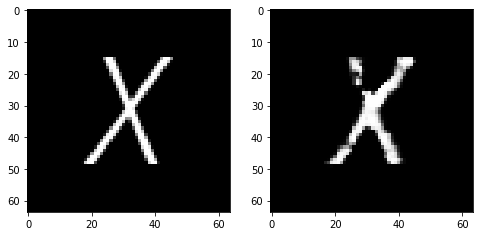

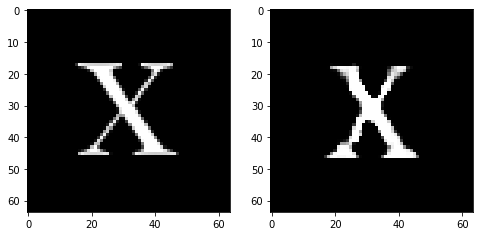

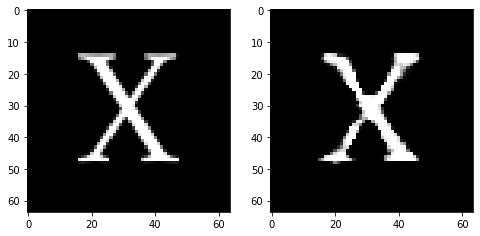

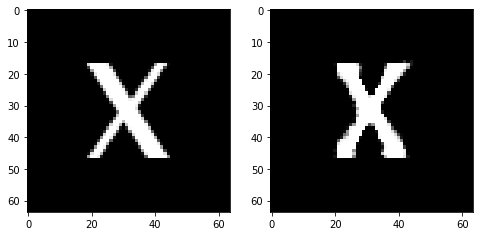

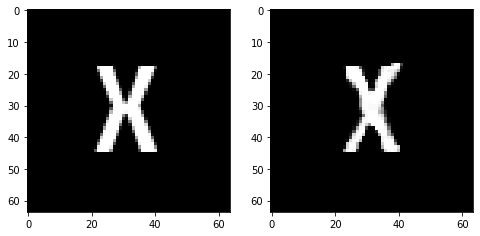

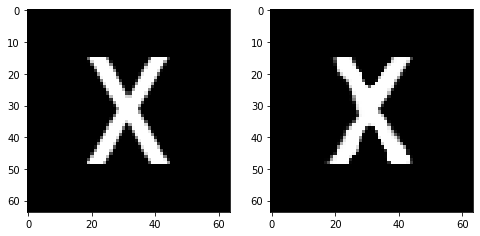

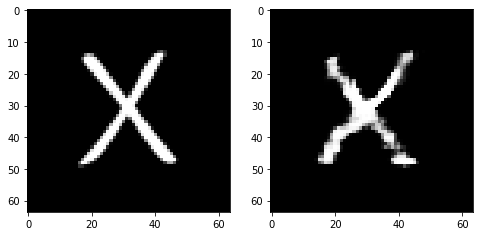

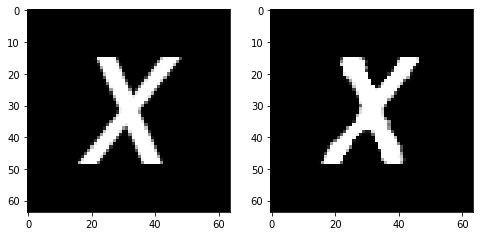

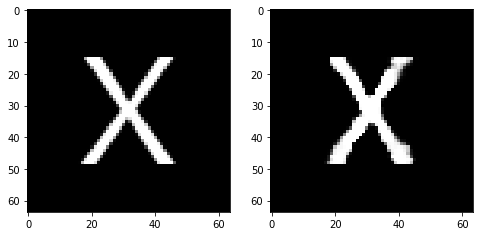

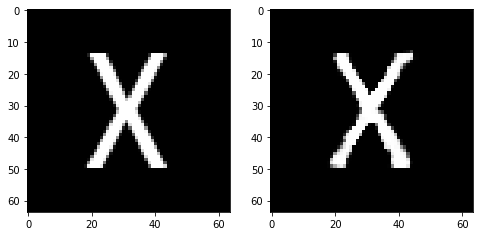

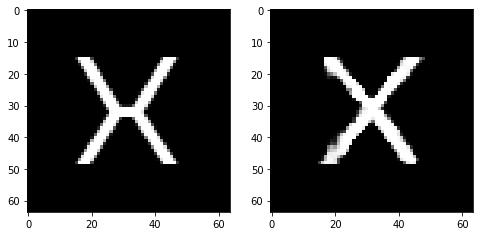

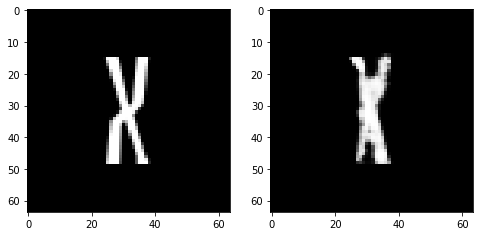

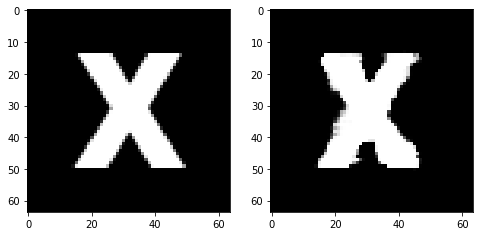

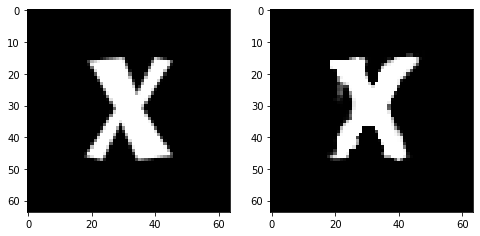

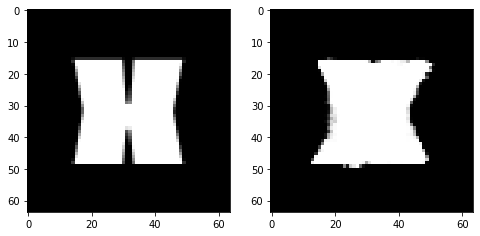

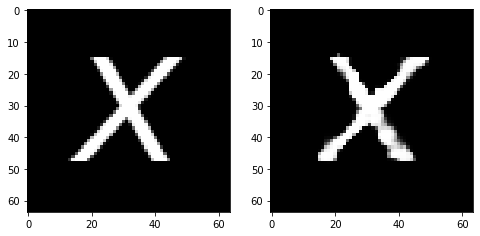

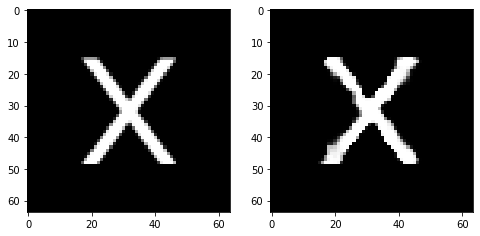

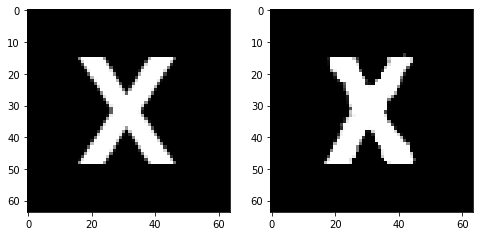

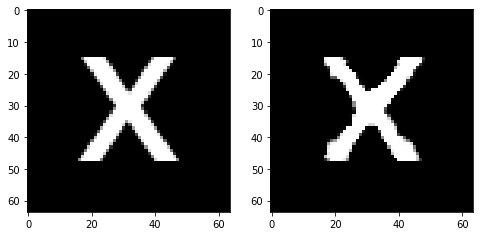

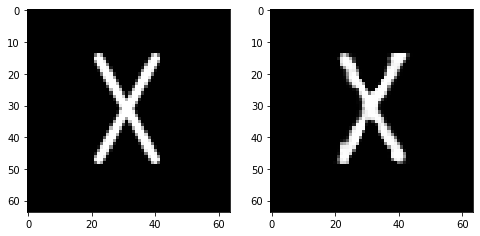

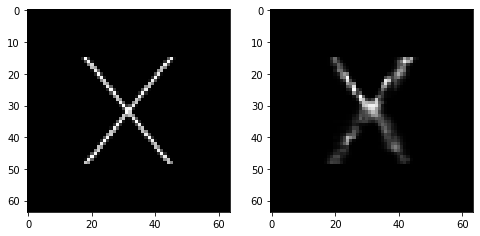

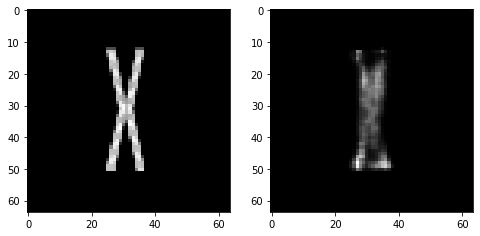

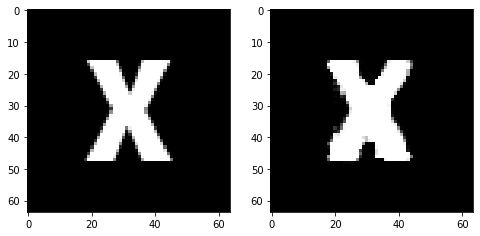

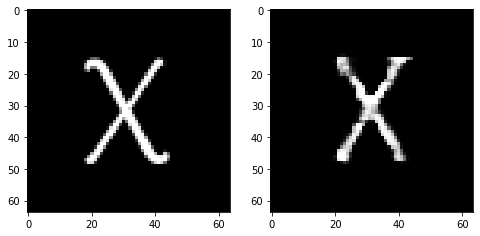

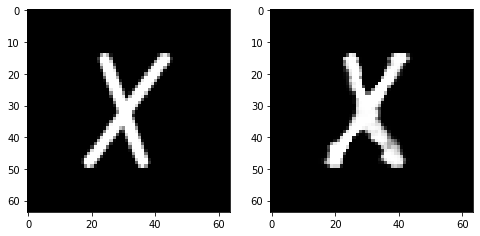

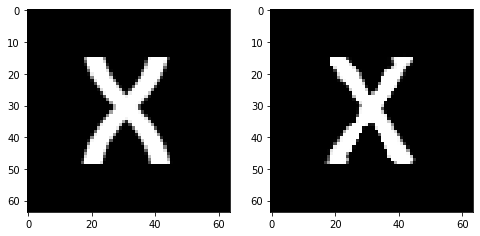

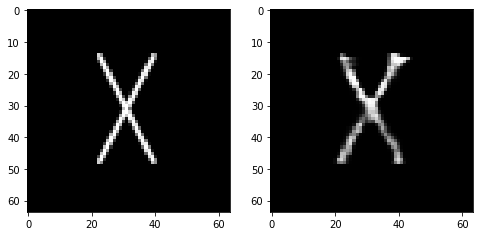

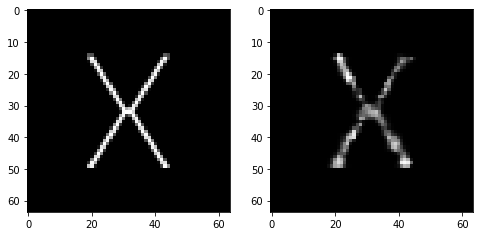

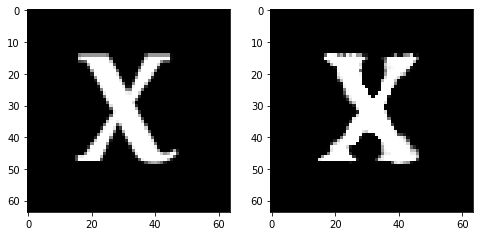

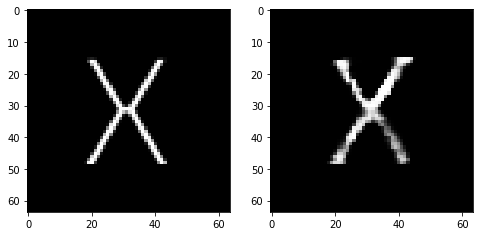

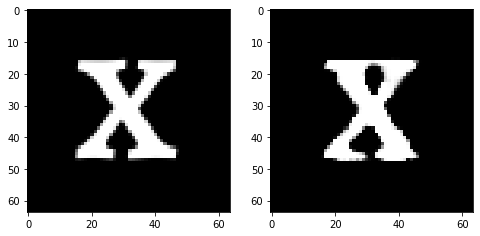

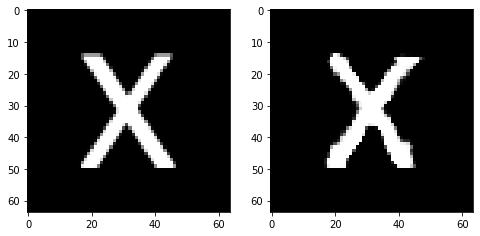

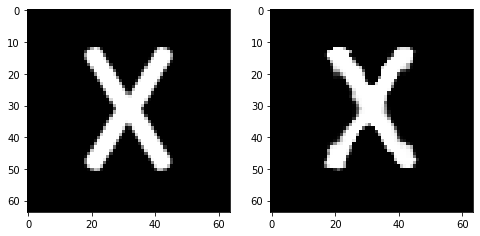

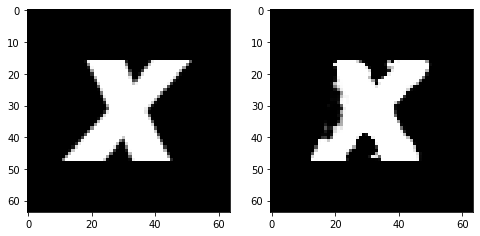

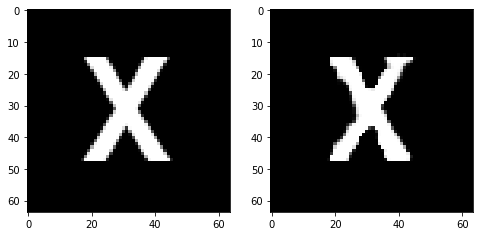

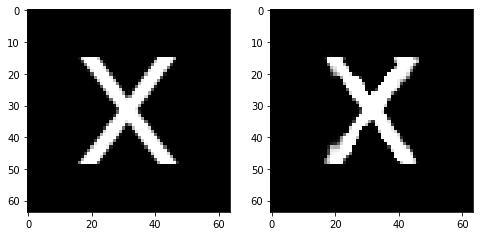

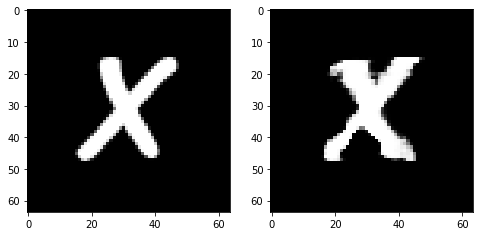

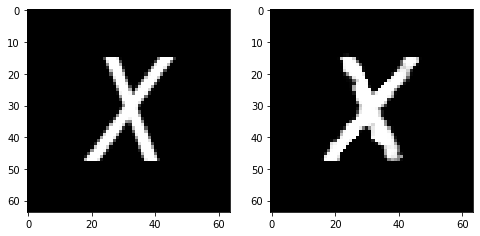

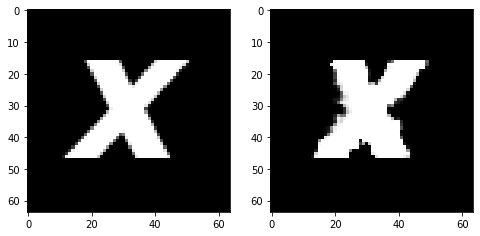

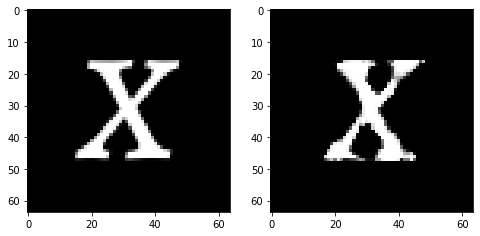

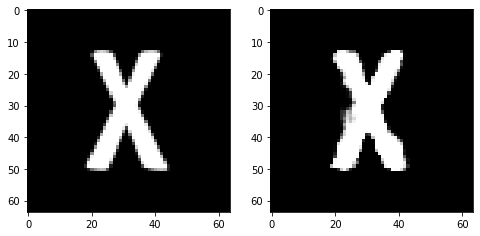

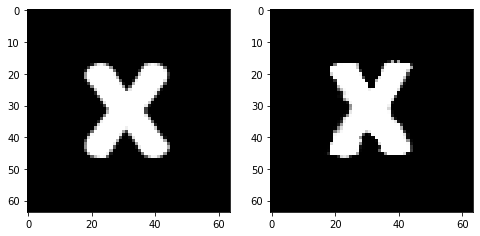

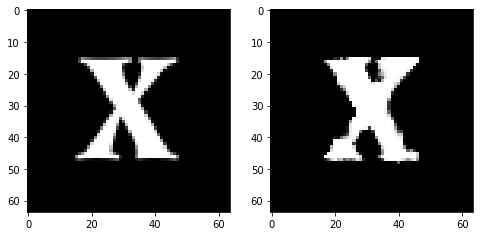

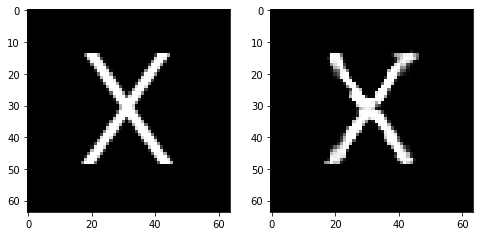

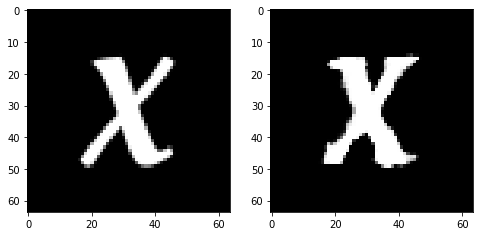

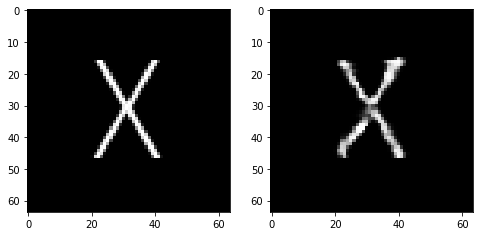

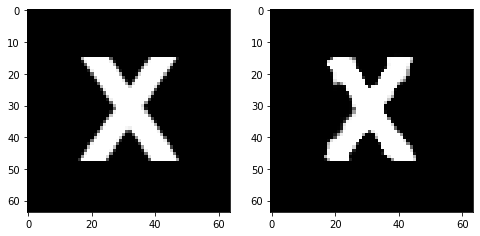

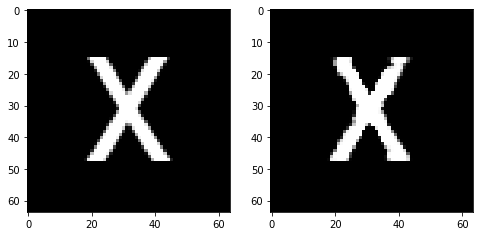

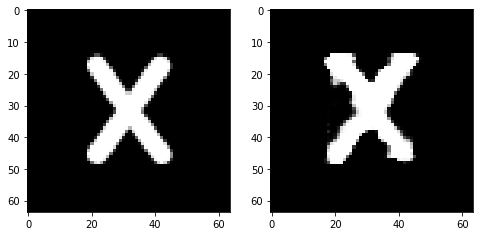

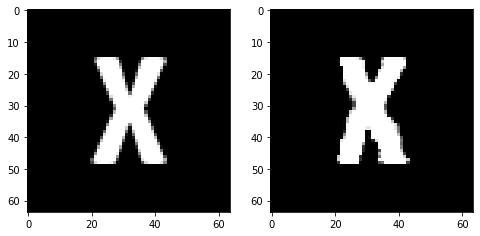

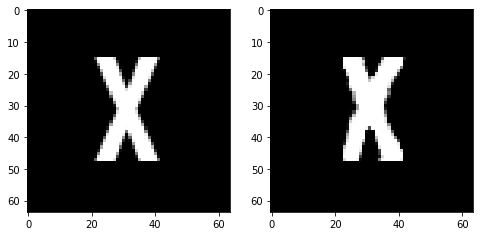

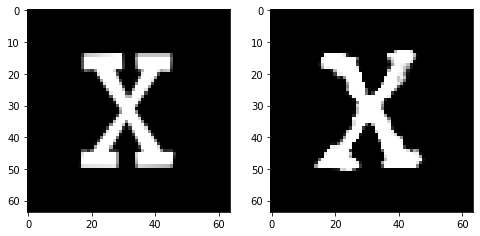

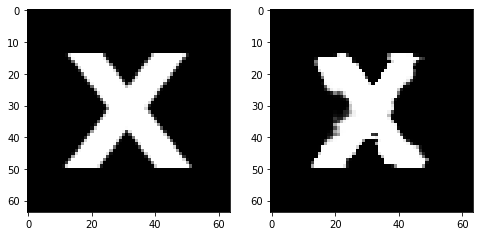

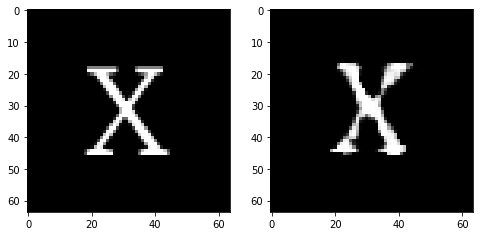

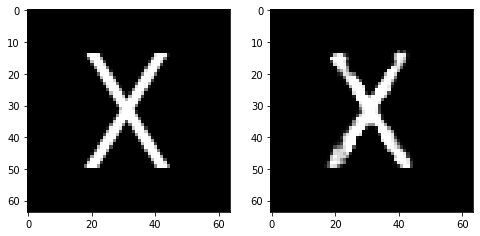

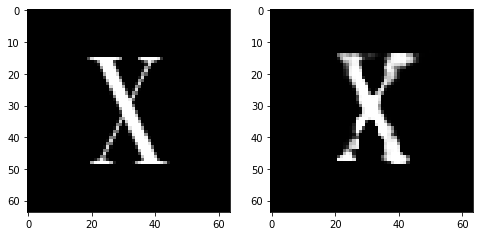

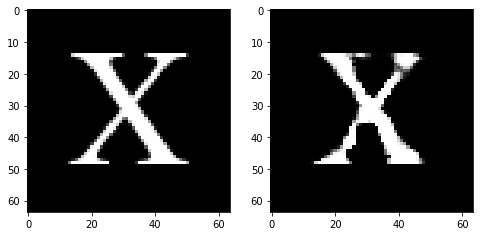

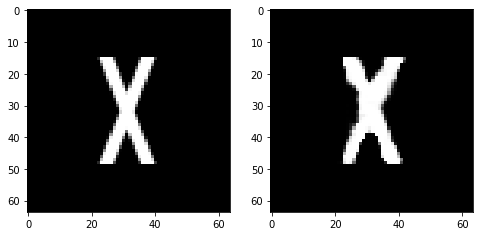

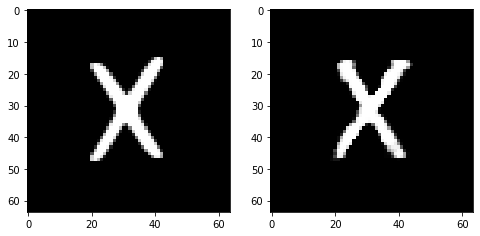

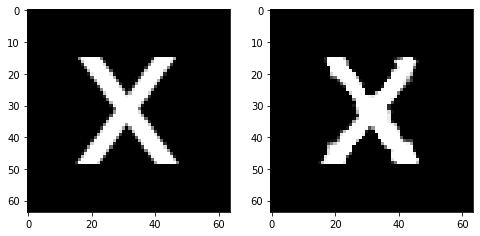

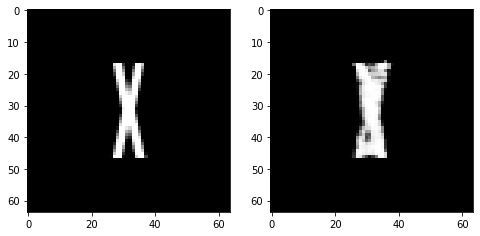

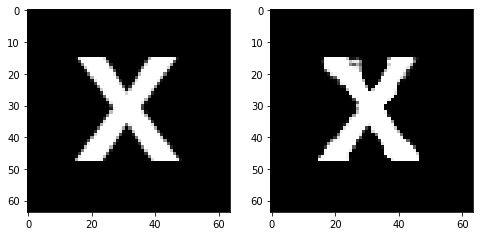

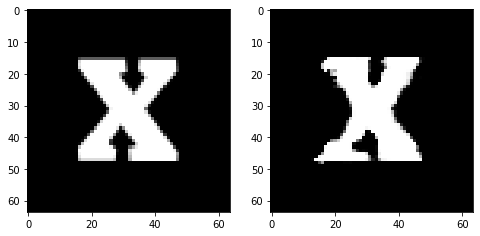

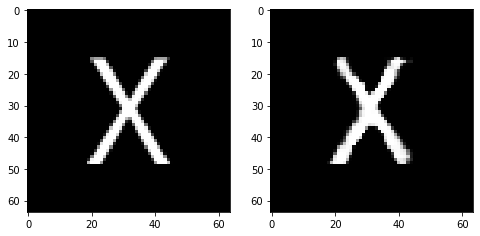

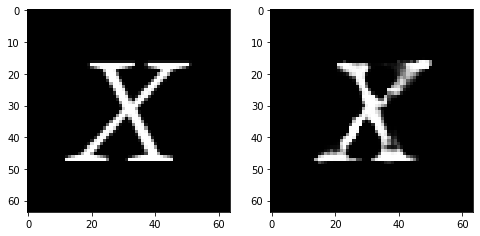

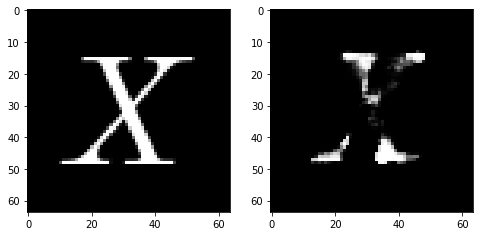

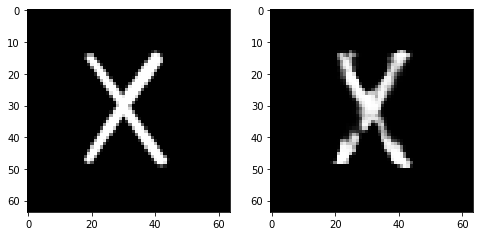

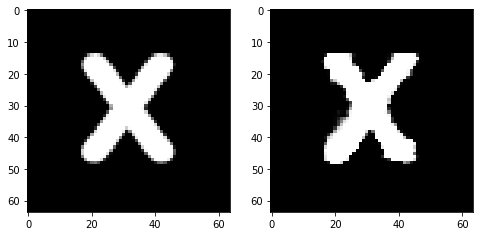

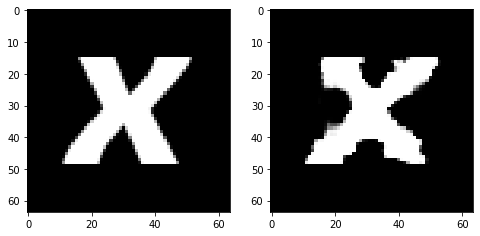

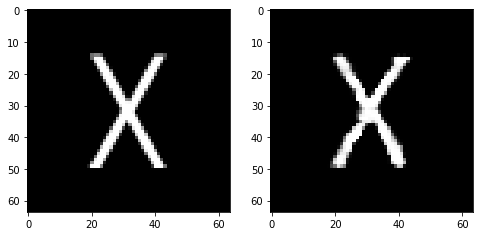

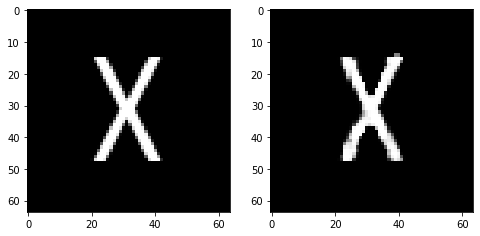

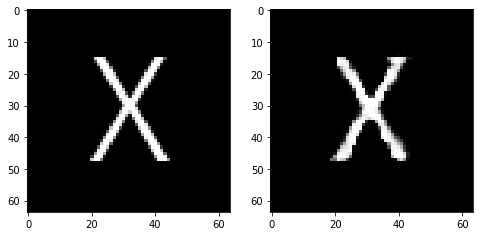

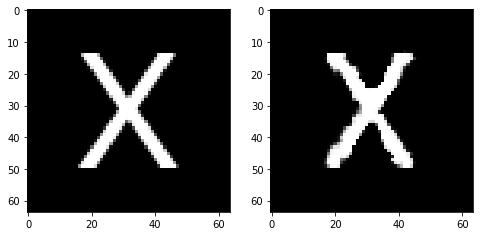

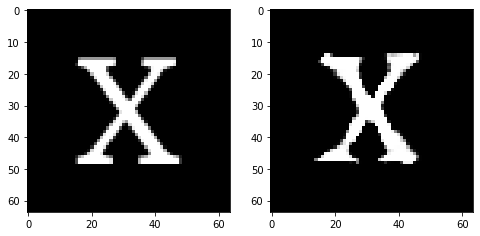

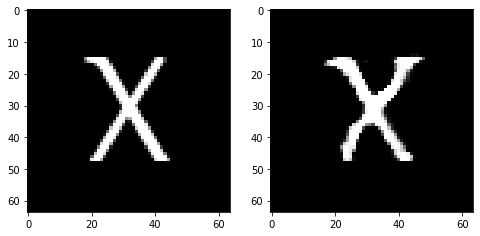

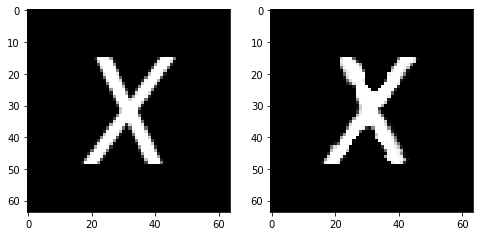

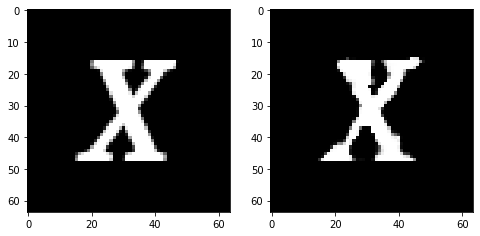

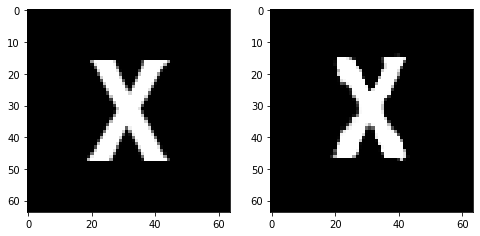

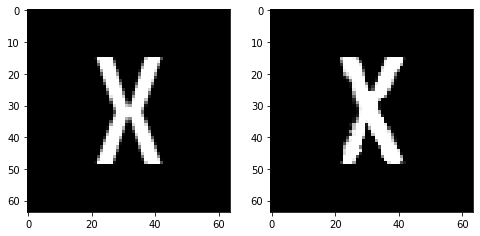

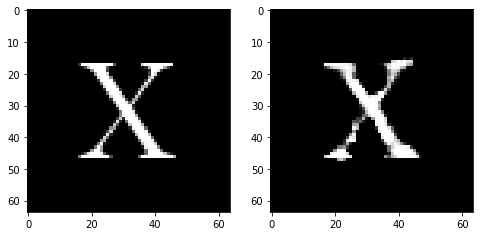

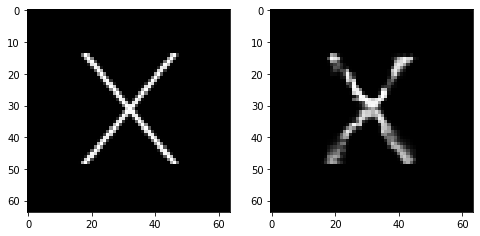

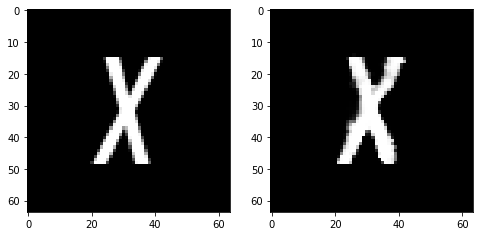

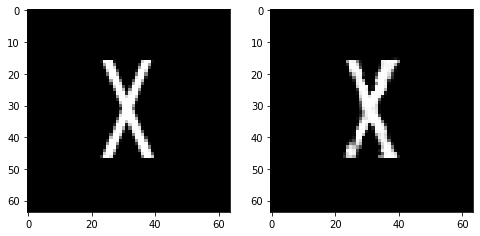

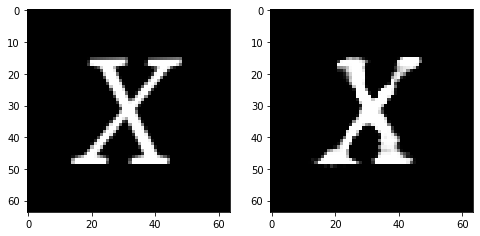

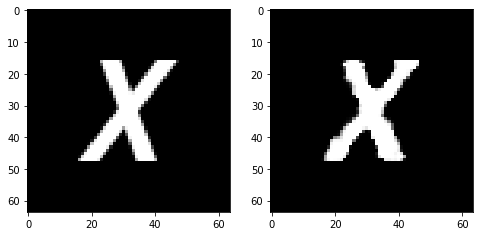

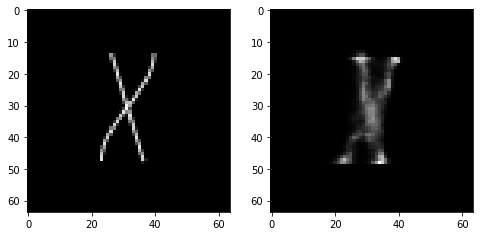

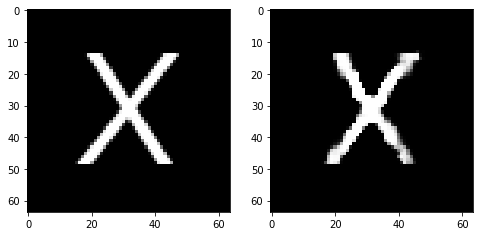

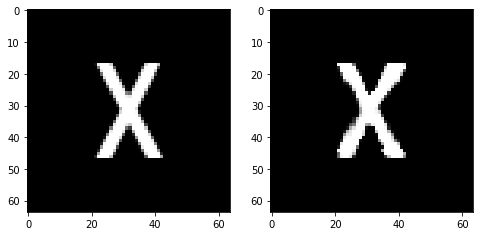

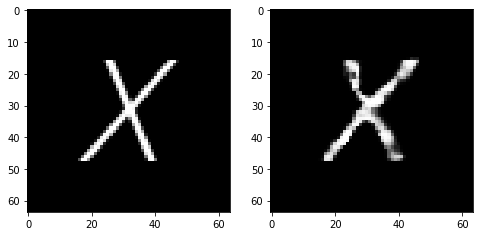

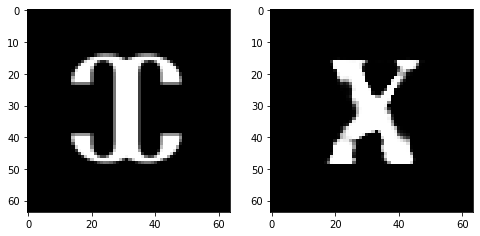

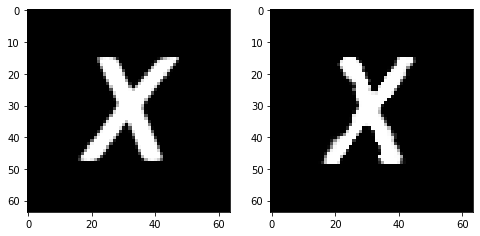

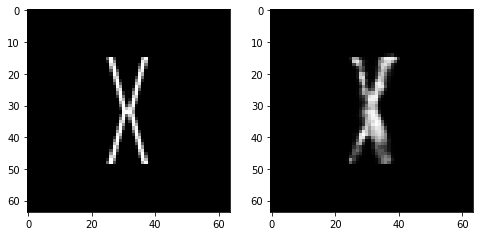

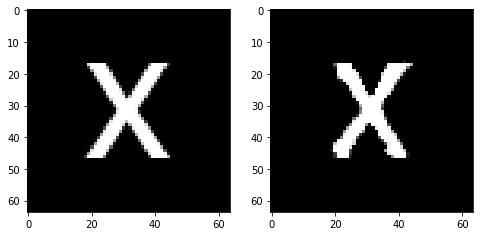

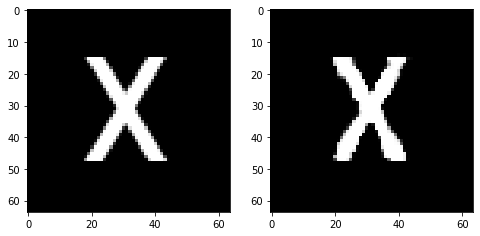

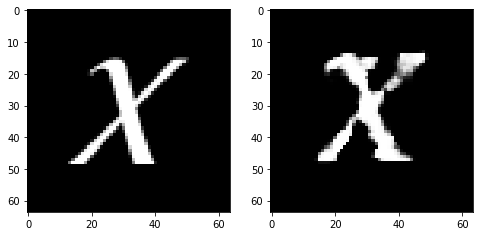

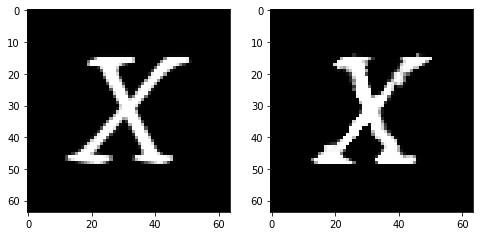

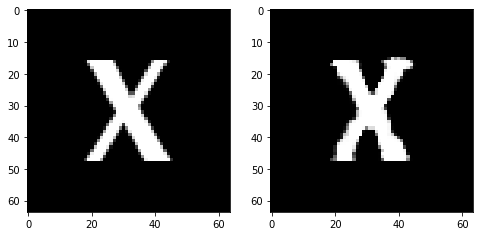

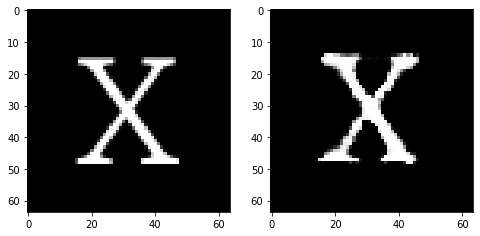

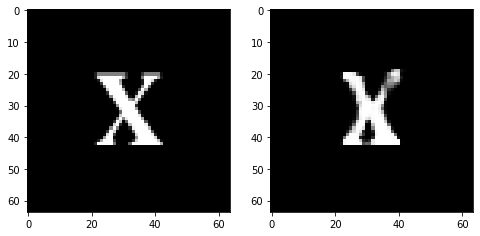

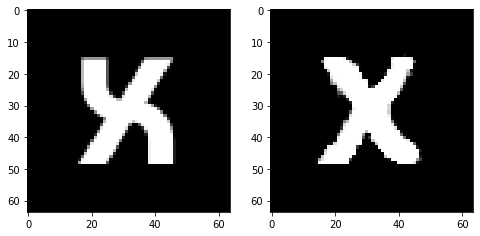

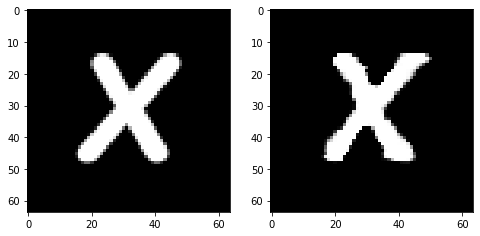

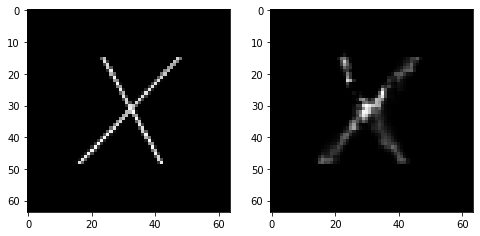

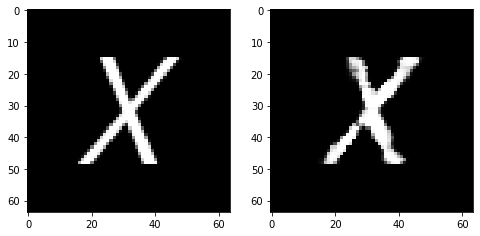

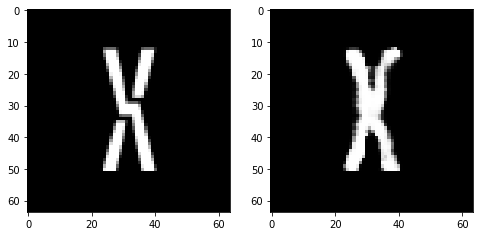

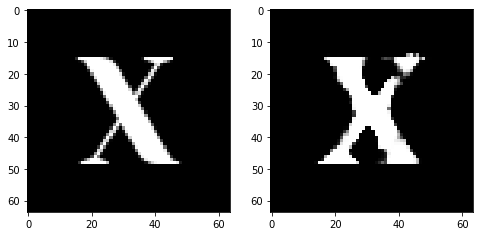

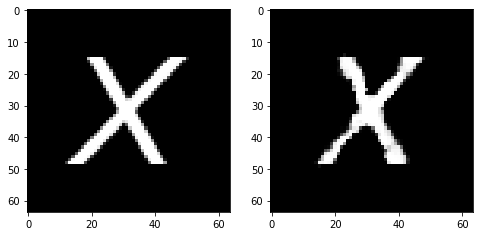

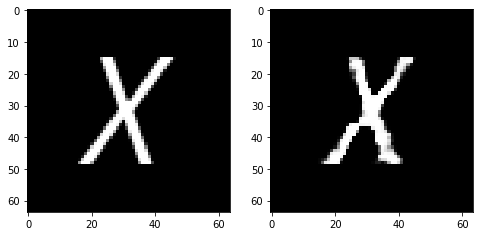

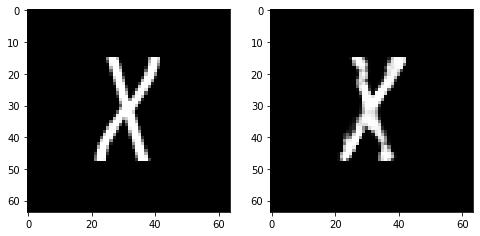

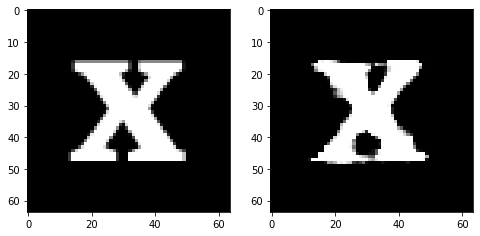

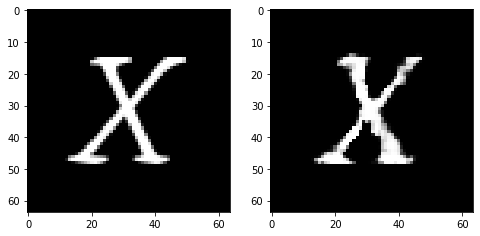

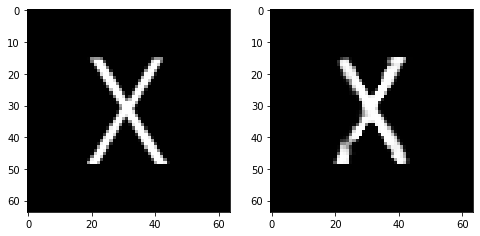

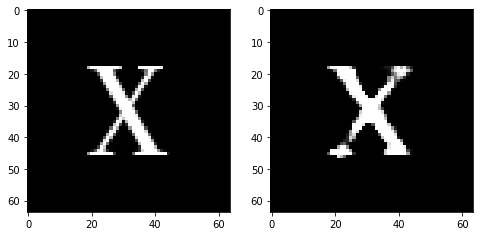

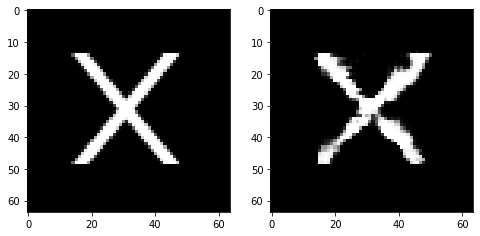

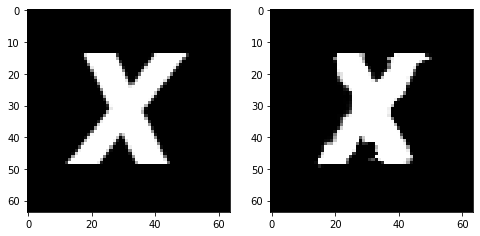

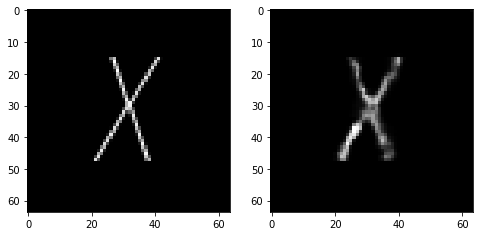

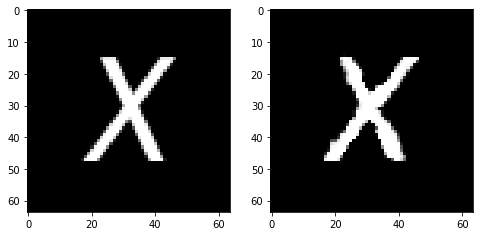

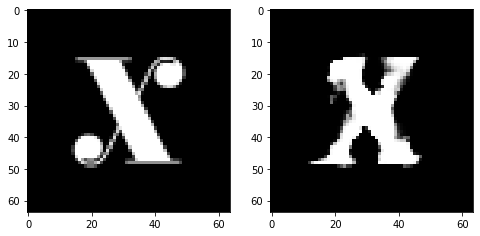

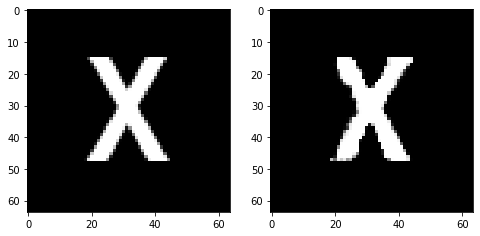

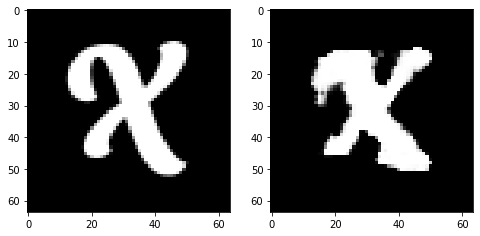

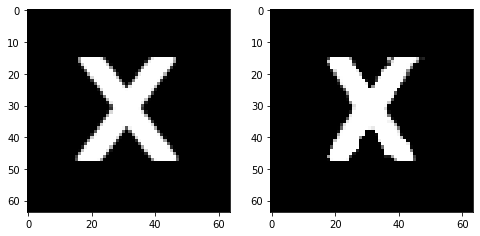

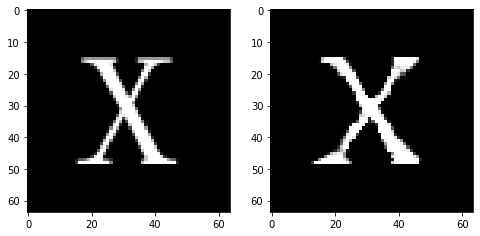

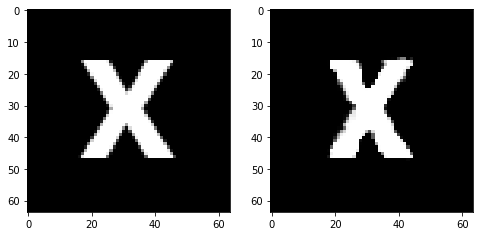

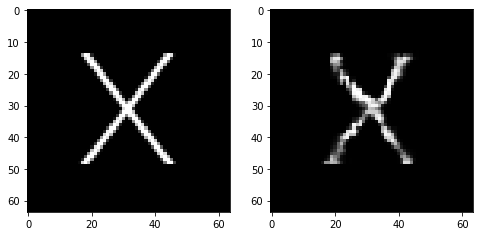

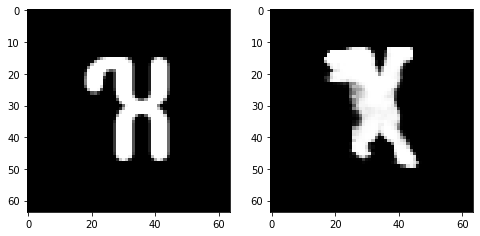

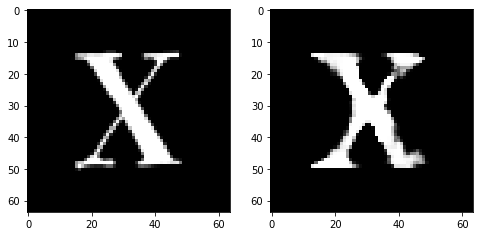

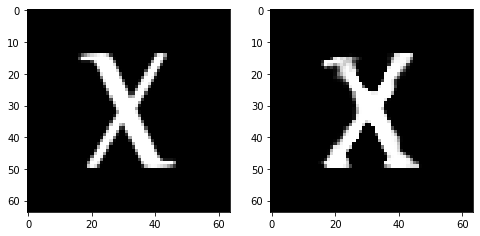

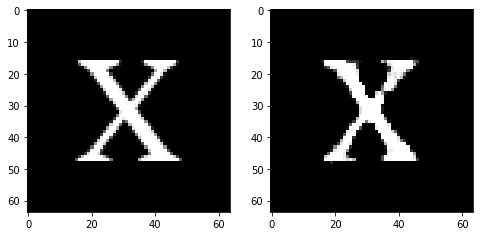

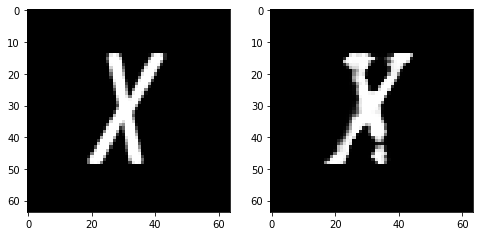

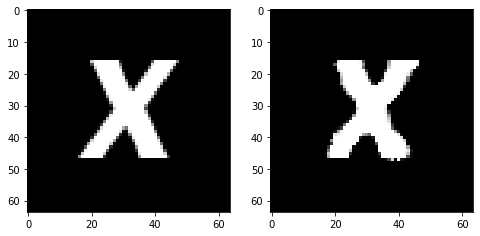

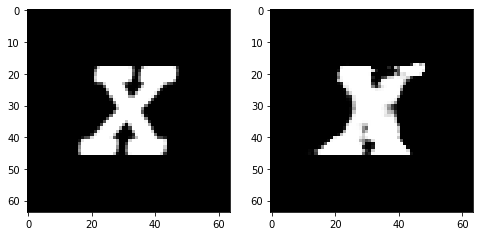

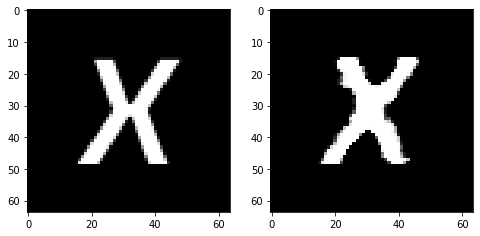

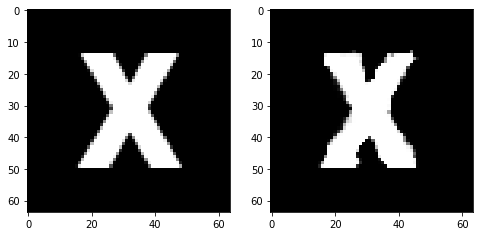

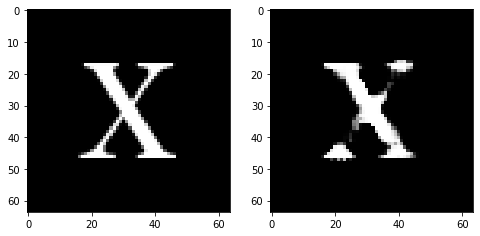

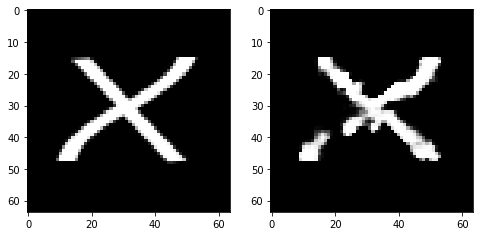

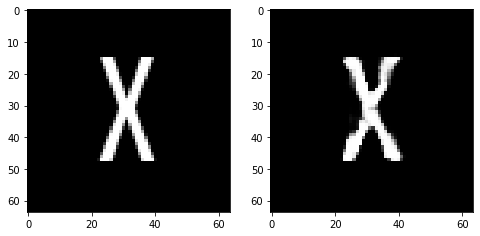

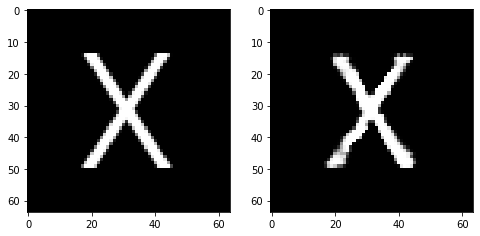

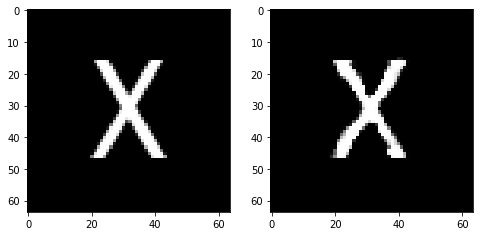

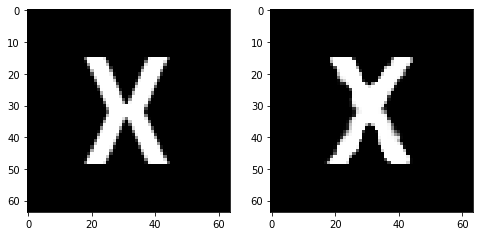

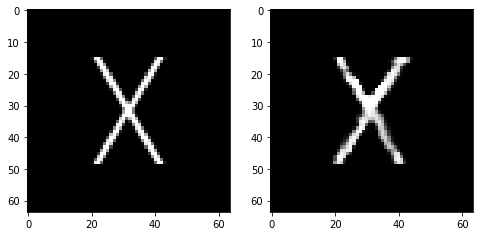

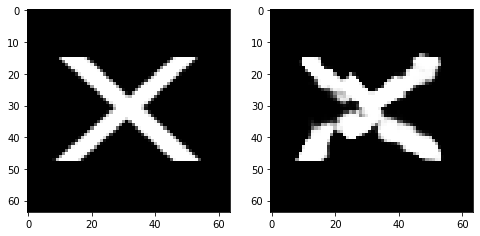

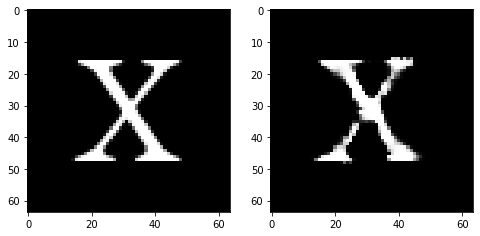

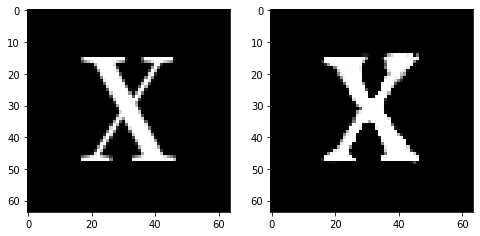

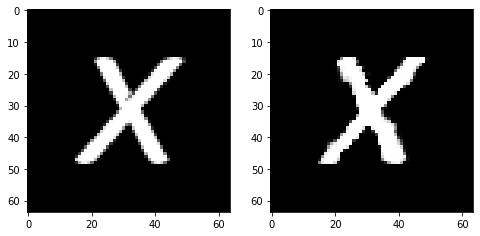

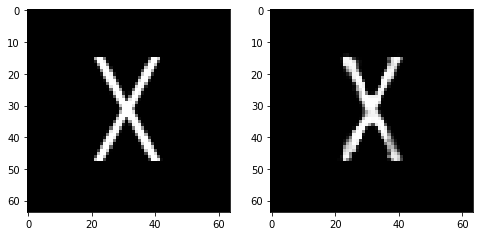

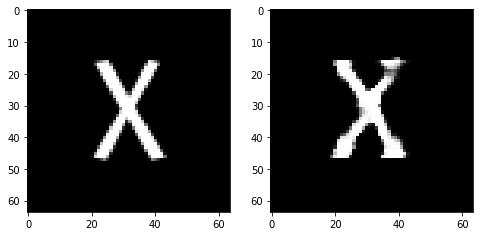

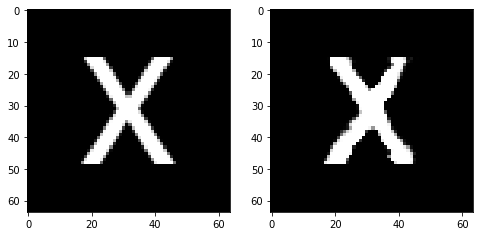

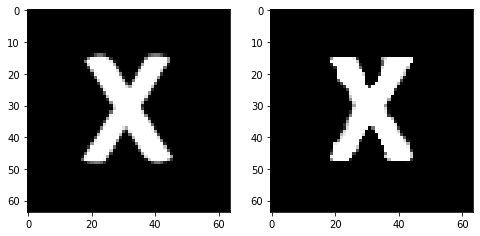

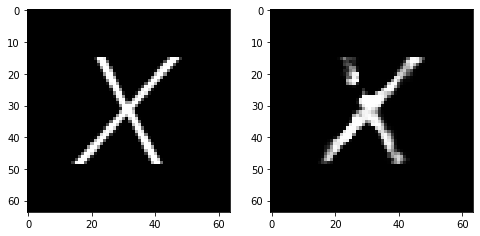

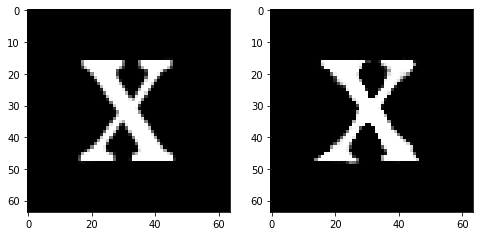

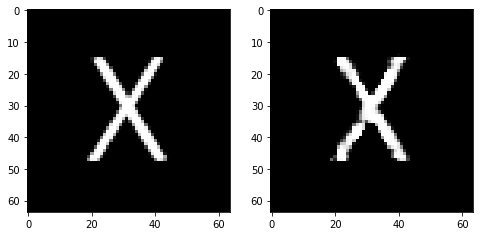

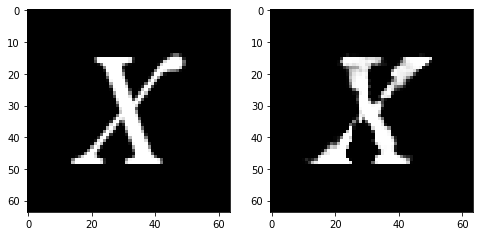

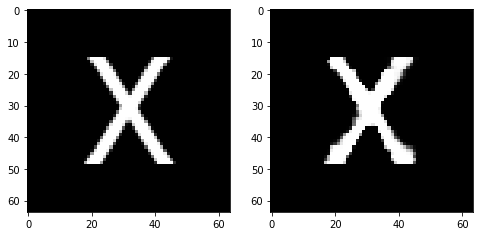

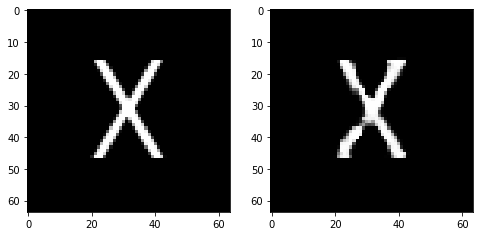

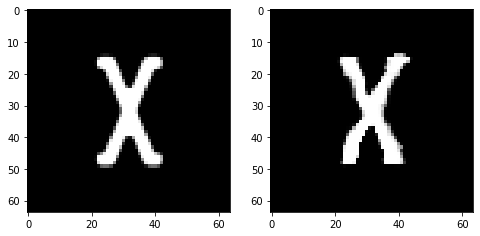

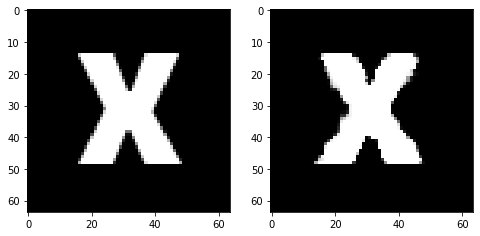

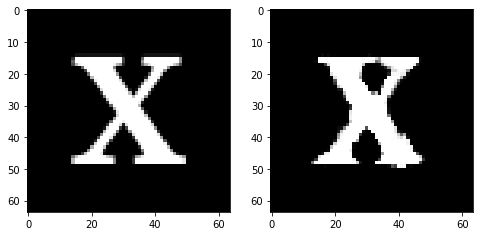

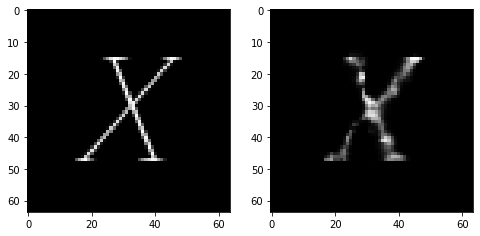

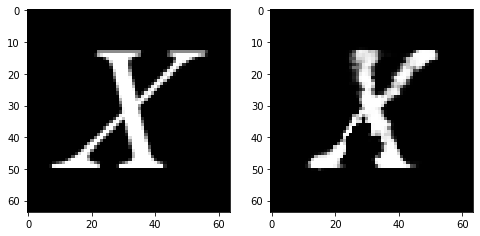

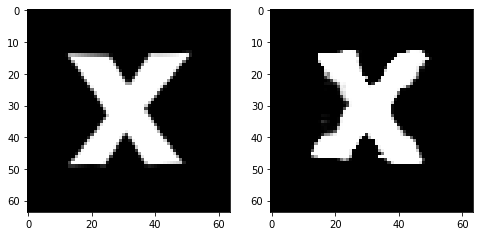

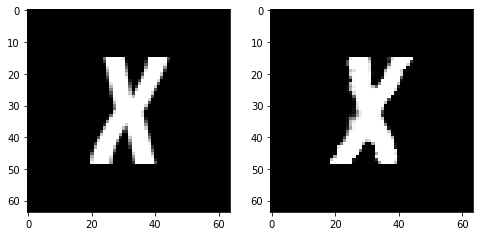

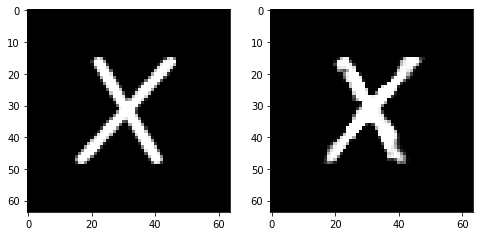

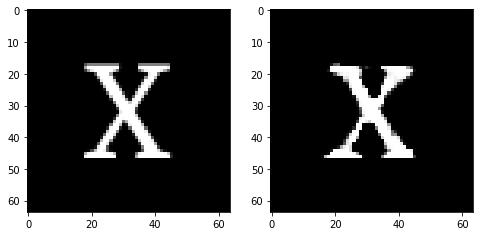

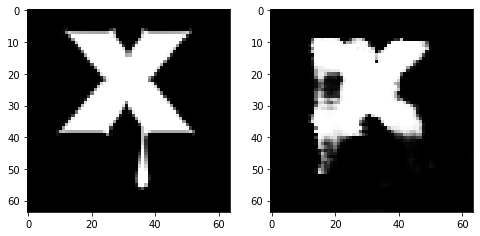

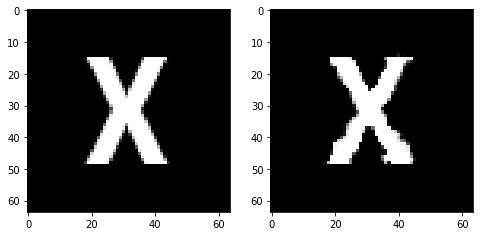

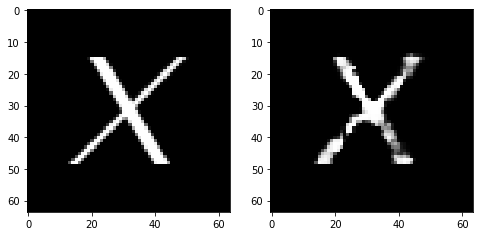

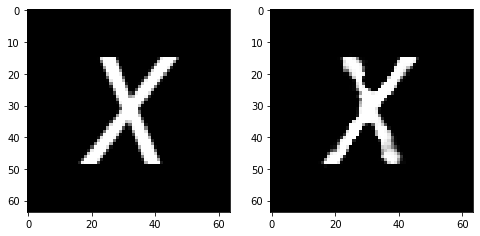

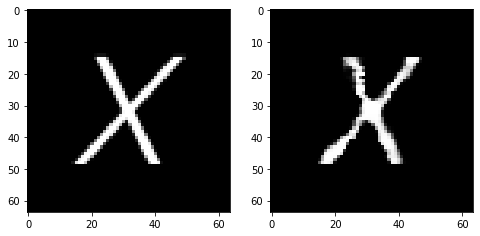

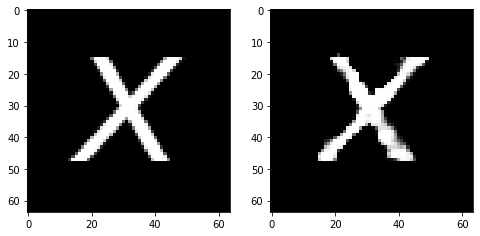

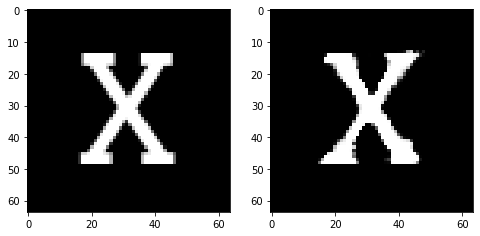

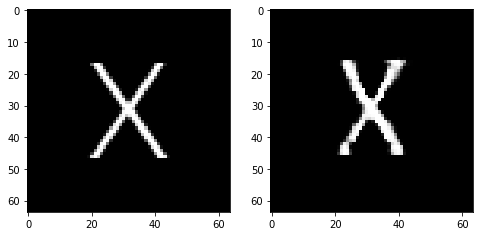

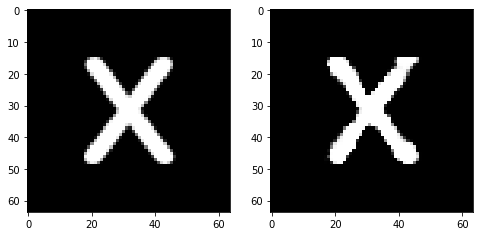

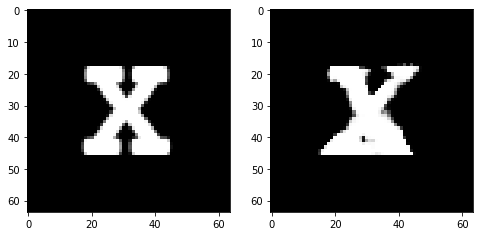

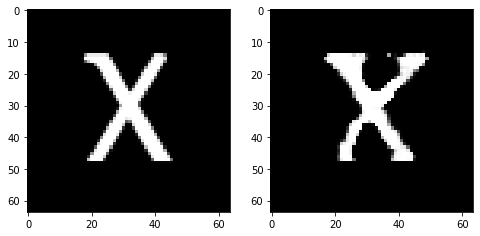

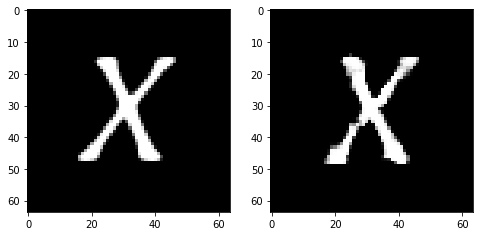

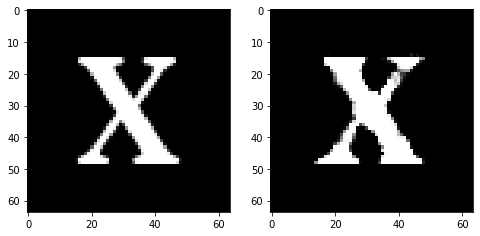

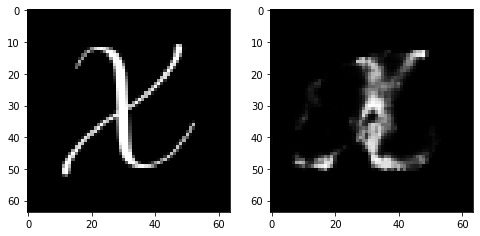

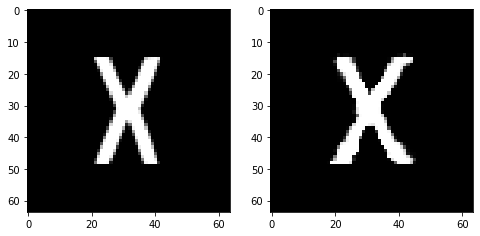

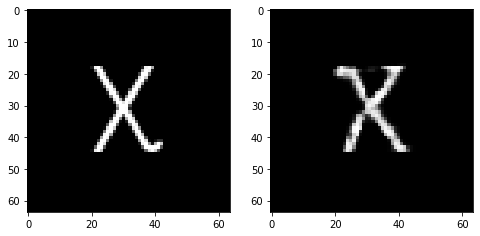

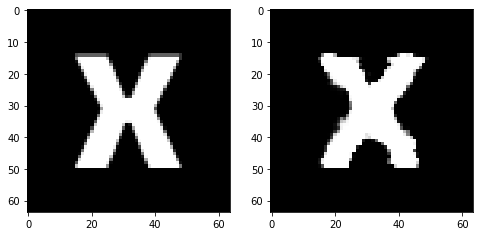

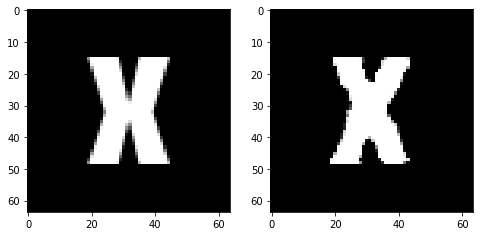

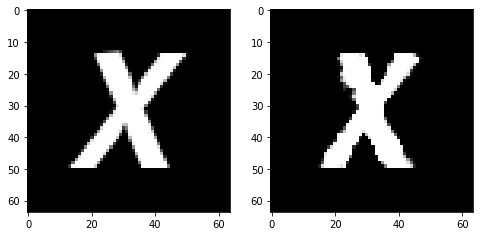

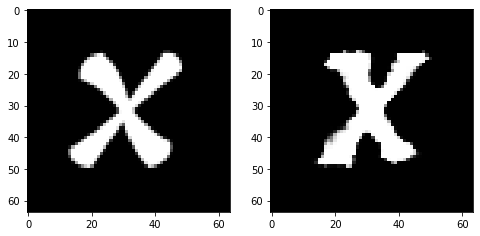

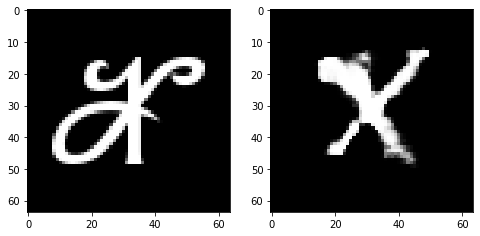

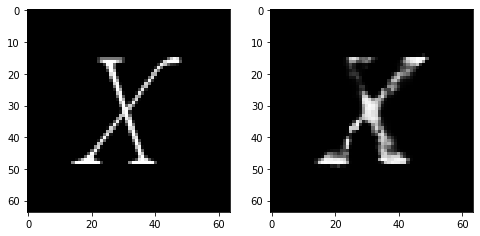

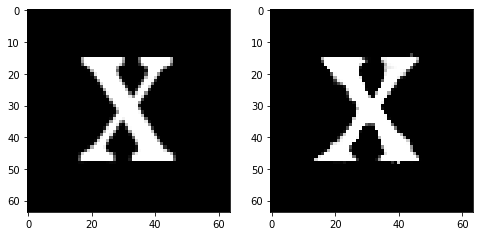

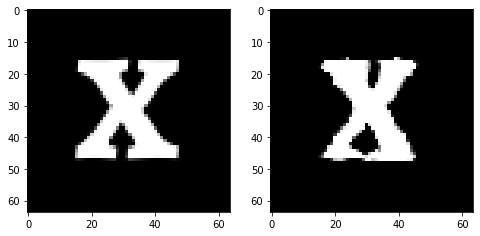

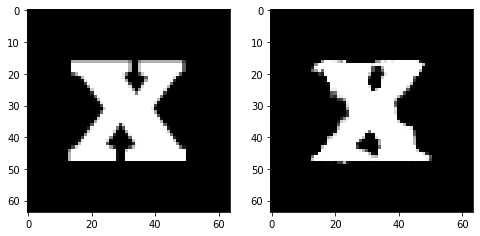

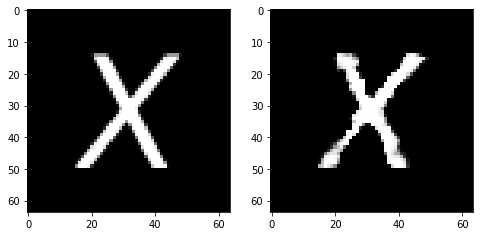

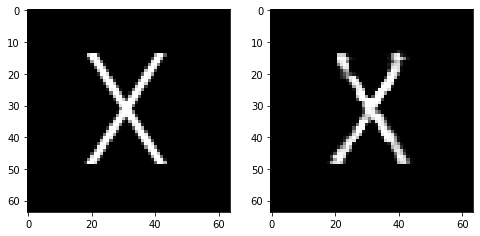

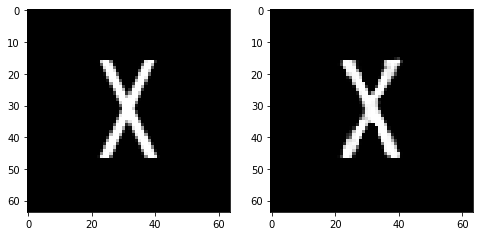

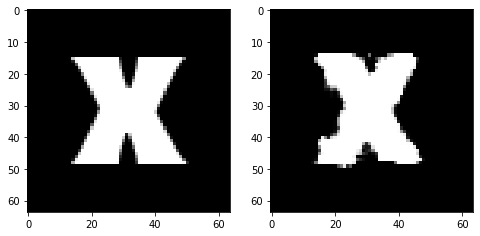

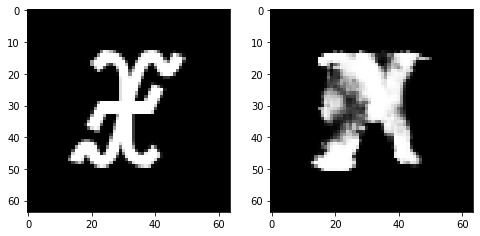

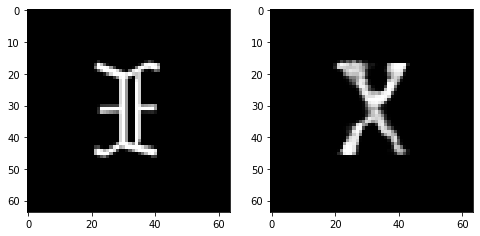

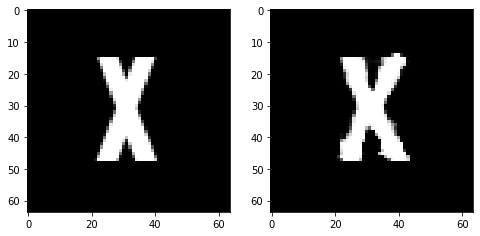

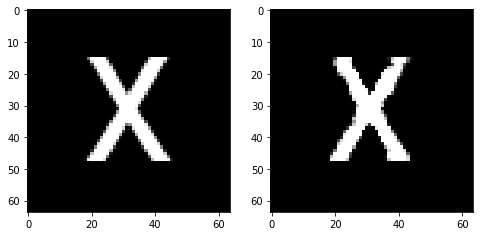

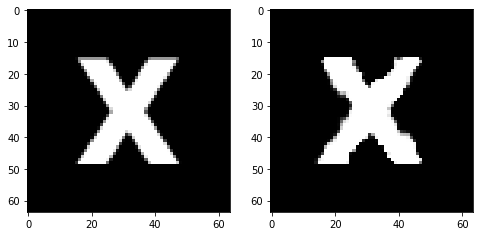

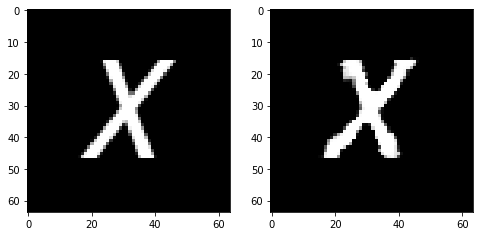

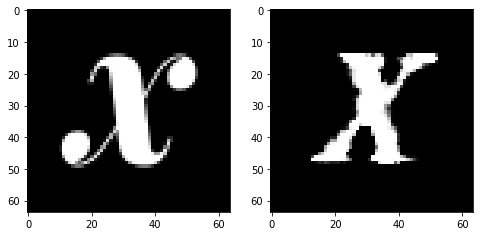

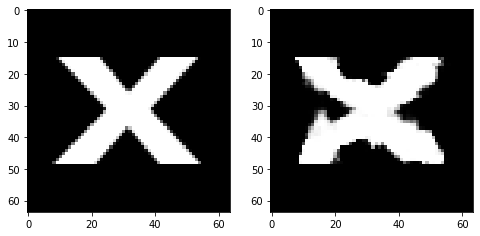

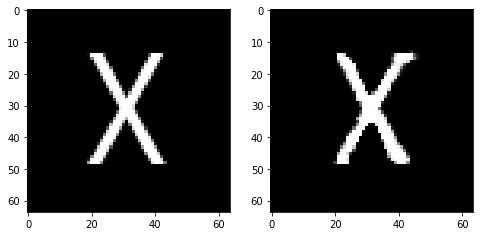

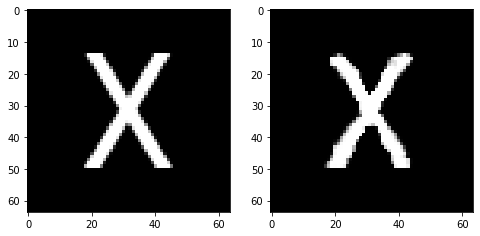

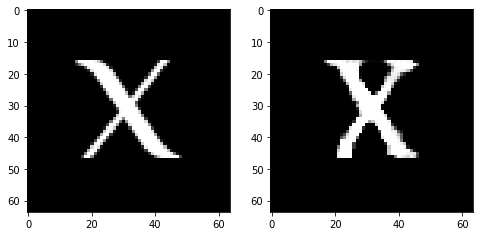

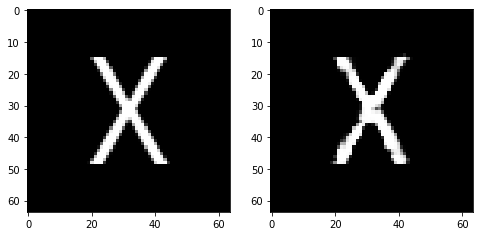

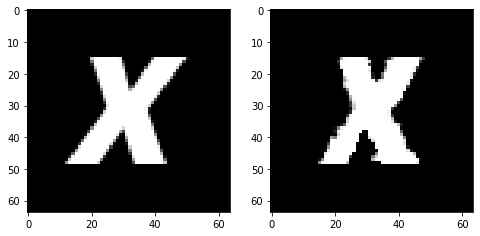

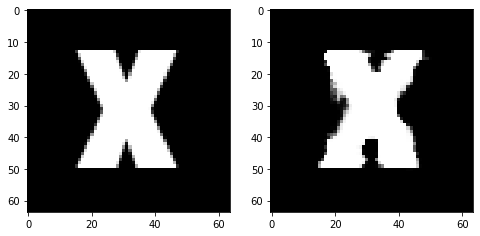

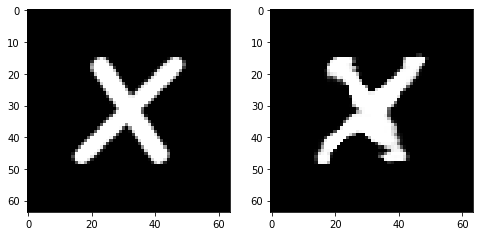

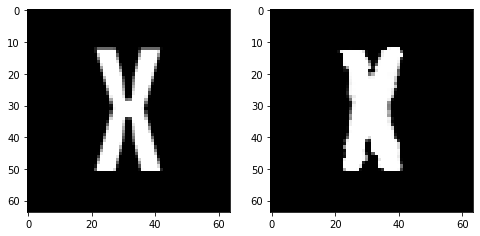

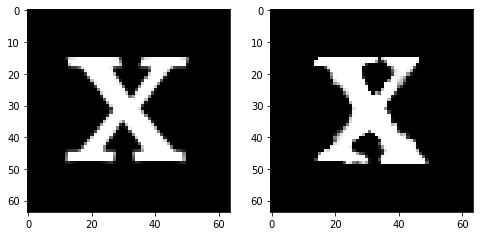

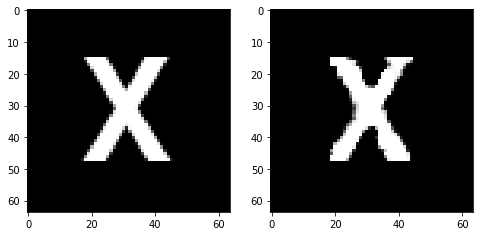

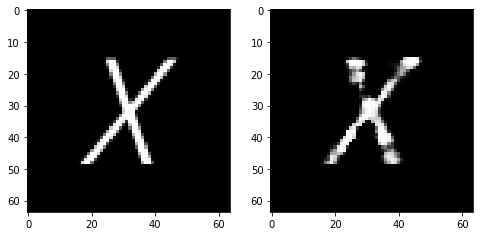

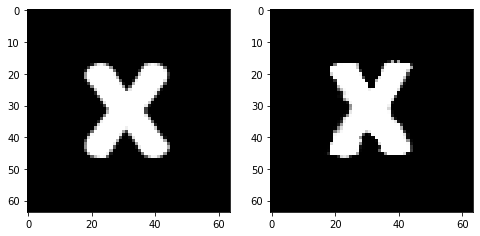

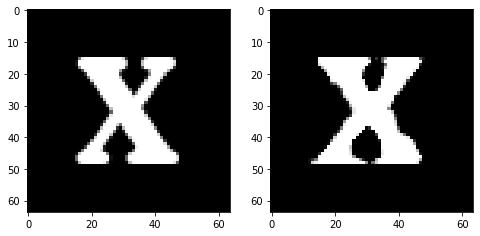

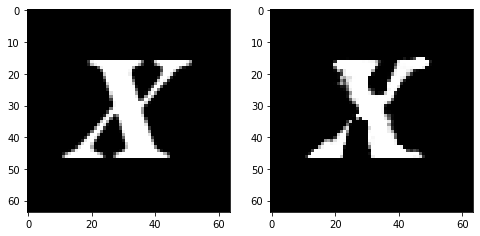

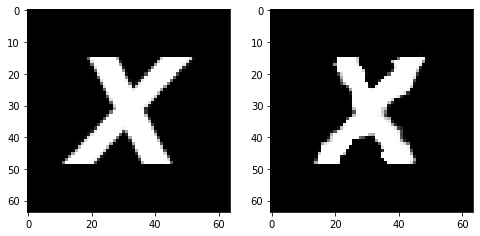

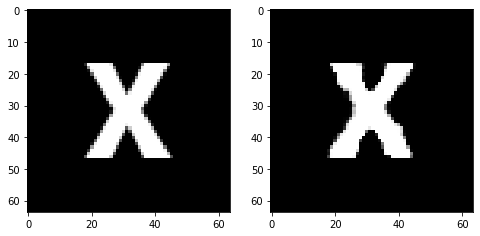

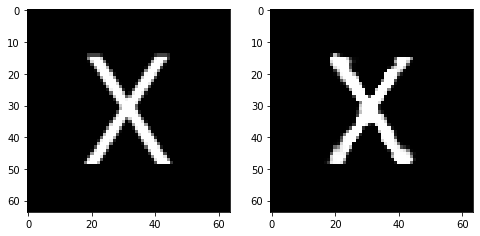

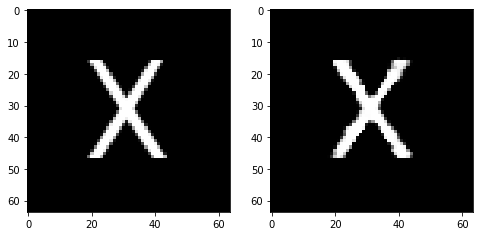

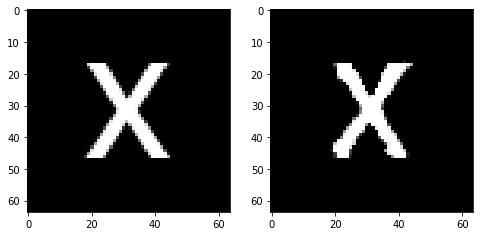

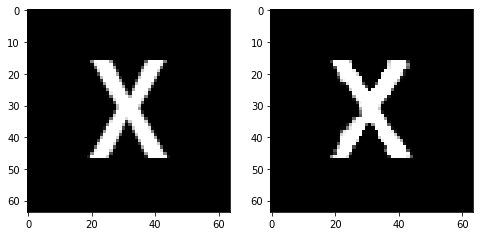

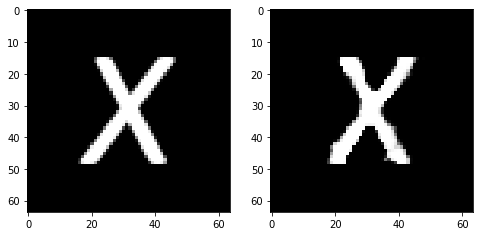

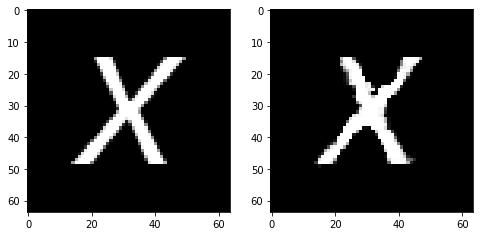

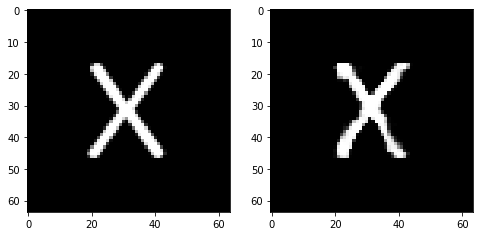

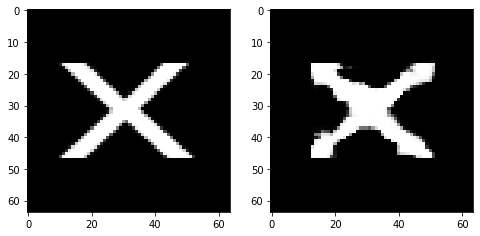

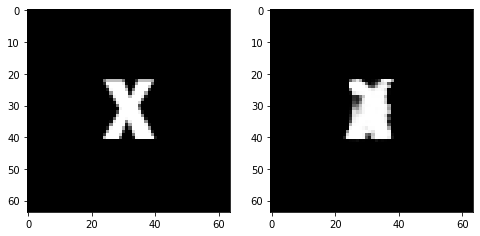

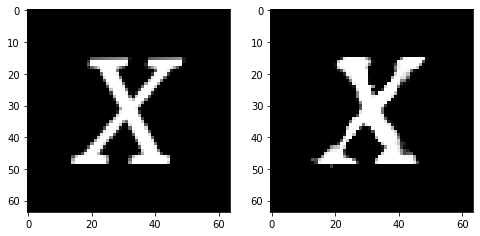

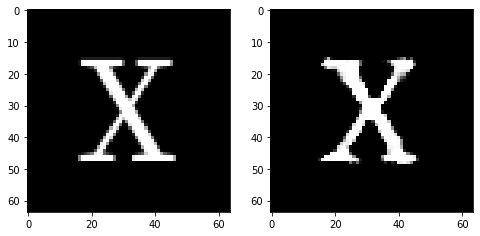

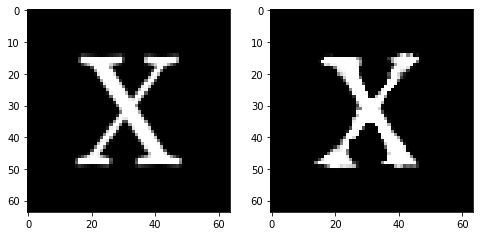

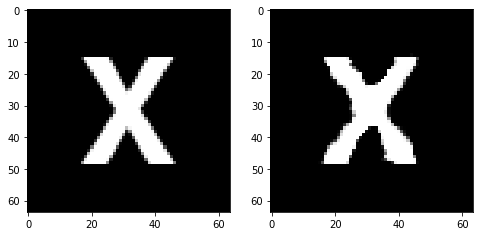

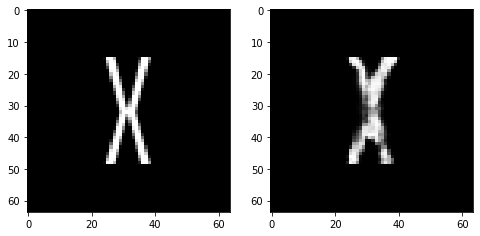

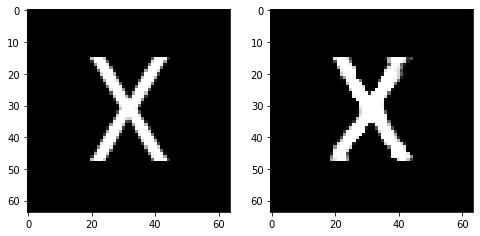

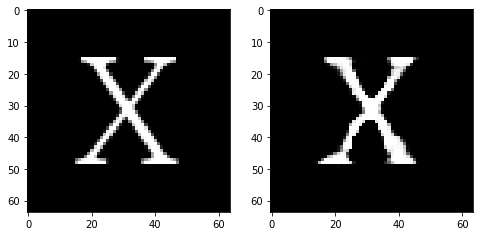

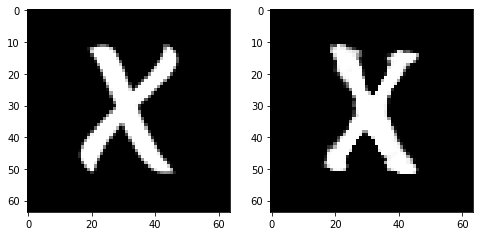

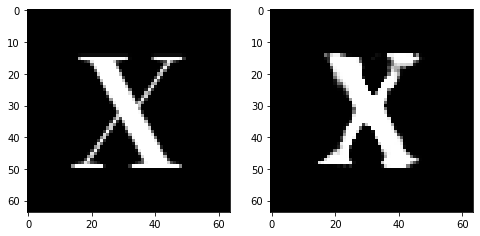

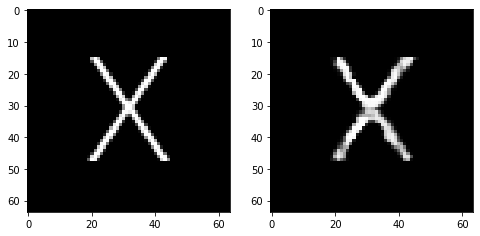

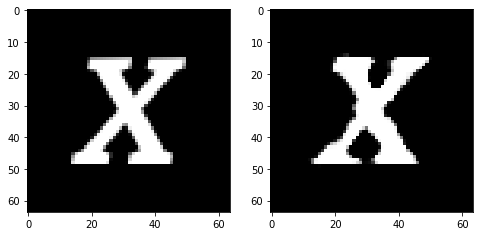

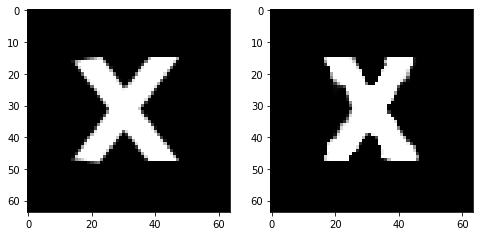

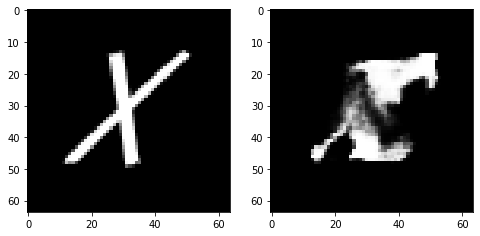

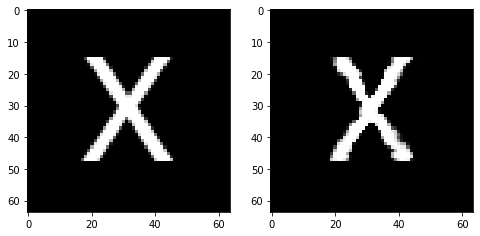

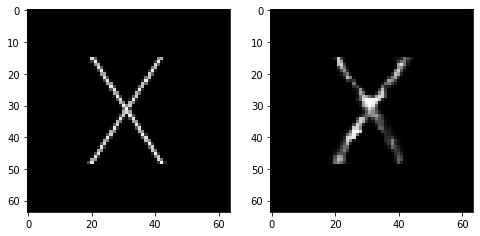

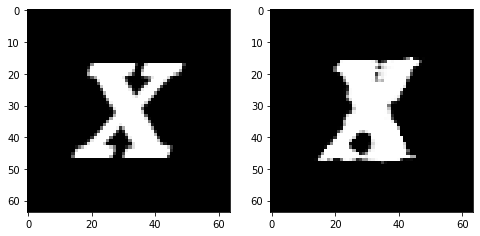

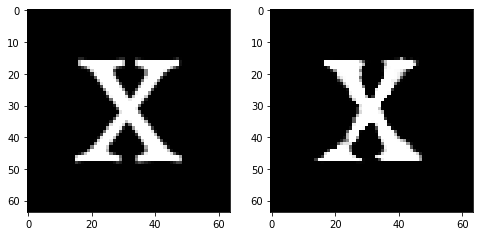

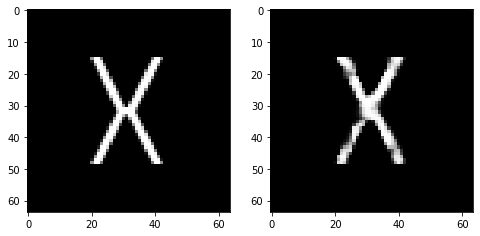

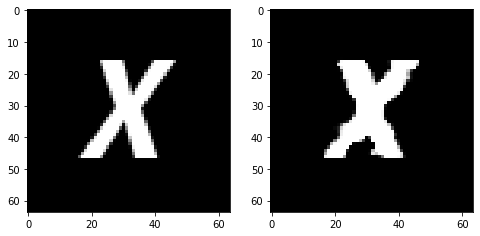

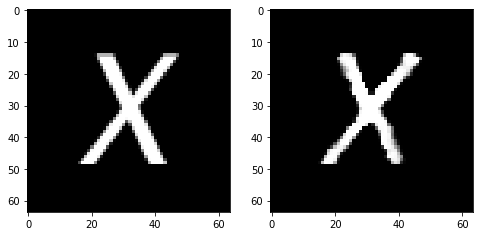

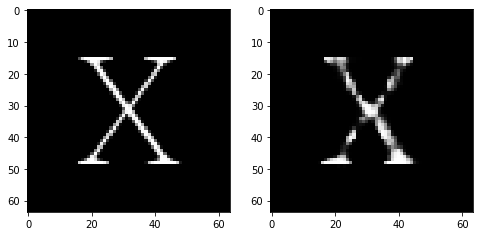

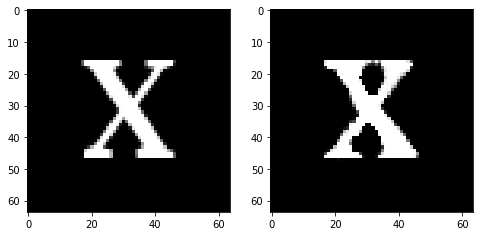

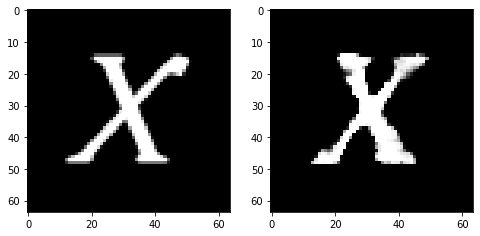

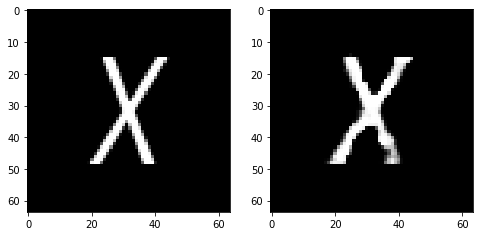

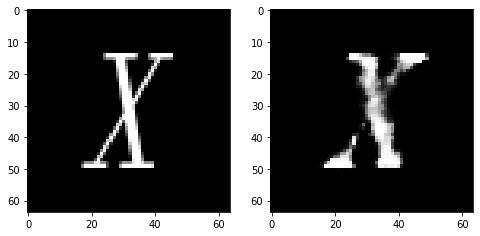

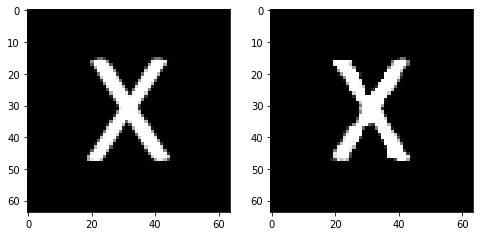

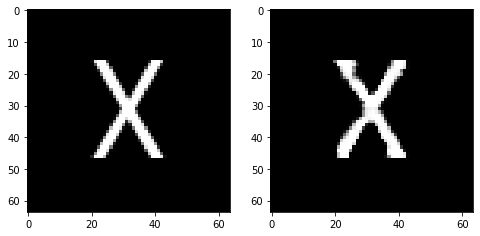

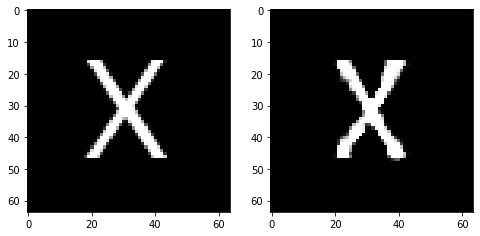

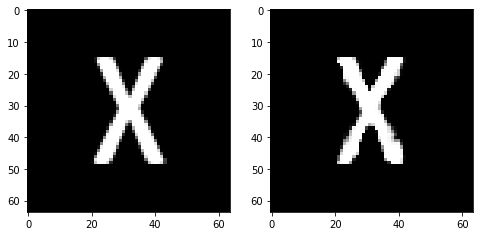

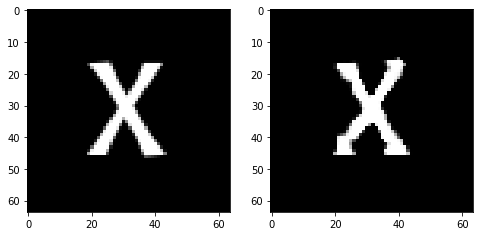

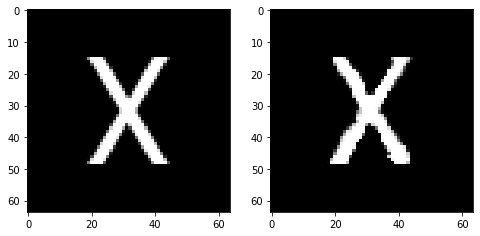

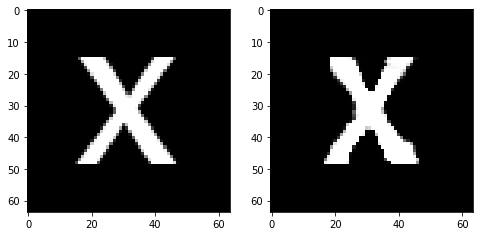

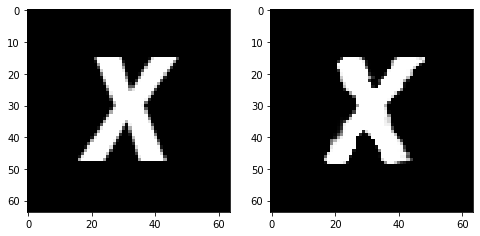

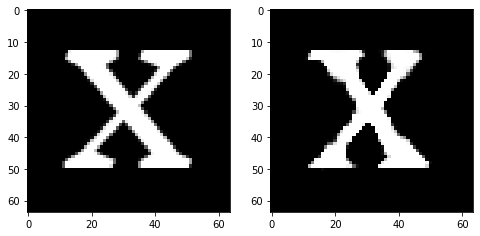

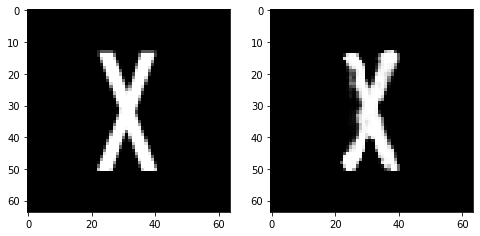

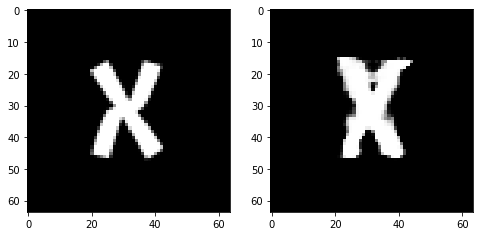

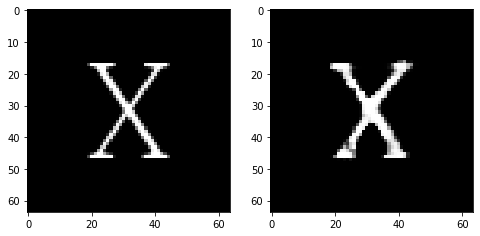

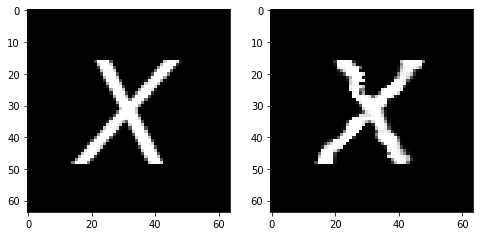

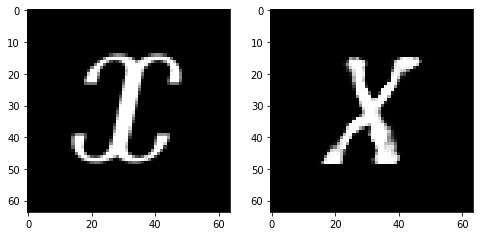

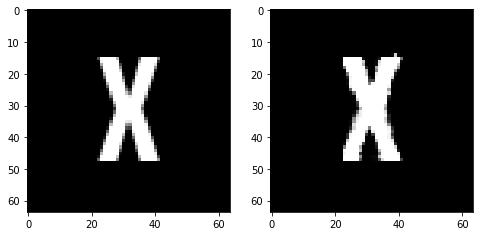

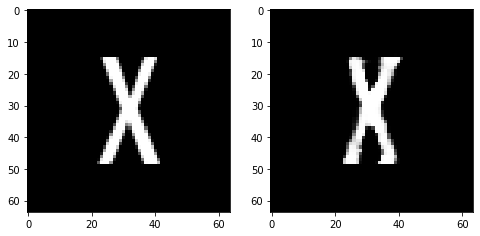

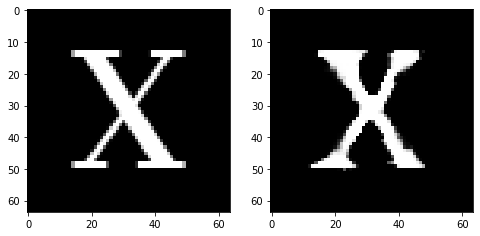

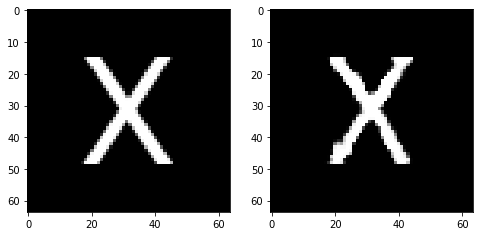

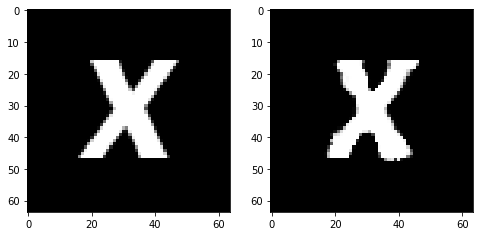

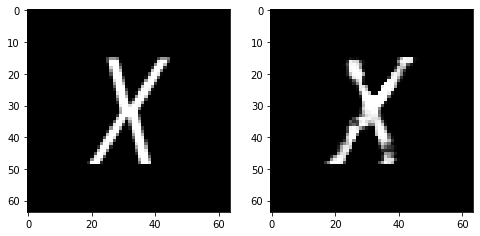

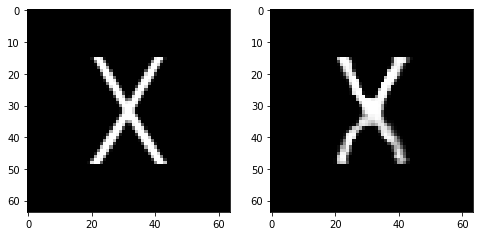

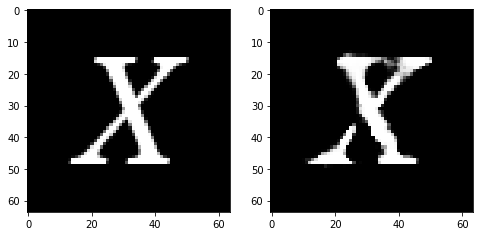

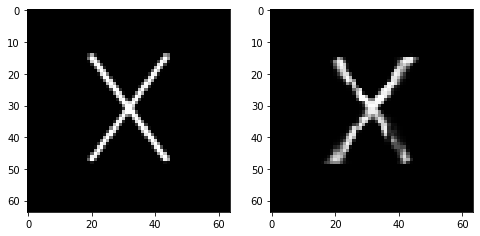

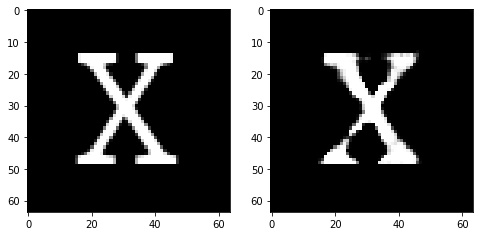

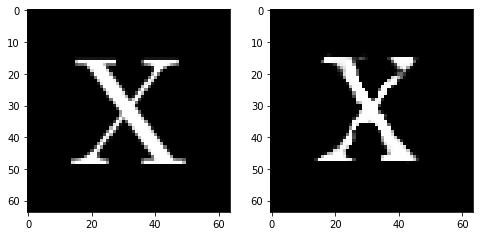

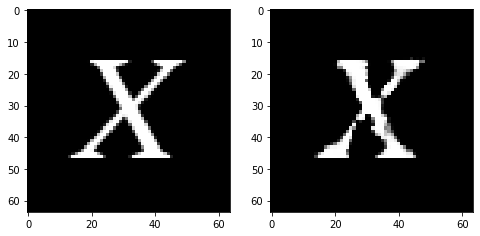

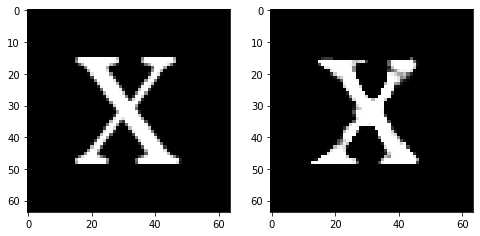

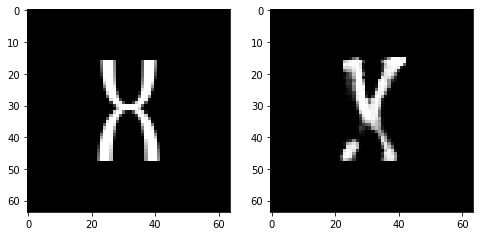

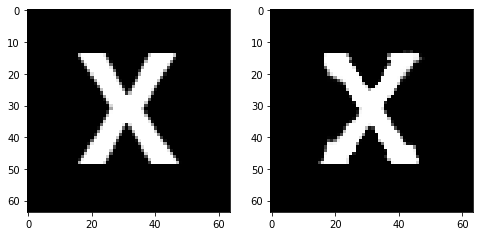

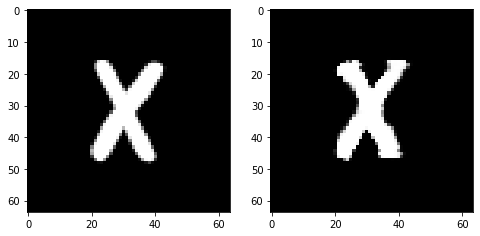

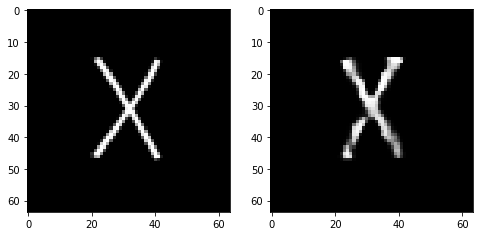

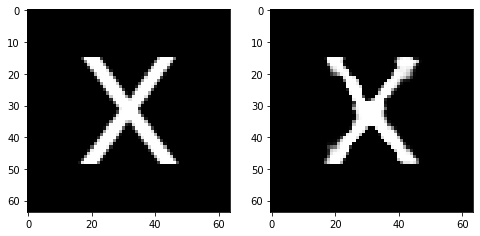

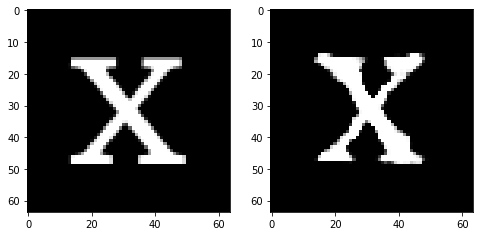

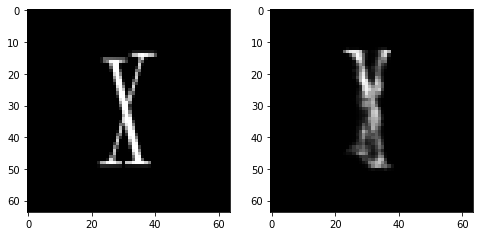

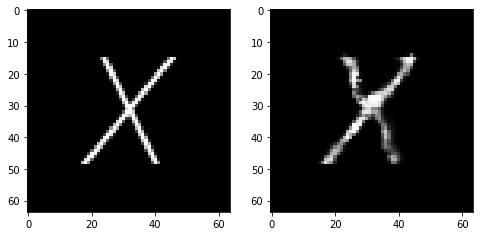

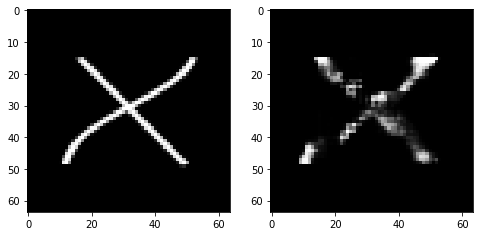

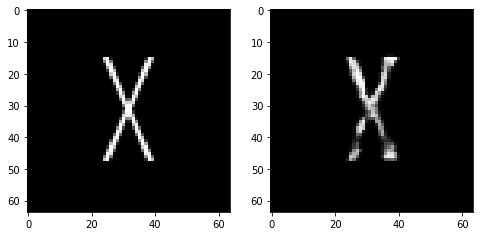

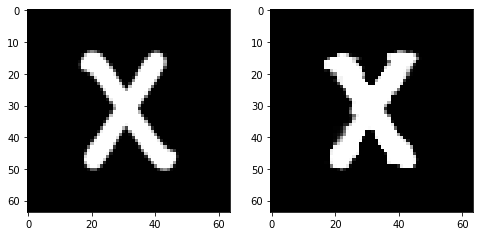

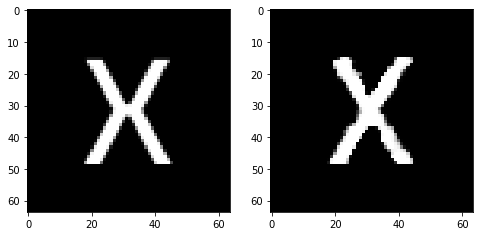

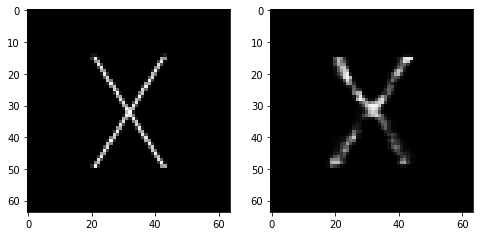

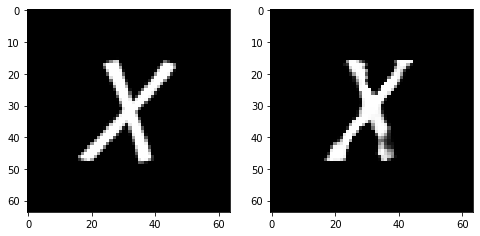

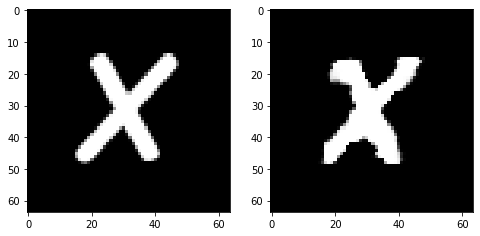

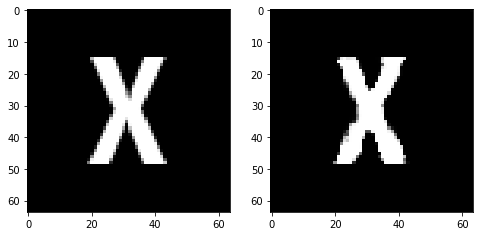

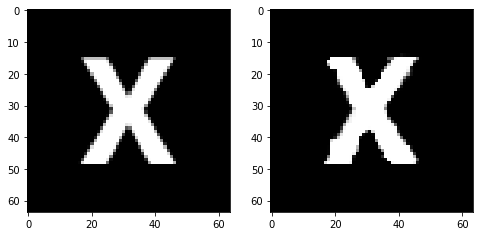

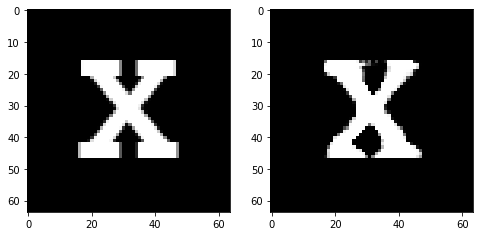

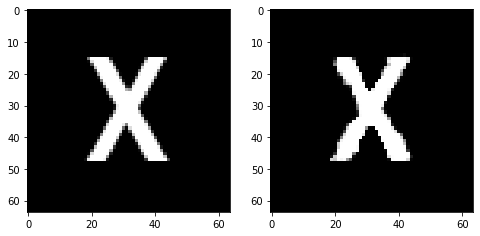

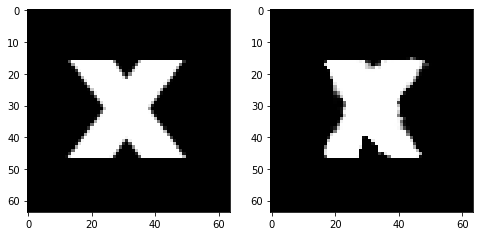

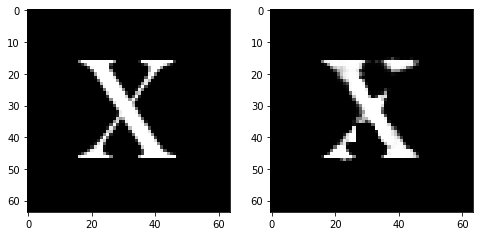

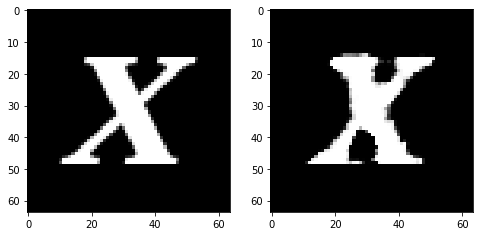

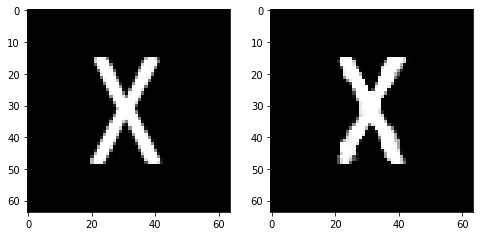

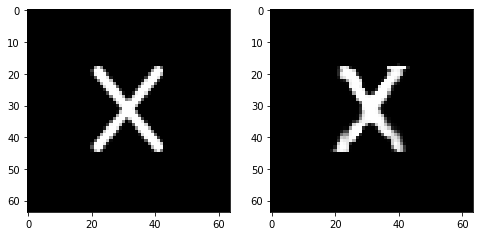

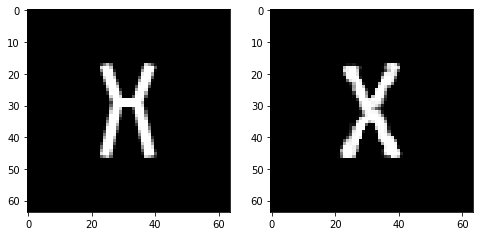

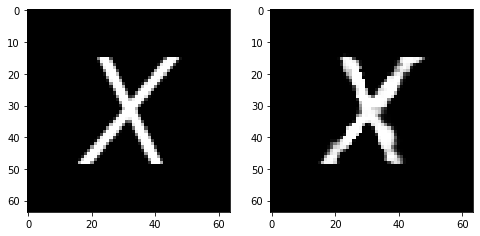

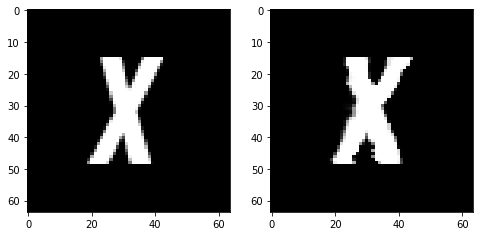

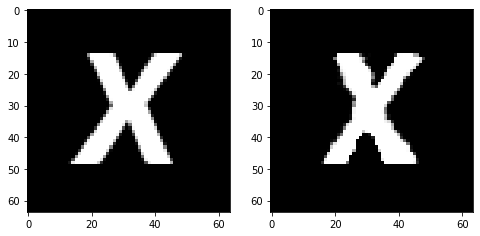

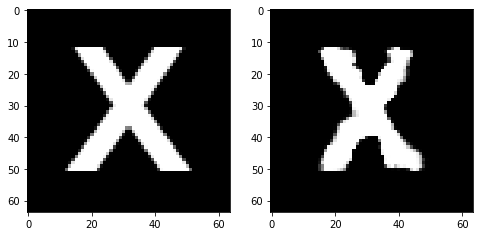

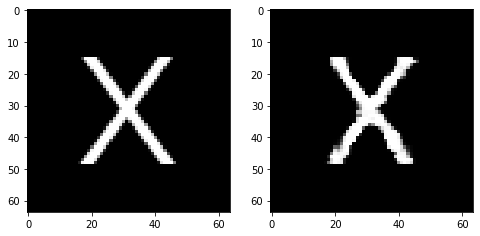

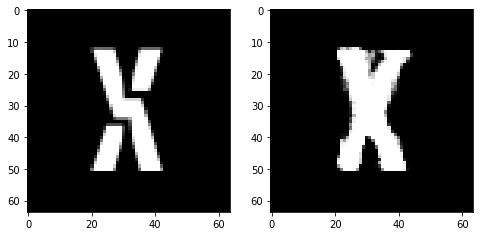

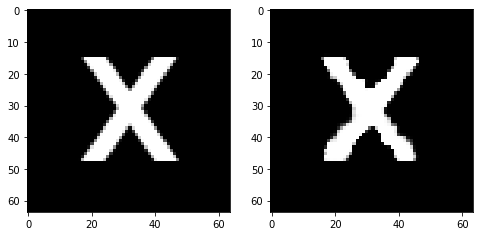

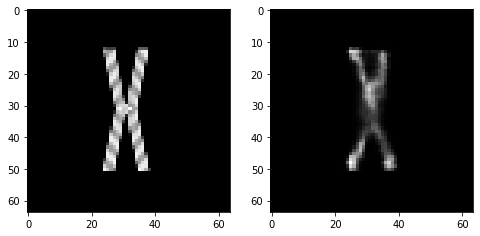

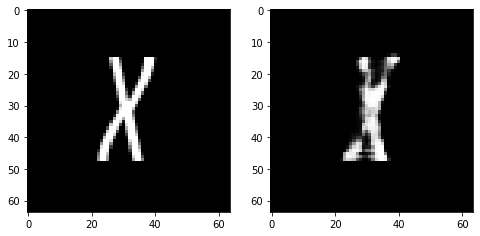

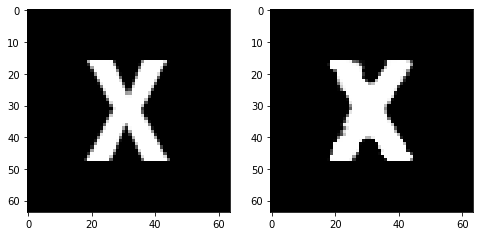

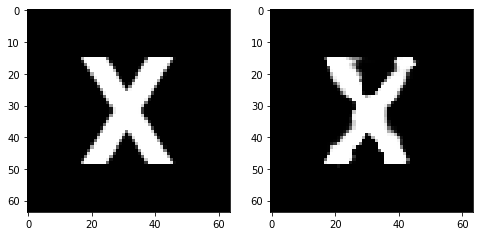

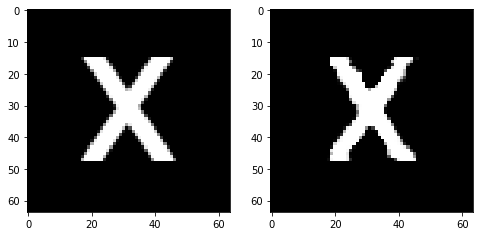

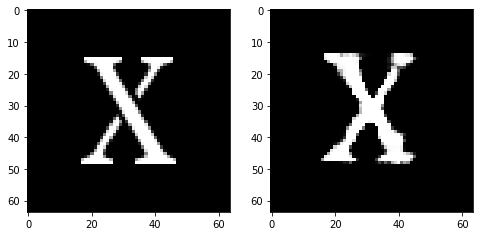

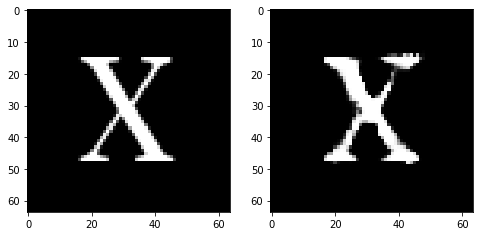

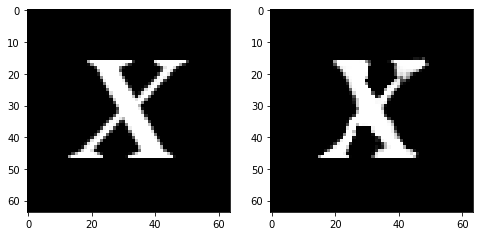

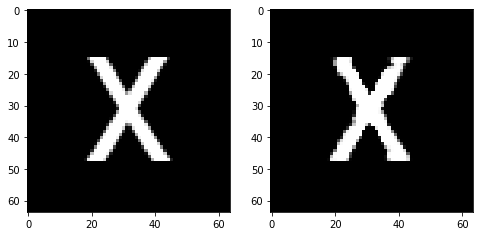

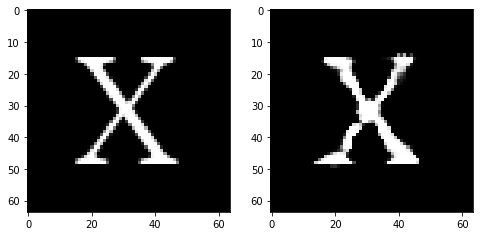

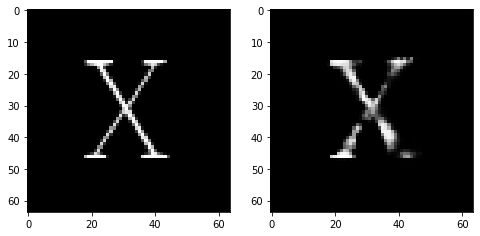

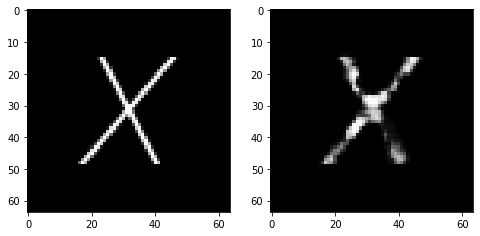

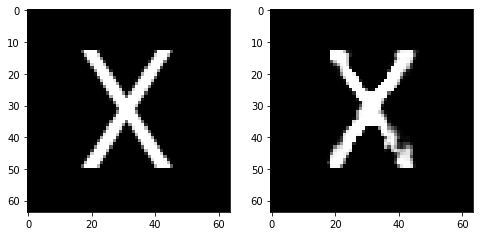

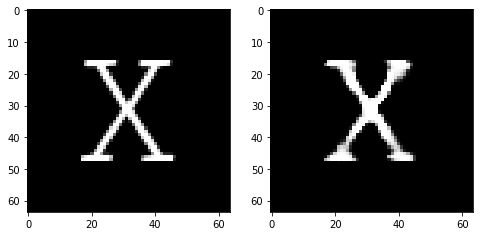

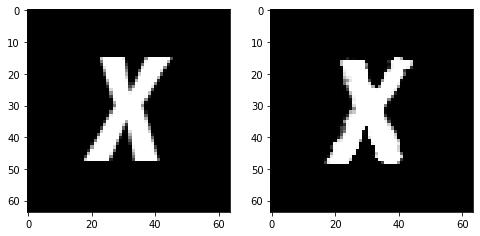

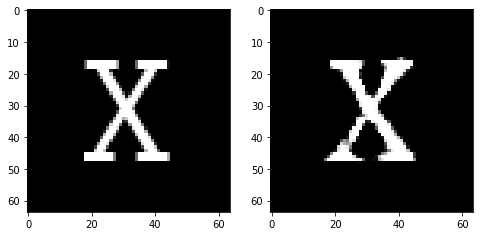

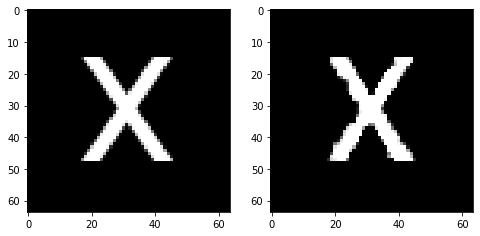

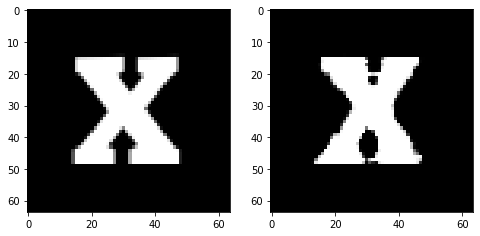

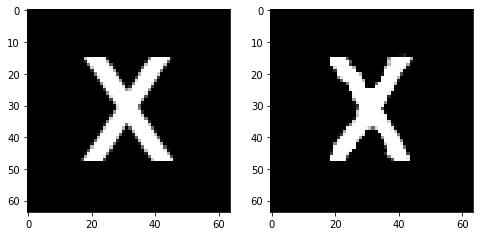

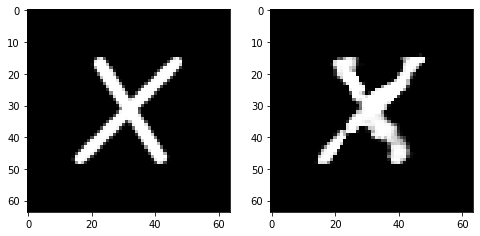

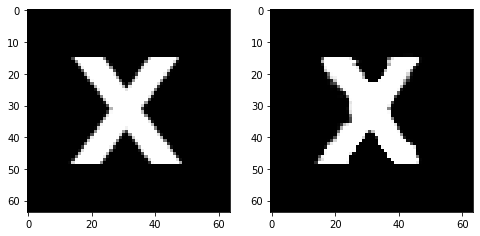

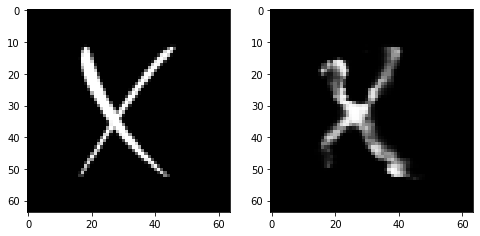

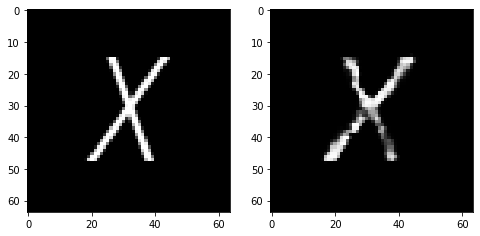

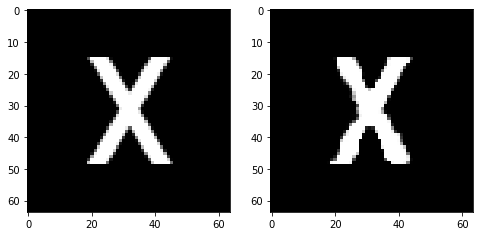

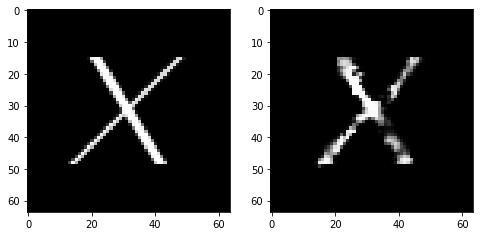

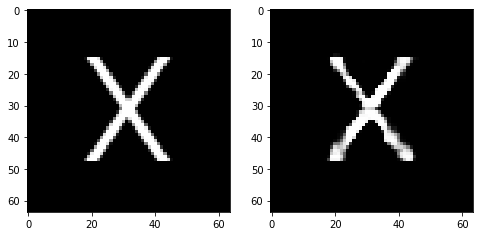

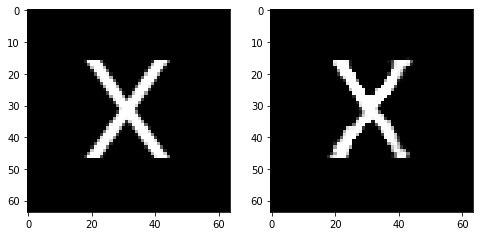

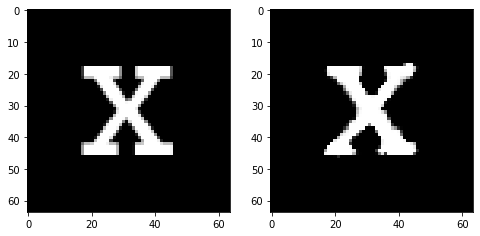

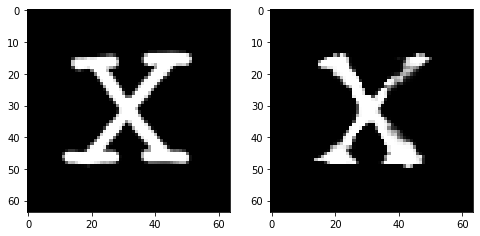

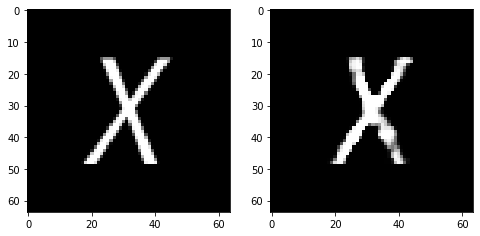

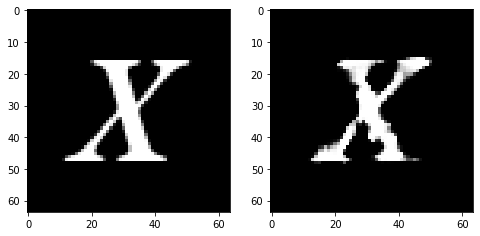

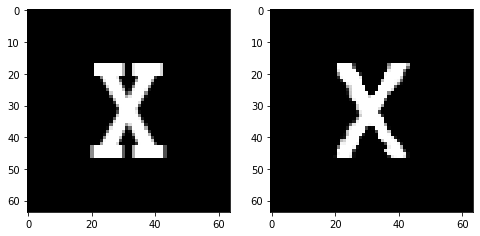

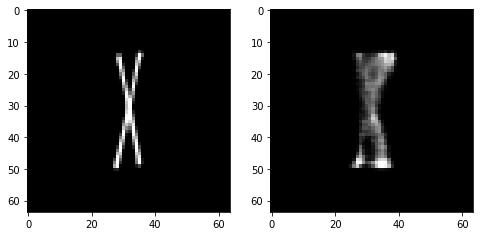

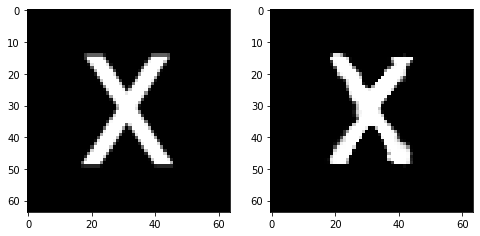

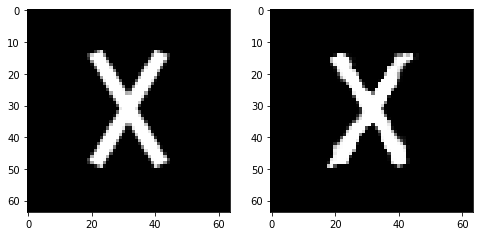

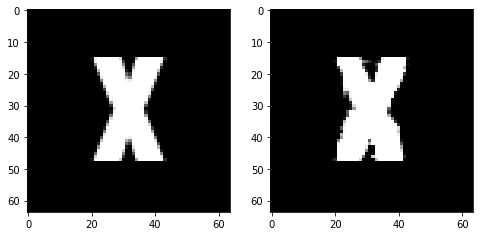

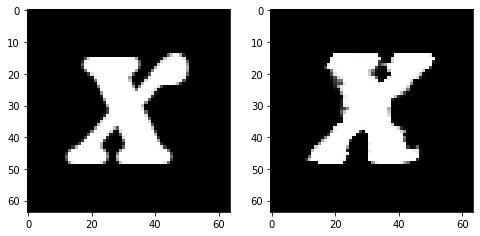

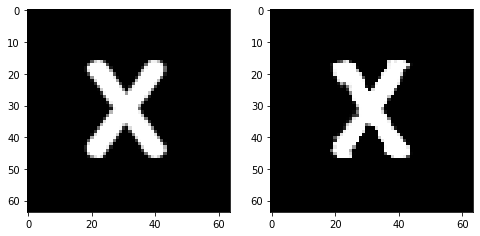

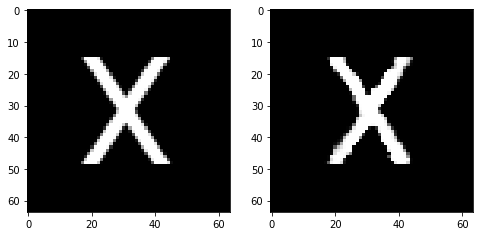

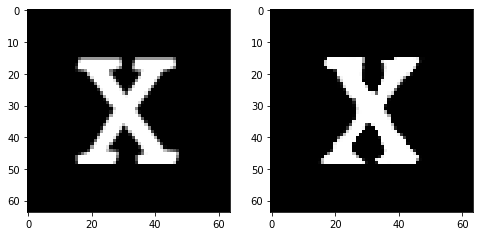

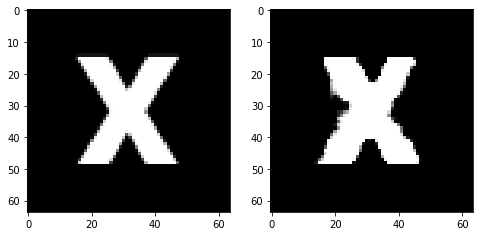

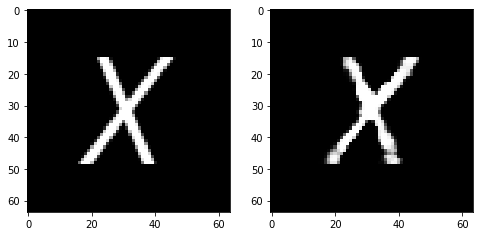

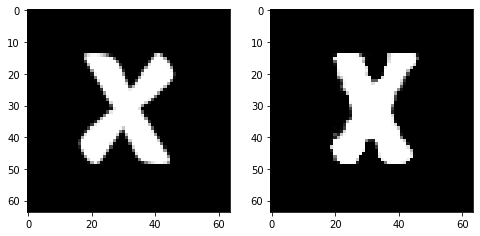

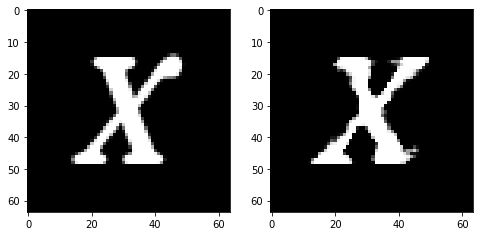

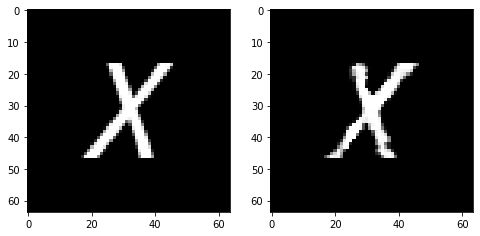

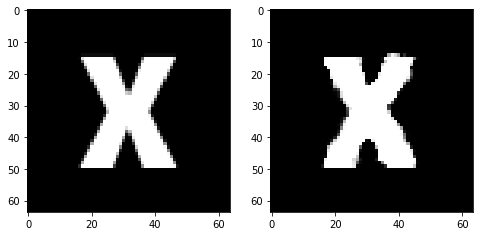

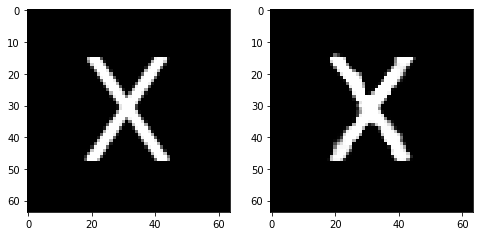

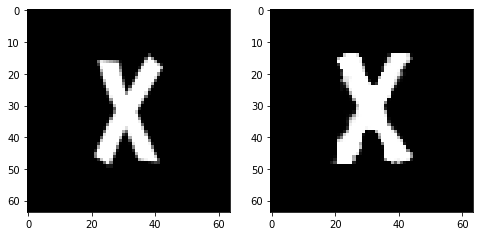

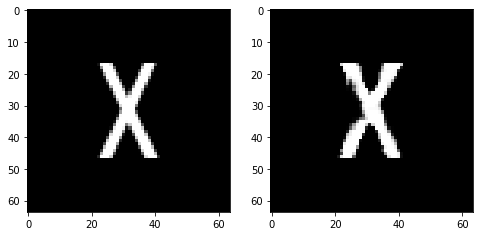

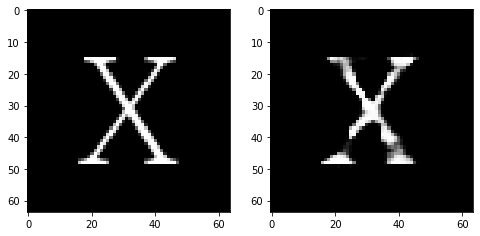

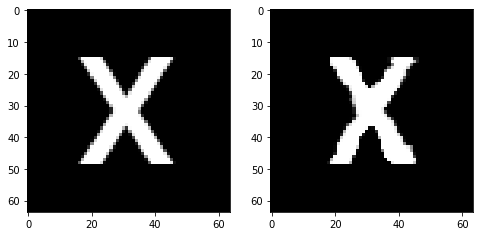

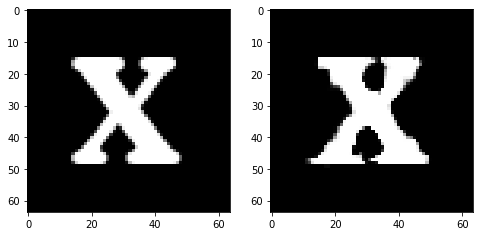

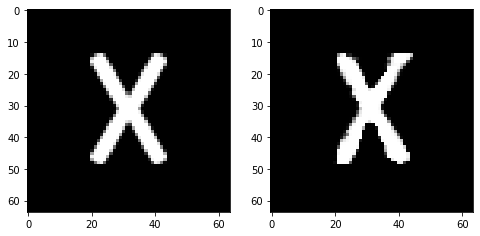

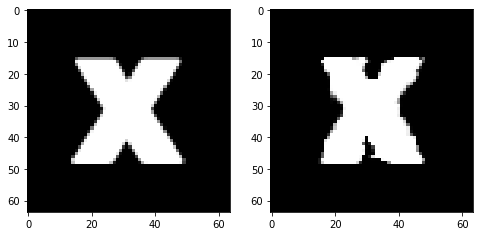

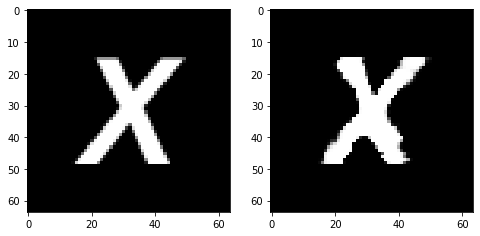

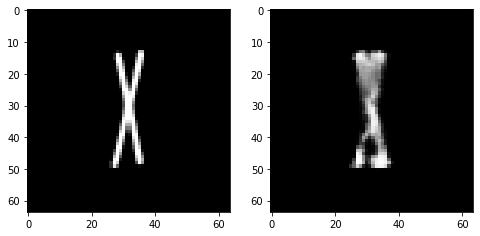

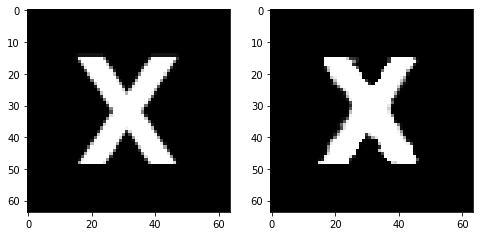

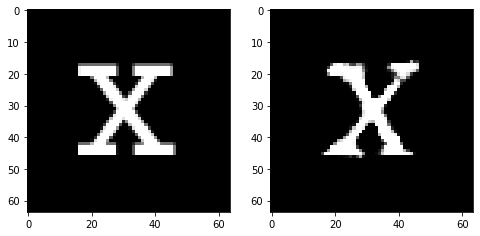

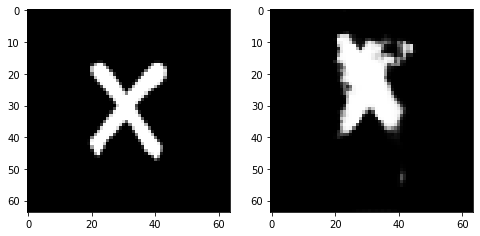

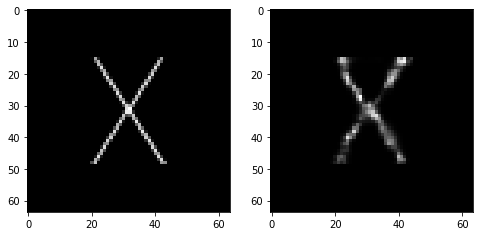

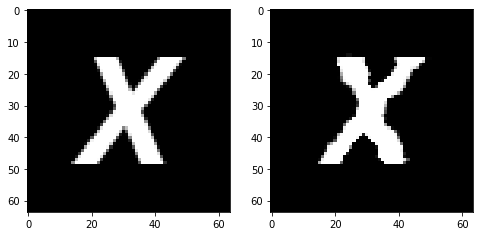

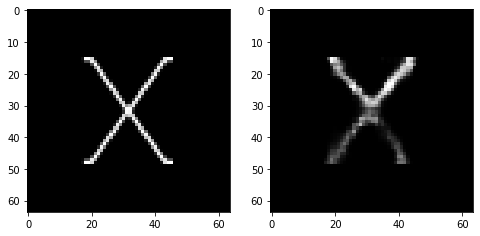

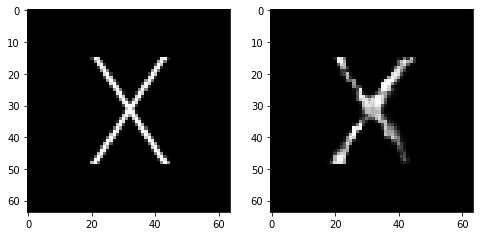

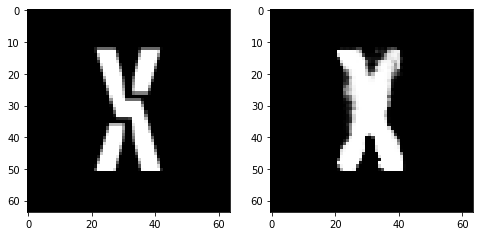

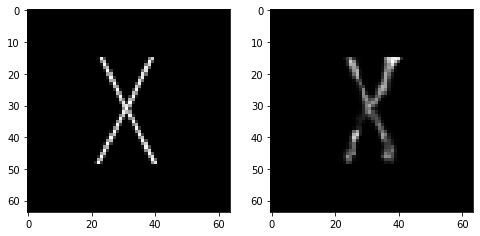

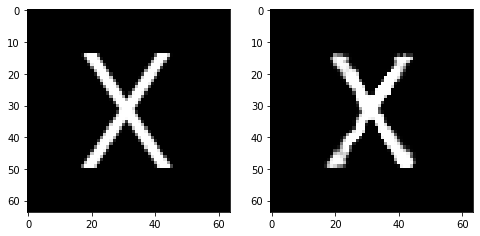

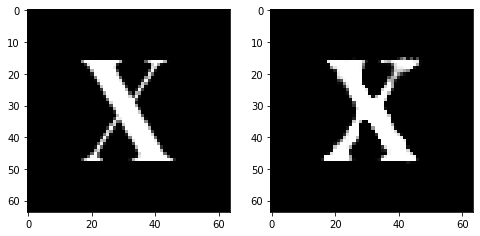

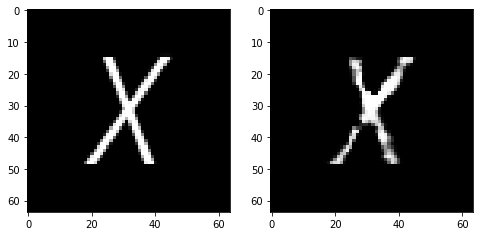

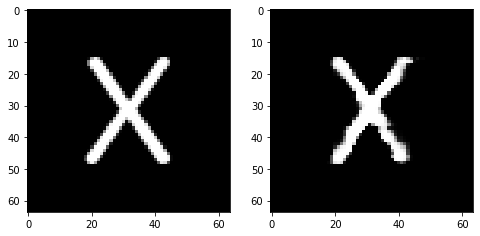

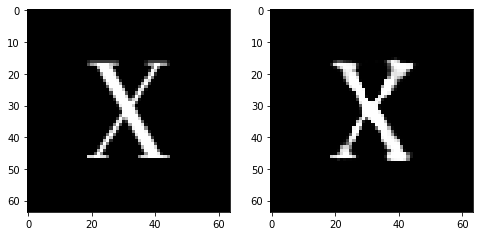

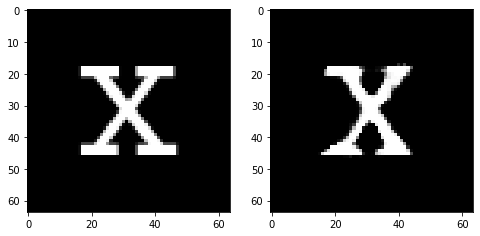

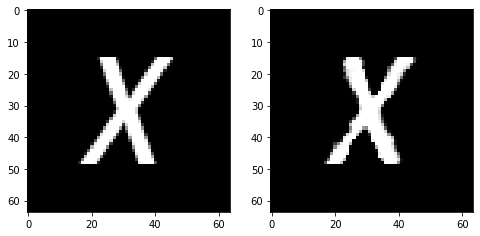

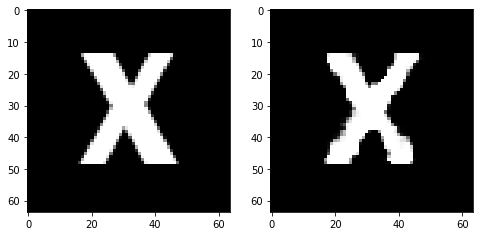

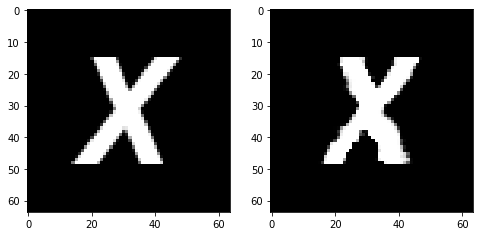

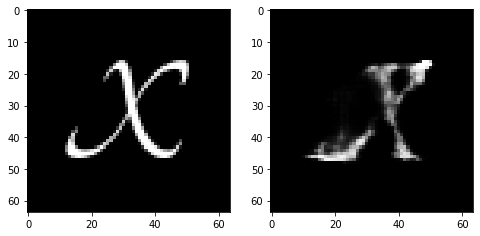

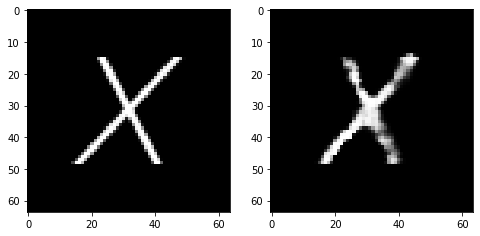

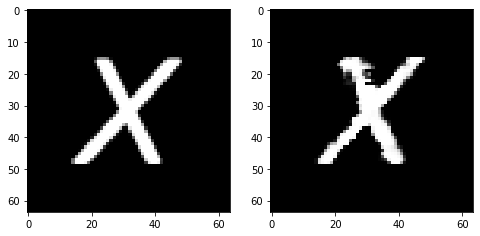

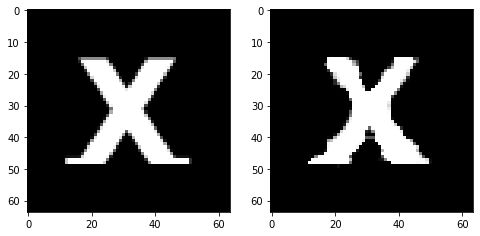

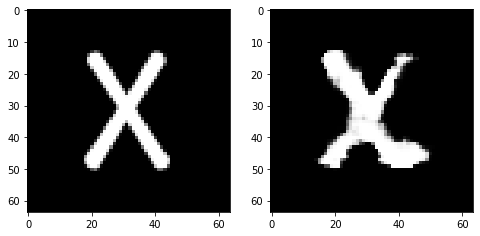

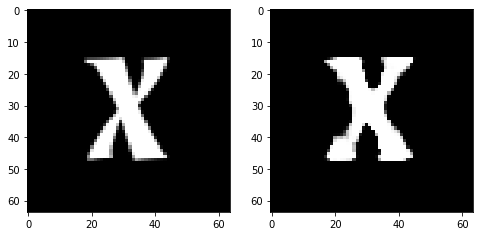

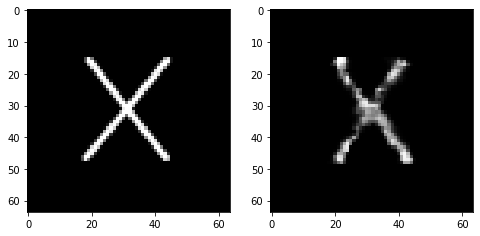

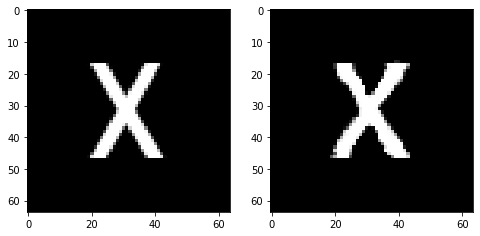

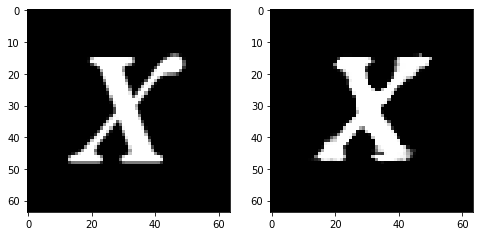

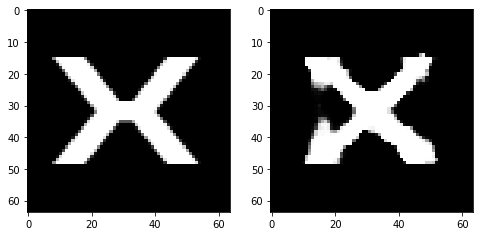

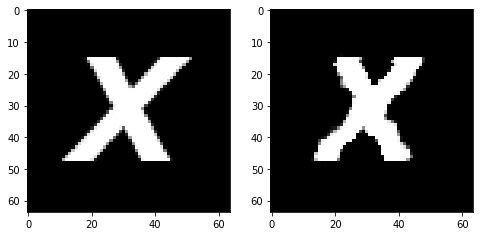

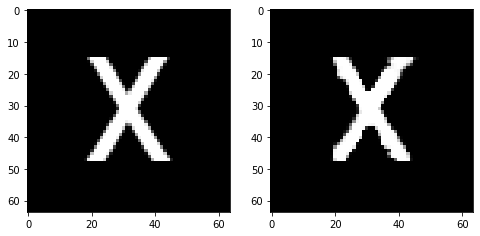

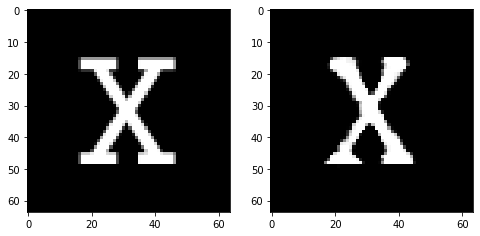

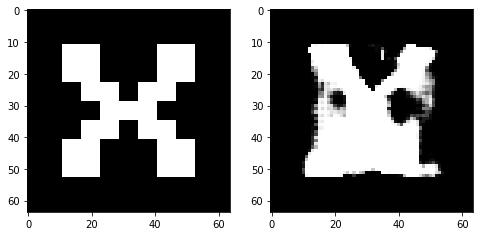

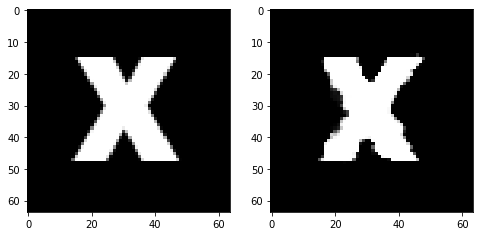

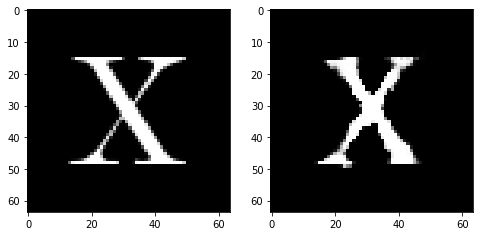

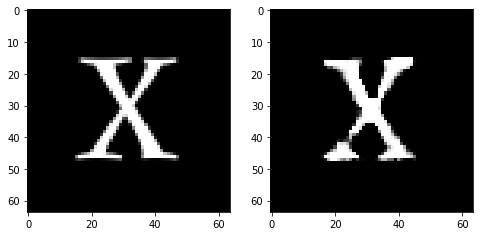

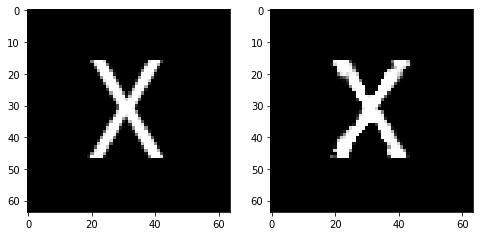

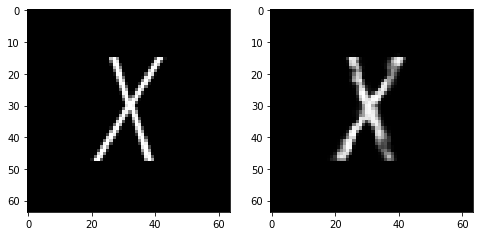

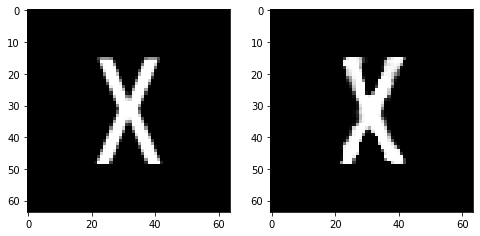

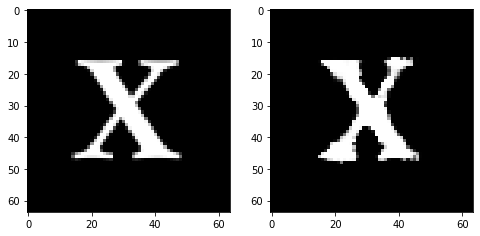

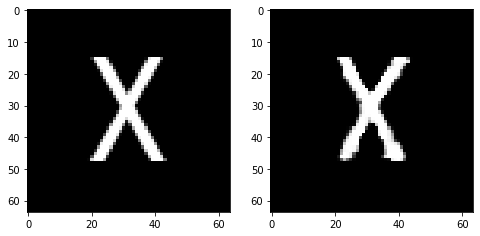

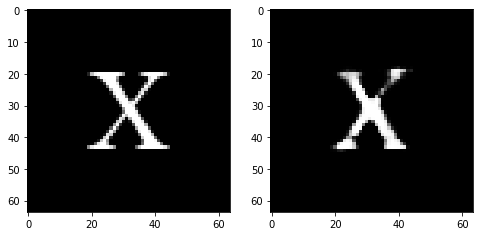

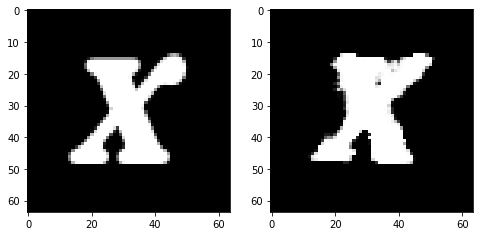

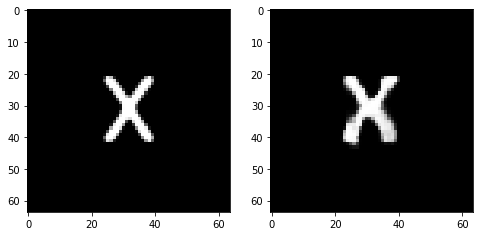

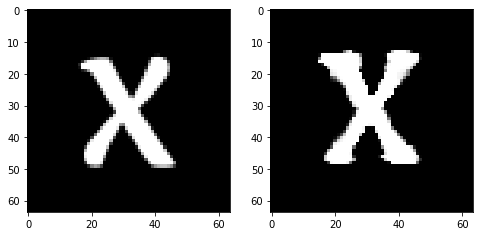

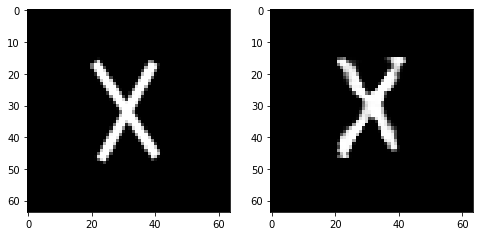

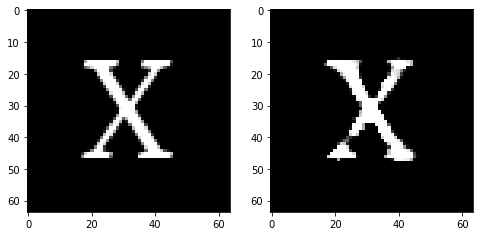

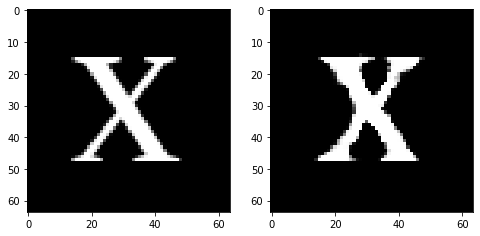

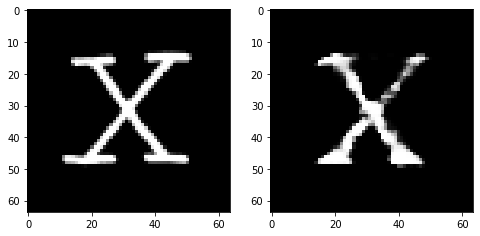

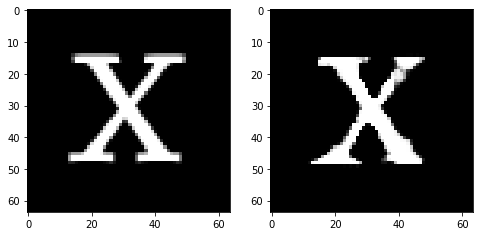

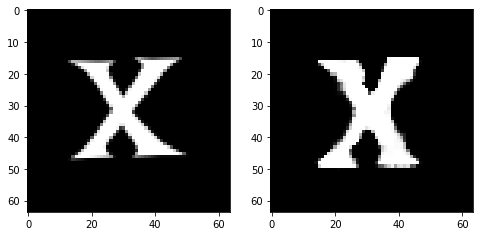

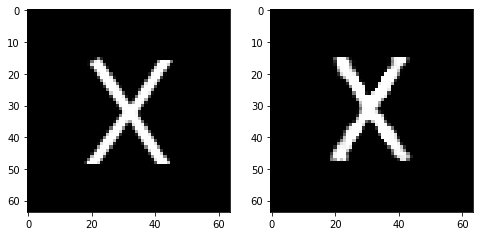

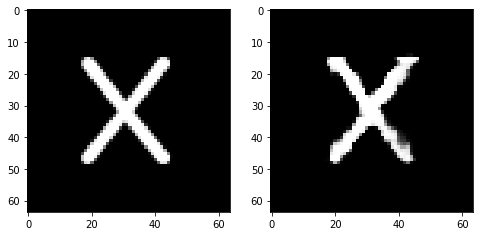

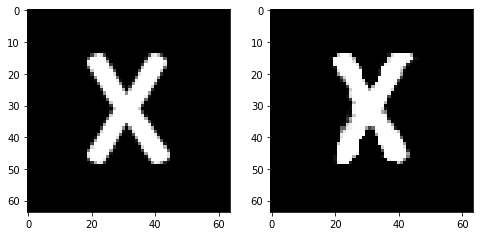

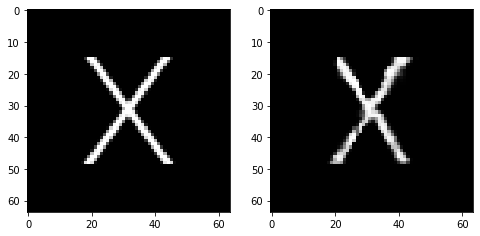

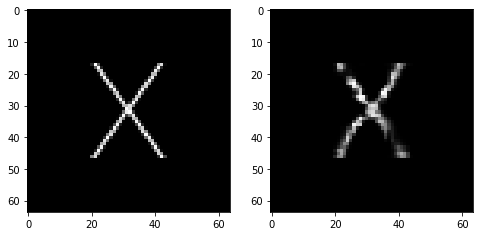

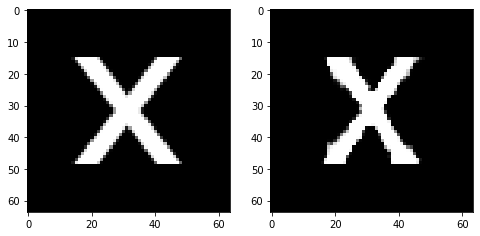

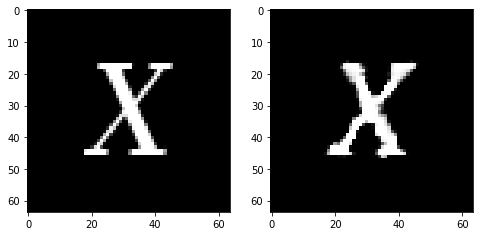

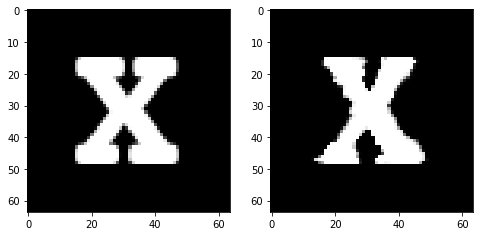

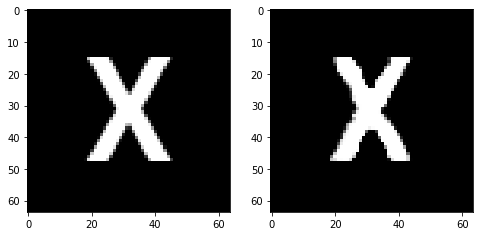

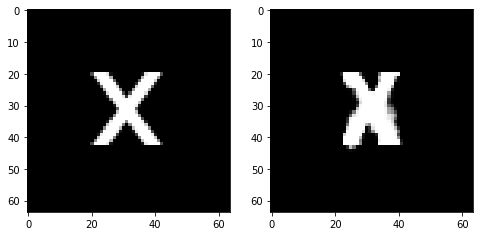

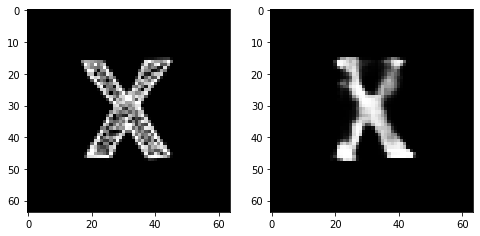

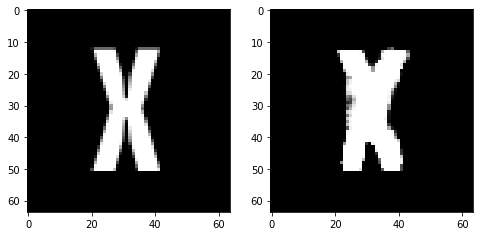

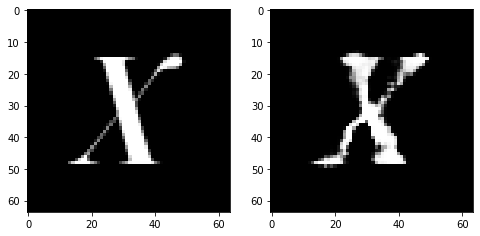

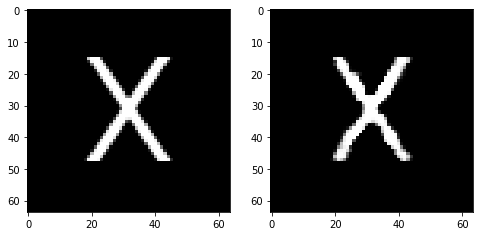

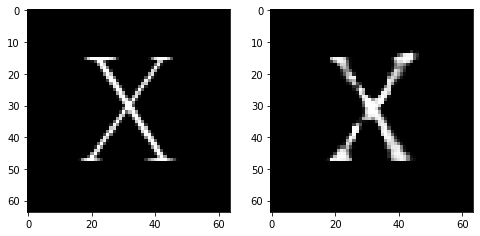

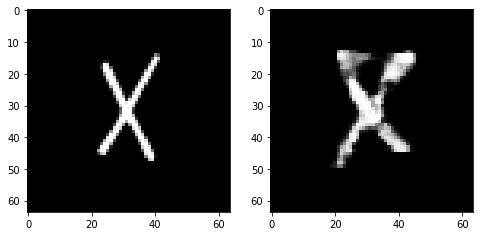

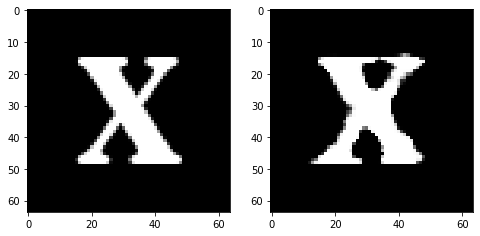

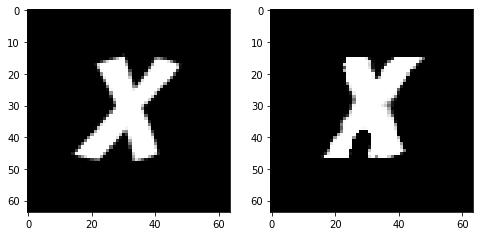

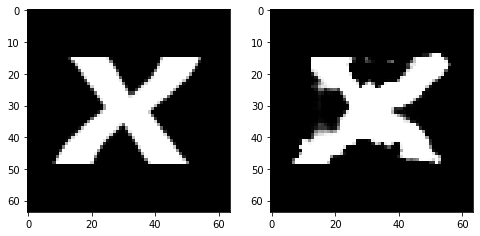

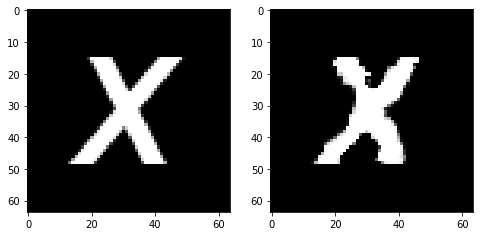

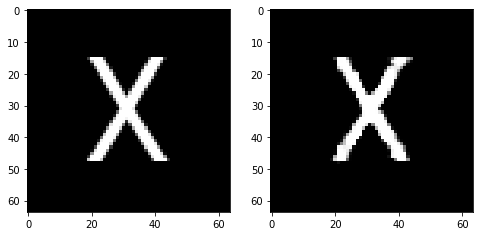

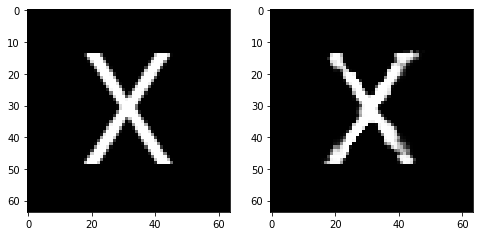

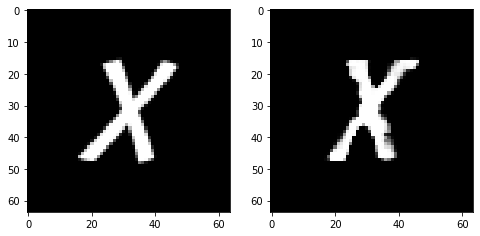

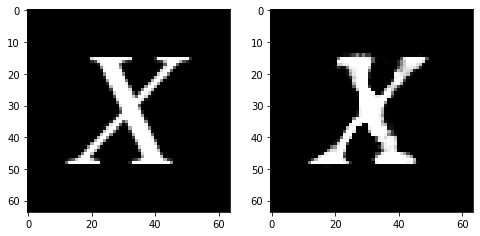

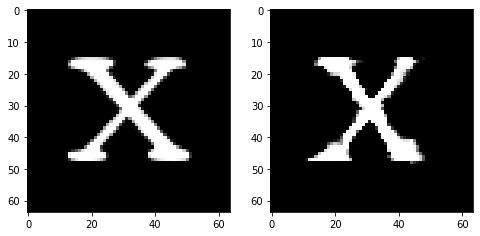

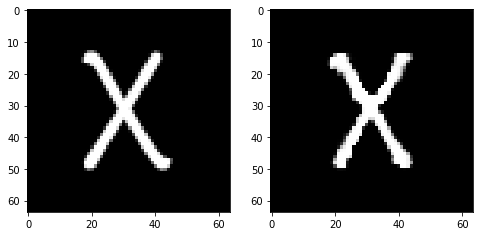

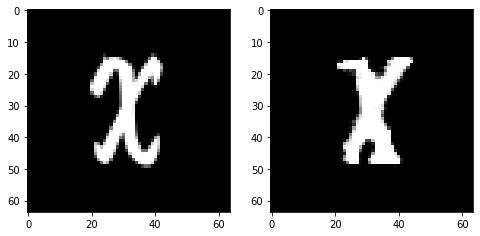

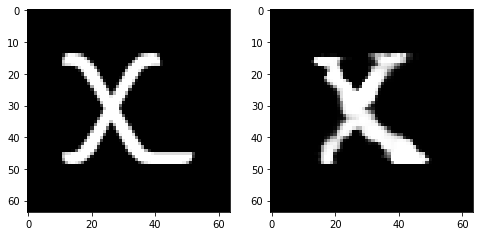

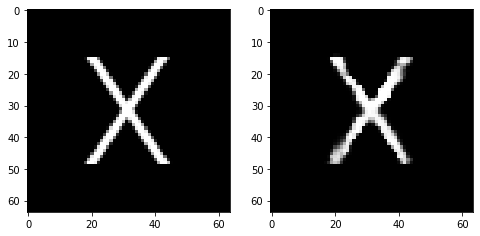

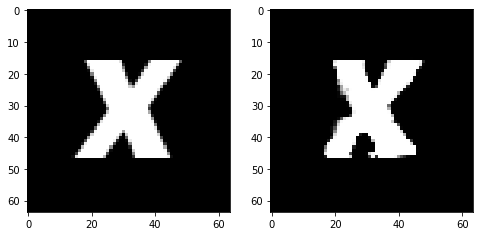

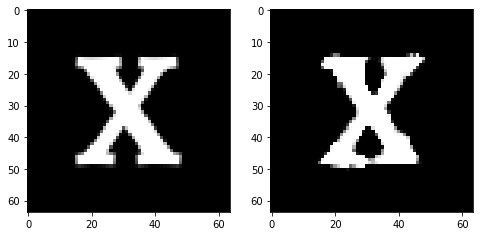

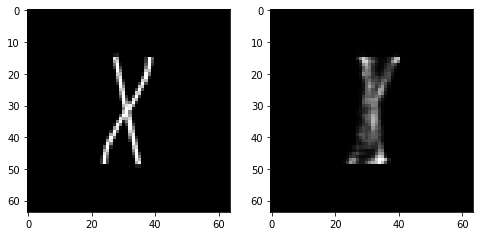

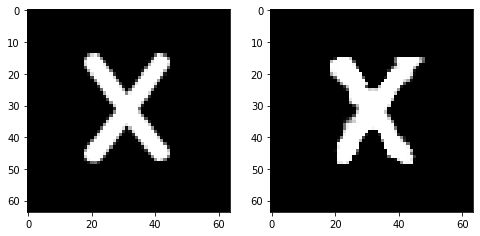

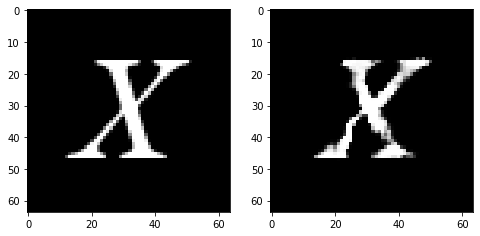

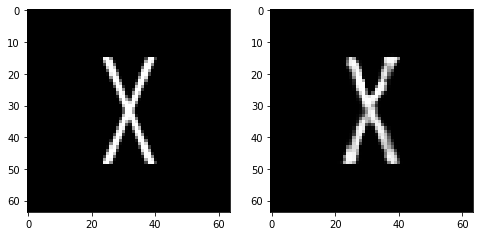

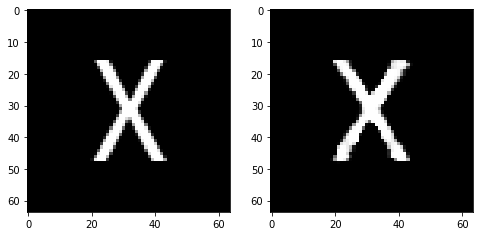

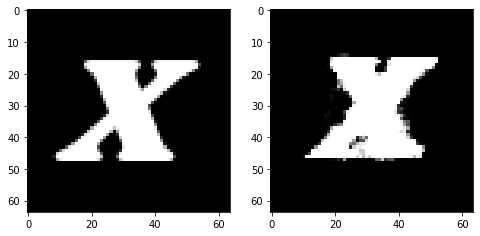

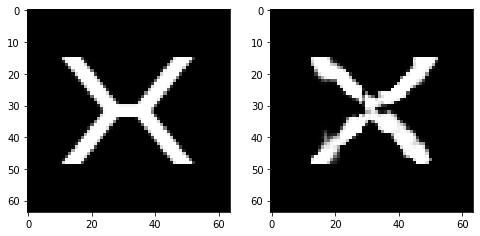

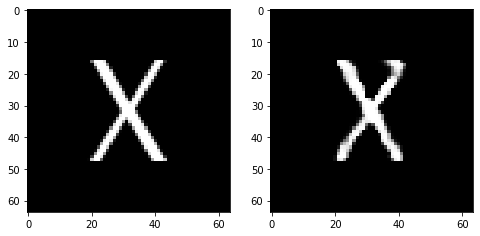

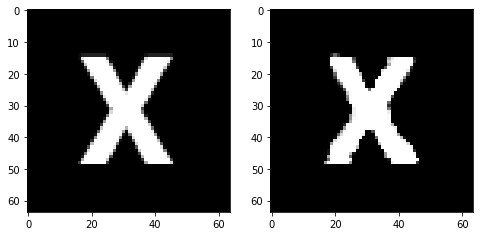

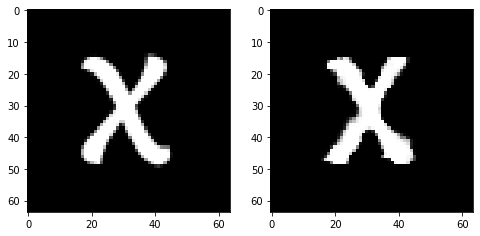

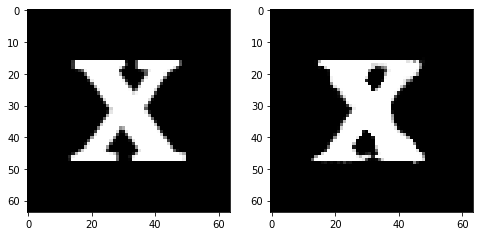

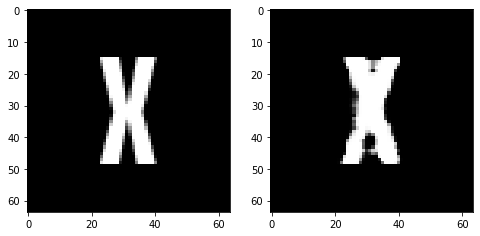

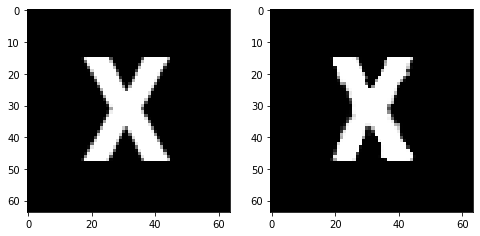

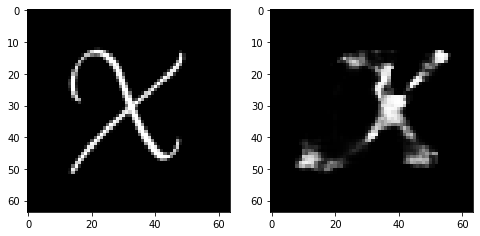

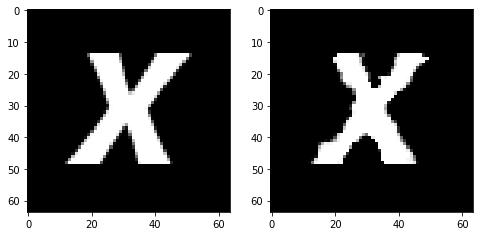

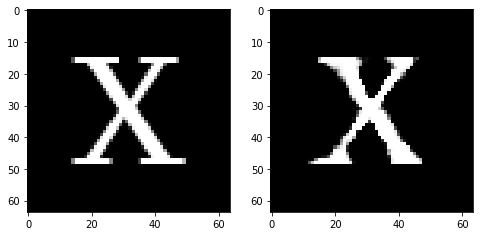

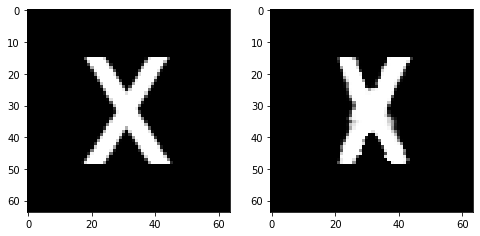

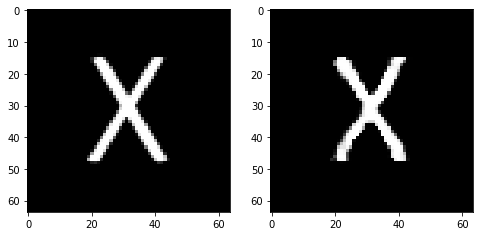

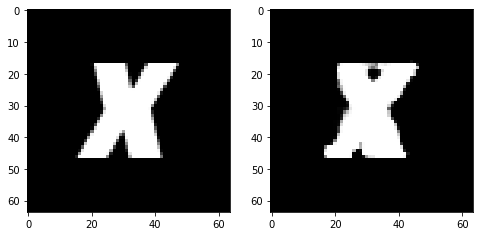

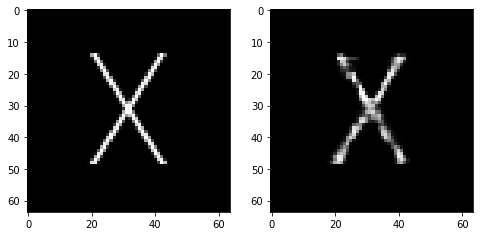

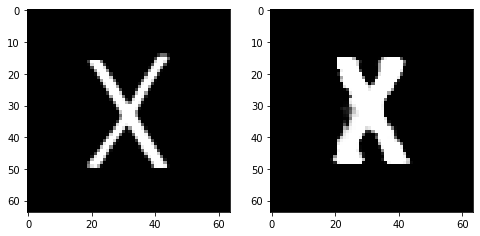

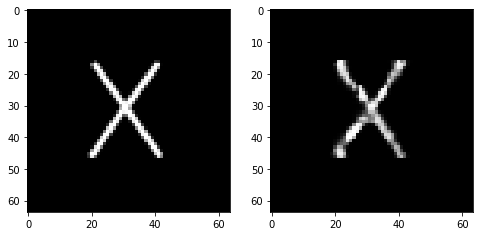

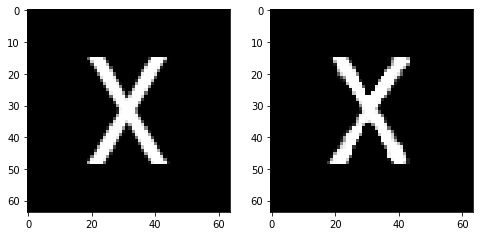

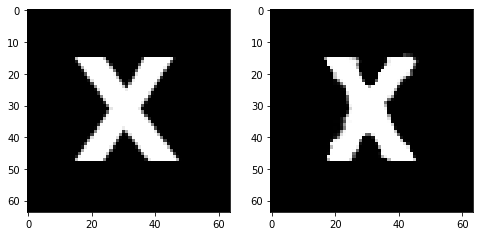

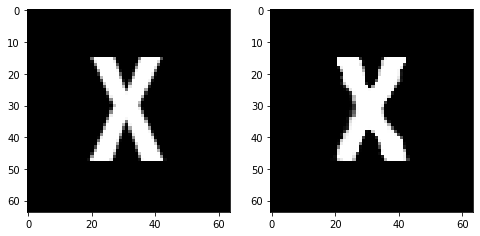

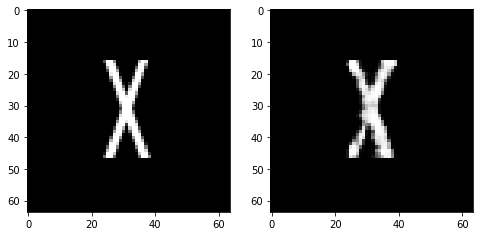

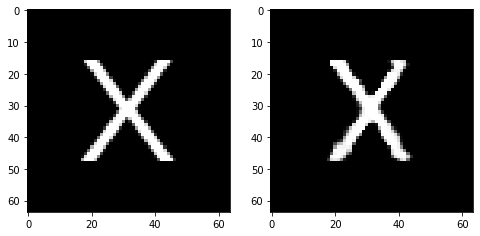

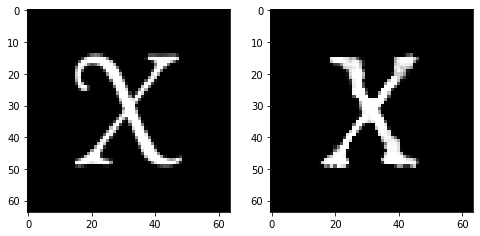

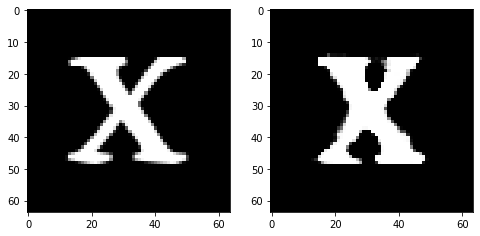

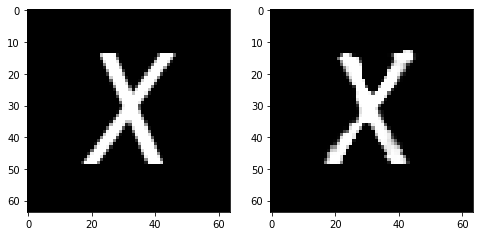

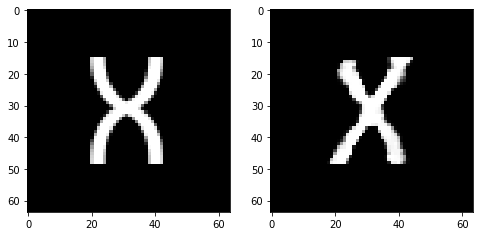

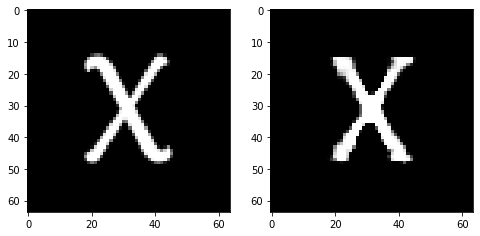

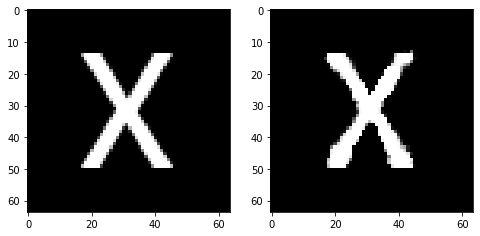

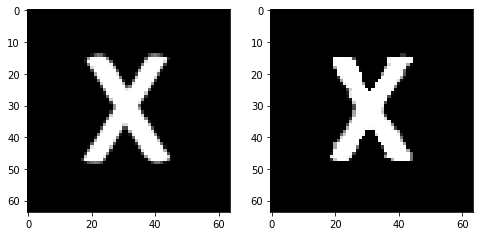

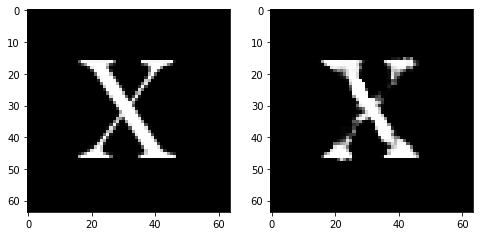

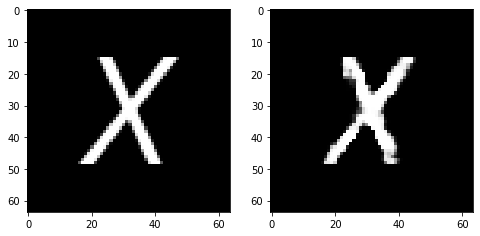

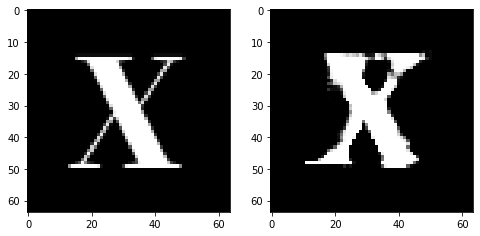

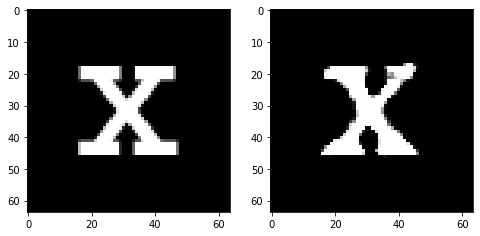

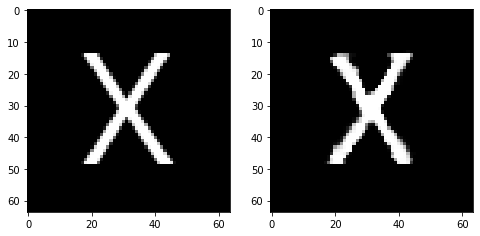

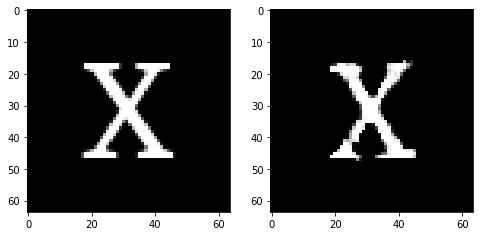

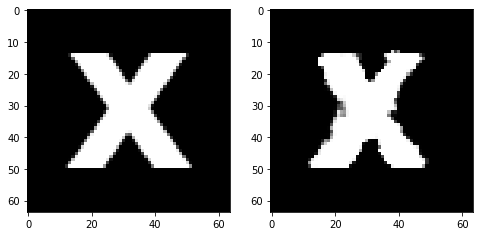

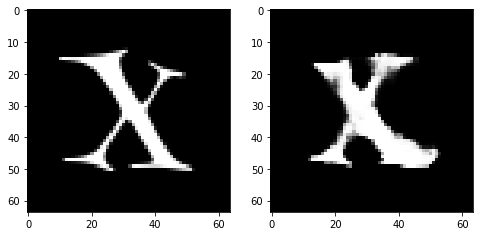

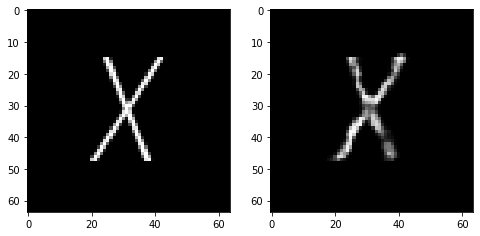

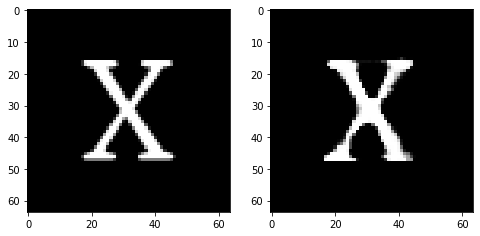

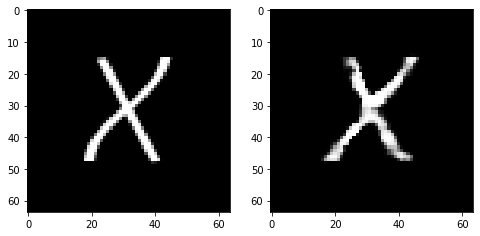

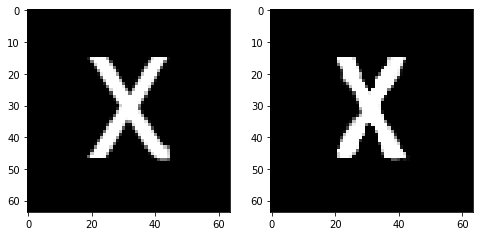

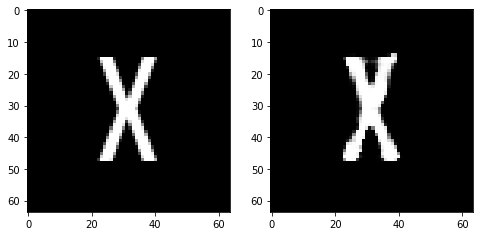

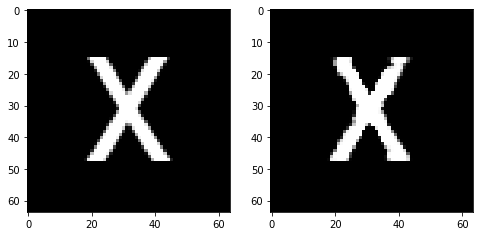

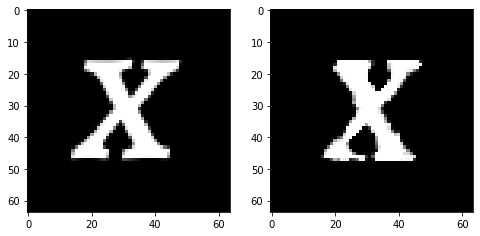

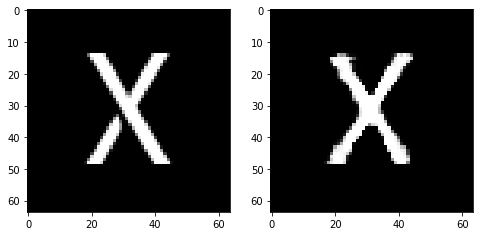

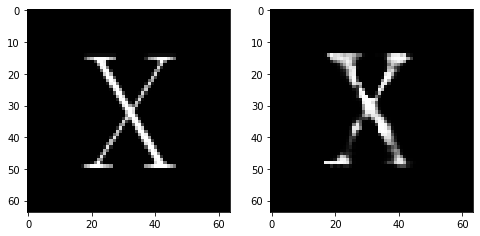

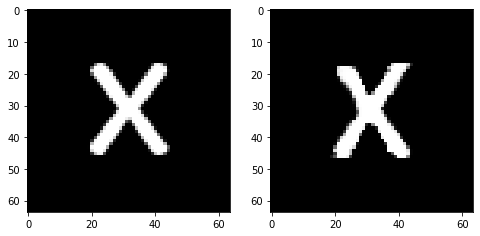

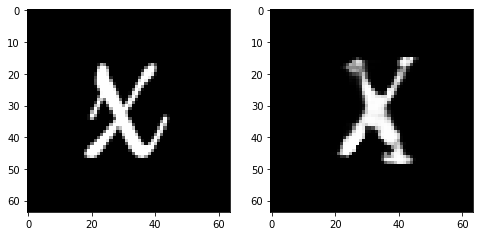

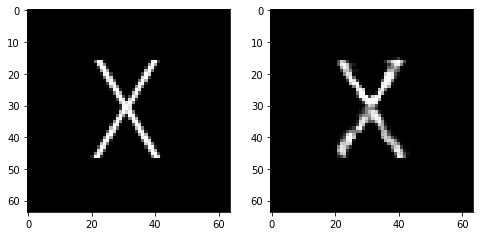

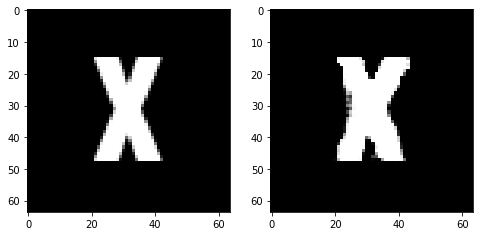

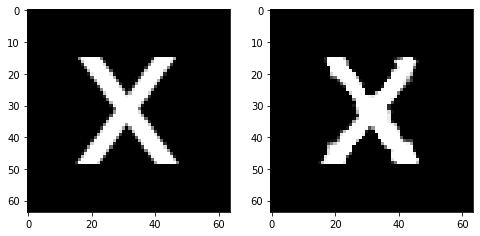

In [19]:
#look at result and ground truth side by side
for i, data in enumerate(val_data):
#     if i > 100:
#         break

    fig_letter = 'X'
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['R'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data[fig_letter][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0,ord(fig_letter) - ord('A')].detach().numpy(), cmap='gray')
    plt.show()

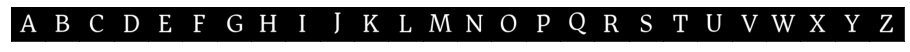

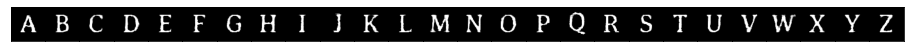

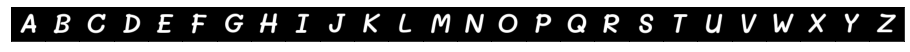

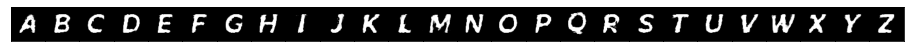

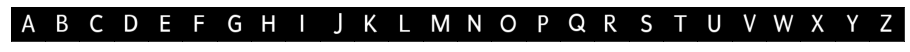

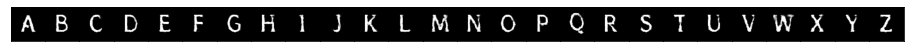

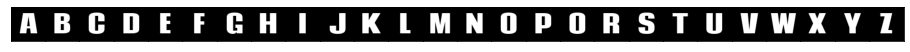

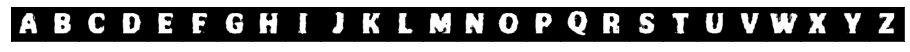

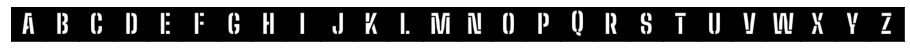

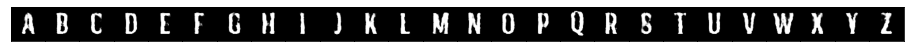

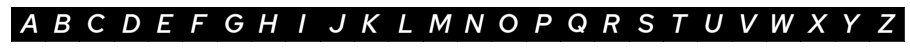

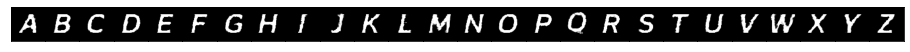

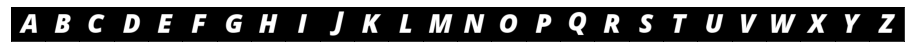

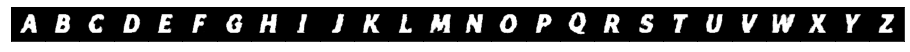

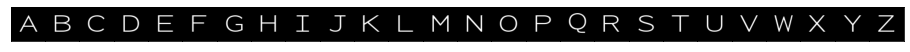

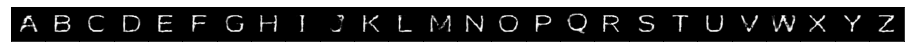

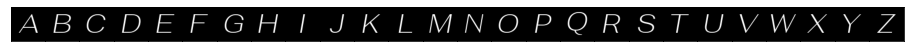

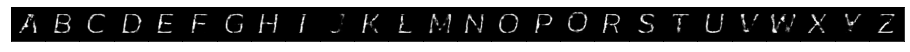

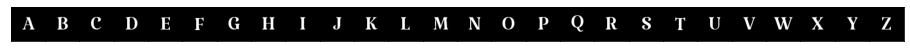

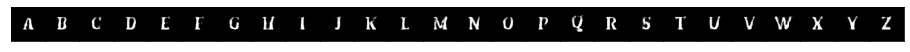

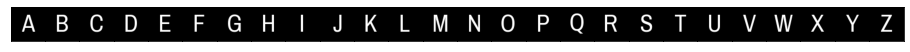

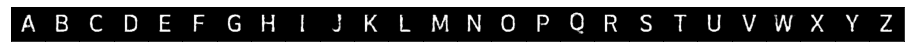

In [91]:
for i, data in enumerate(val_data):
    if i > 10:
        break
    n = len(alphabet)
    output = encdec(data['R'])
    fig = plt.figure(figsize=(16,8*n))
    fig.subplots_adjust(wspace=0, hspace=0)
    
    for j, c in enumerate(alphabet):
        # ground truth
        ax = fig.add_subplot(1, n, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(data[c][0].permute(1,2,0).detach().numpy(), cmap='gray')
        # generated
#         ax = fig.add_subplot(2, n, j + 1 + n)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         plt.imshow(output[0,ord(c) - ord('A')].detach().numpy(), cmap='gray')
    plt.show()
    
    fig = plt.figure(figsize=(16,8*n))
    fig.subplots_adjust(wspace=0, hspace=0)
    for j, c in enumerate(alphabet):
        # generated
        ax = fig.add_subplot(1, n, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(output[0,ord(c) - ord('A')].detach().numpy(), cmap='gray')
    
#     plt.savefig('all-alphabet.png')
    

In [18]:
#set up for evaluation
criterion_L1 = nn.L1Loss()
criterion_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)

In [ ]:
#evaluate accuracy using L1 loss
val_len = len(val_data)
sum_L1 = torch.zeros((len(alphabet), val_len))
sum_ssim = torch.zeros((len(alphabet), val_len))
for i, data in enumerate(val_data):
    print(i)
    output = encdec(data['R'])
    
    for c in alphabet:
        truth = data[c].reshape(1, 1, img_size, img_size)
        index = ord(c) - ord('A')
        generated = output[0, index].reshape(1,1, img_size, img_size)
        
        loss_L1 = criterion_L1(truth, generated)

        output_norm = (generated + 1) / 2
        truth_norm = (truth+1) / 2
        
        loss_ssim = 1 - criterion_ssim(output_norm, truth_norm)
        
        sum_L1[index][i] += loss_L1
        sum_ssim[index][i] += loss_ssim
        
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213


In [ ]:
l1 = sum_L1.detach().numpy()
ssim = sum_ssim.detach().numpy() 

# average by alphabet
print('average l1 loss by alphabet', np.mean(l1, axis=1))
print('average ssim loss by alphabet', np.mean(ssim, axis=1))

# 
